# deepBreaks applications
## Modeling maximum wavelength absorption based on opsin gene amino-acid sequence  
In this study we are trying to use 175 amino-acid sequences to fir predictive models for predicting a phenotype which is the the maximum wavelength absobption.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.  
![alt text](../img/lite_mar/lite_mar.png)

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax.fasta' 

# path to metadata
metaDataFileName = '~/Documents/RahLab/deepBreaks_data/lite_mar/meta_RodOpsinLambdaMax.tsv' 

# name of the phenotype
mt = 'LambdaMax'

# type of the sequences
seq_type = 'amino-acid'

# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'reg' 
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (175, 2)
reading fasta file
Done
Shape of data is:  (175, 356)
CPU times: user 48.4 ms, sys: 2.09 ms, total: 50.5 ms
Wall time: 50.3 ms


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [6]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Species  LambdaMax
1_KC250344.1_Acipenser_transmontanus  Acipenser_transmontanus      540.0
2_AF137208.1_Amia_calva                            Amia_calva      527.0
3_HQ444181.1_Gymnothorax_favagineus    Gymnothorax_favagineus      488.0
4_HQ444182.1_Gymnothorax_reticularis  Gymnothorax_reticularis      486.0
5_HQ444180.1_Rhinomuraena_quaesita      Rhinomuraena_quaesita      498.0

In [7]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


p1   p2   p3   p4   p5   p6   p7   p8  \
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                       p9  p10  ... p347 p348 p349 p350 p351  \
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
2_AF137208.1_Amia_calva               NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   

                                     p352 p353 p354 p355 p356  
1_KC250344.1_Acipenser_transmontanus  NaN  NaN  NaN  NaN  NaN  
2_AF137208.1_Amia_calva               NaN  NaN  NaN  NaN  NaN  
3_HQ444181.1_Gymnothorax_favagineus   NaN  NaN  NaN  NaN  NaN  
4_HQ444182.1_Gymnothorax_reticularis  NaN  NaN  NaN  NaN  NaN  
5_HQ444180.1_Rhinomuraena_quaesita    NaN  NaN  NaN  NaN  NaN  

[5 rows x 356 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold
7. calculate the pair-wise Normalized mutual information (NMI) for all the columns
8. use the NMI values for DBSCAN and cluster the correlated positions together
9. keep only one column for each group and drop the rest from the training data set
10. one-hot encode the remaining columns

In [8]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df_cleaned = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df_cleaned.shape)

Shape of data before missing/constant care:  (175, 356)
Shape of data after missing/constant care:  (175, 182)
CPU times: user 43 ms, sys: 1.5 ms, total: 44.5 ms
Wall time: 43.3 ms


In [9]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df_cleaned.shape)
df_cleaned = prp.imb_care(dat=df_cleaned, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df_cleaned.shape)

Shape of data before imbalanced care:  (175, 182)
Shape of data after imbalanced care:  (175, 127)
CPU times: user 154 ms, sys: 6.04 ms, total: 160 ms
Wall time: 155 ms


In [10]:
%%time
# you may want to perform your analysis only on a random sample of the positions.
# Here you can have a random sample of your main data set.
print('number of columns of main data befor: ', df_cleaned.shape[1])
df_cleaned = prp.col_sampler(dat=df_cleaned, sample_frac=sampleFrac)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  127
number of columns of main data after:  127
CPU times: user 192 µs, sys: 67 µs, total: 259 µs
Wall time: 204 µs


In [11]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df_cleaned.shape[1])
df_cleaned = prp.redundant_drop(dat=df_cleaned, meta_dat=metaData,
                                feature=mt, model_type=anaType, report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  127
number of columns of main data after:  41
CPU times: user 103 ms, sys: 3.16 ms, total: 106 ms
Wall time: 104 ms


In [12]:
%%time
print('calculating normalized mutual information')
cr = prp.vec_nmi(dat=df_cleaned, report_dir=report_dir)
print(cr.shape)

calculating normalized mutual information
(41, 41)
CPU times: user 255 ms, sys: 5.35 ms, total: 261 ms
Wall time: 258 ms


In [13]:
print('The NMI matrix looks like this. The values are between 0 (non-related) and 1 (exact the same).')
cr.head()

The NMI matrix looks like this. The values are between 0 (non-related) and 1 (exact the same).


p96      p108      p111      p122      p124      p127      p129  \
p96   1.000000  0.378400  0.151487  0.034152  0.159214  0.024270  0.018654   
p108  0.378400  1.000000  0.076273  0.080092  0.269525  0.113859  0.056389   
p111  0.151487  0.076273  1.000000  0.027384  0.061404  0.026898  0.013615   
p122  0.034152  0.080092  0.027384  1.000000  0.156184  0.057671  0.370532   
p124  0.159214  0.269525  0.061404  0.156184  1.000000  0.047885  0.194405   

          p132      p133      p137  ...      p225      p232      p261  \
p96   0.338695  0.030399  0.068836  ...  0.125446  0.135557  0.017134   
p108  0.118880  0.116711  0.280286  ...  0.230093  0.079887  0.014121   
p111  0.008603  0.001317  0.018241  ...  0.009853  0.056439  0.018982   
p122  0.023235  0.020988  0.110121  ...  0.044645  0.027638  0.110436   
p124  0.019728  0.037560  0.181108  ...  0.161855  0.030746  0.062144   

          p282      p286      p289      p292      p297      p299      p307  
p96   0.060739  0.083060  0.110059  0.019748  0.053675  0.014449  0.444237  
p108  0.378755  0.256722  0.090218  0.019328  0.220573  0.088619  0.282206  
p111  0.072038  0.013970  0.176180  0.003369  0.031834  0.042464  0.132648  
p122  0.066625  0.183053  0.029164  0.023343  0.075803  0.020525  0.034214  
p124  0.181871  0.352183  0.085357  0.003091  0.311223  0.040696  0.091138  

[5 rows x 41 columns]

In [14]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr, report_dir=report_dir, threshold=.85, needs_pivot=False)

finding colinear groups
CPU times: user 85.5 ms, sys: 21.3 ms, total: 107 ms
Wall time: 145 ms


In [15]:
print('grouping features')
dc = prp.group_features(dat = dc_df, report_dir=report_dir)

grouping features


In [16]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (175, 41)
Shape of data after collinearity care:  (175, 41)


In [17]:
# merge with metadata
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [18]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned, meta_var=mt, 
                                                 model_type= anaType, models_to_select=models_to_select,
                                                    report_dir=report_dir)

CPU times: user 4.7 s, sys: 1.97 s, total: 6.67 s
Wall time: 6.98 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-07-10_22-38-08/Extreme Gradient Boosting_350.png
Extreme Gradient Boosting  Done
/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-07-10_22-38-08/Random Forest Regressor_350.png
Random Forest Regressor  Done
/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-07-10_22-38-08/Extra Trees Regressor_350.png
Extra Trees Regressor  Done


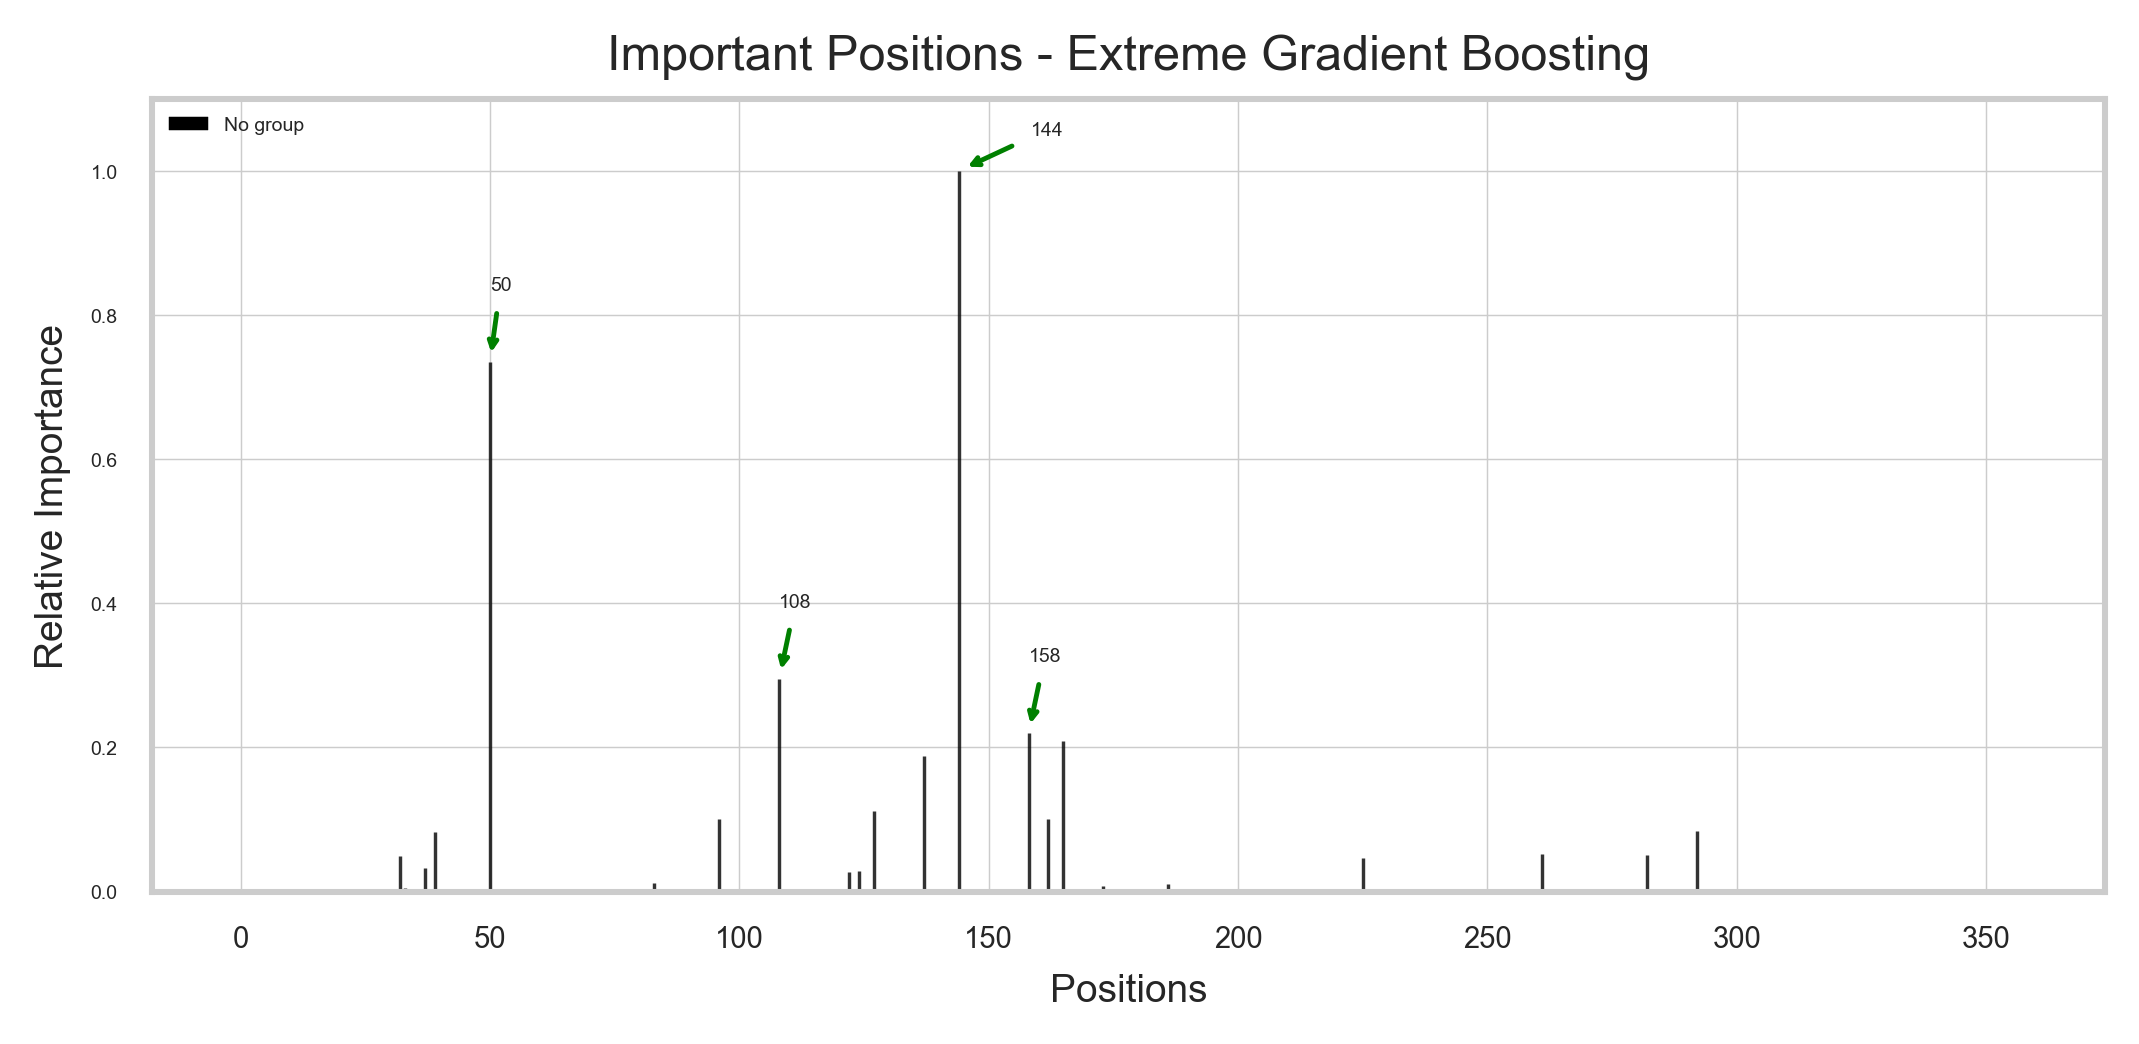

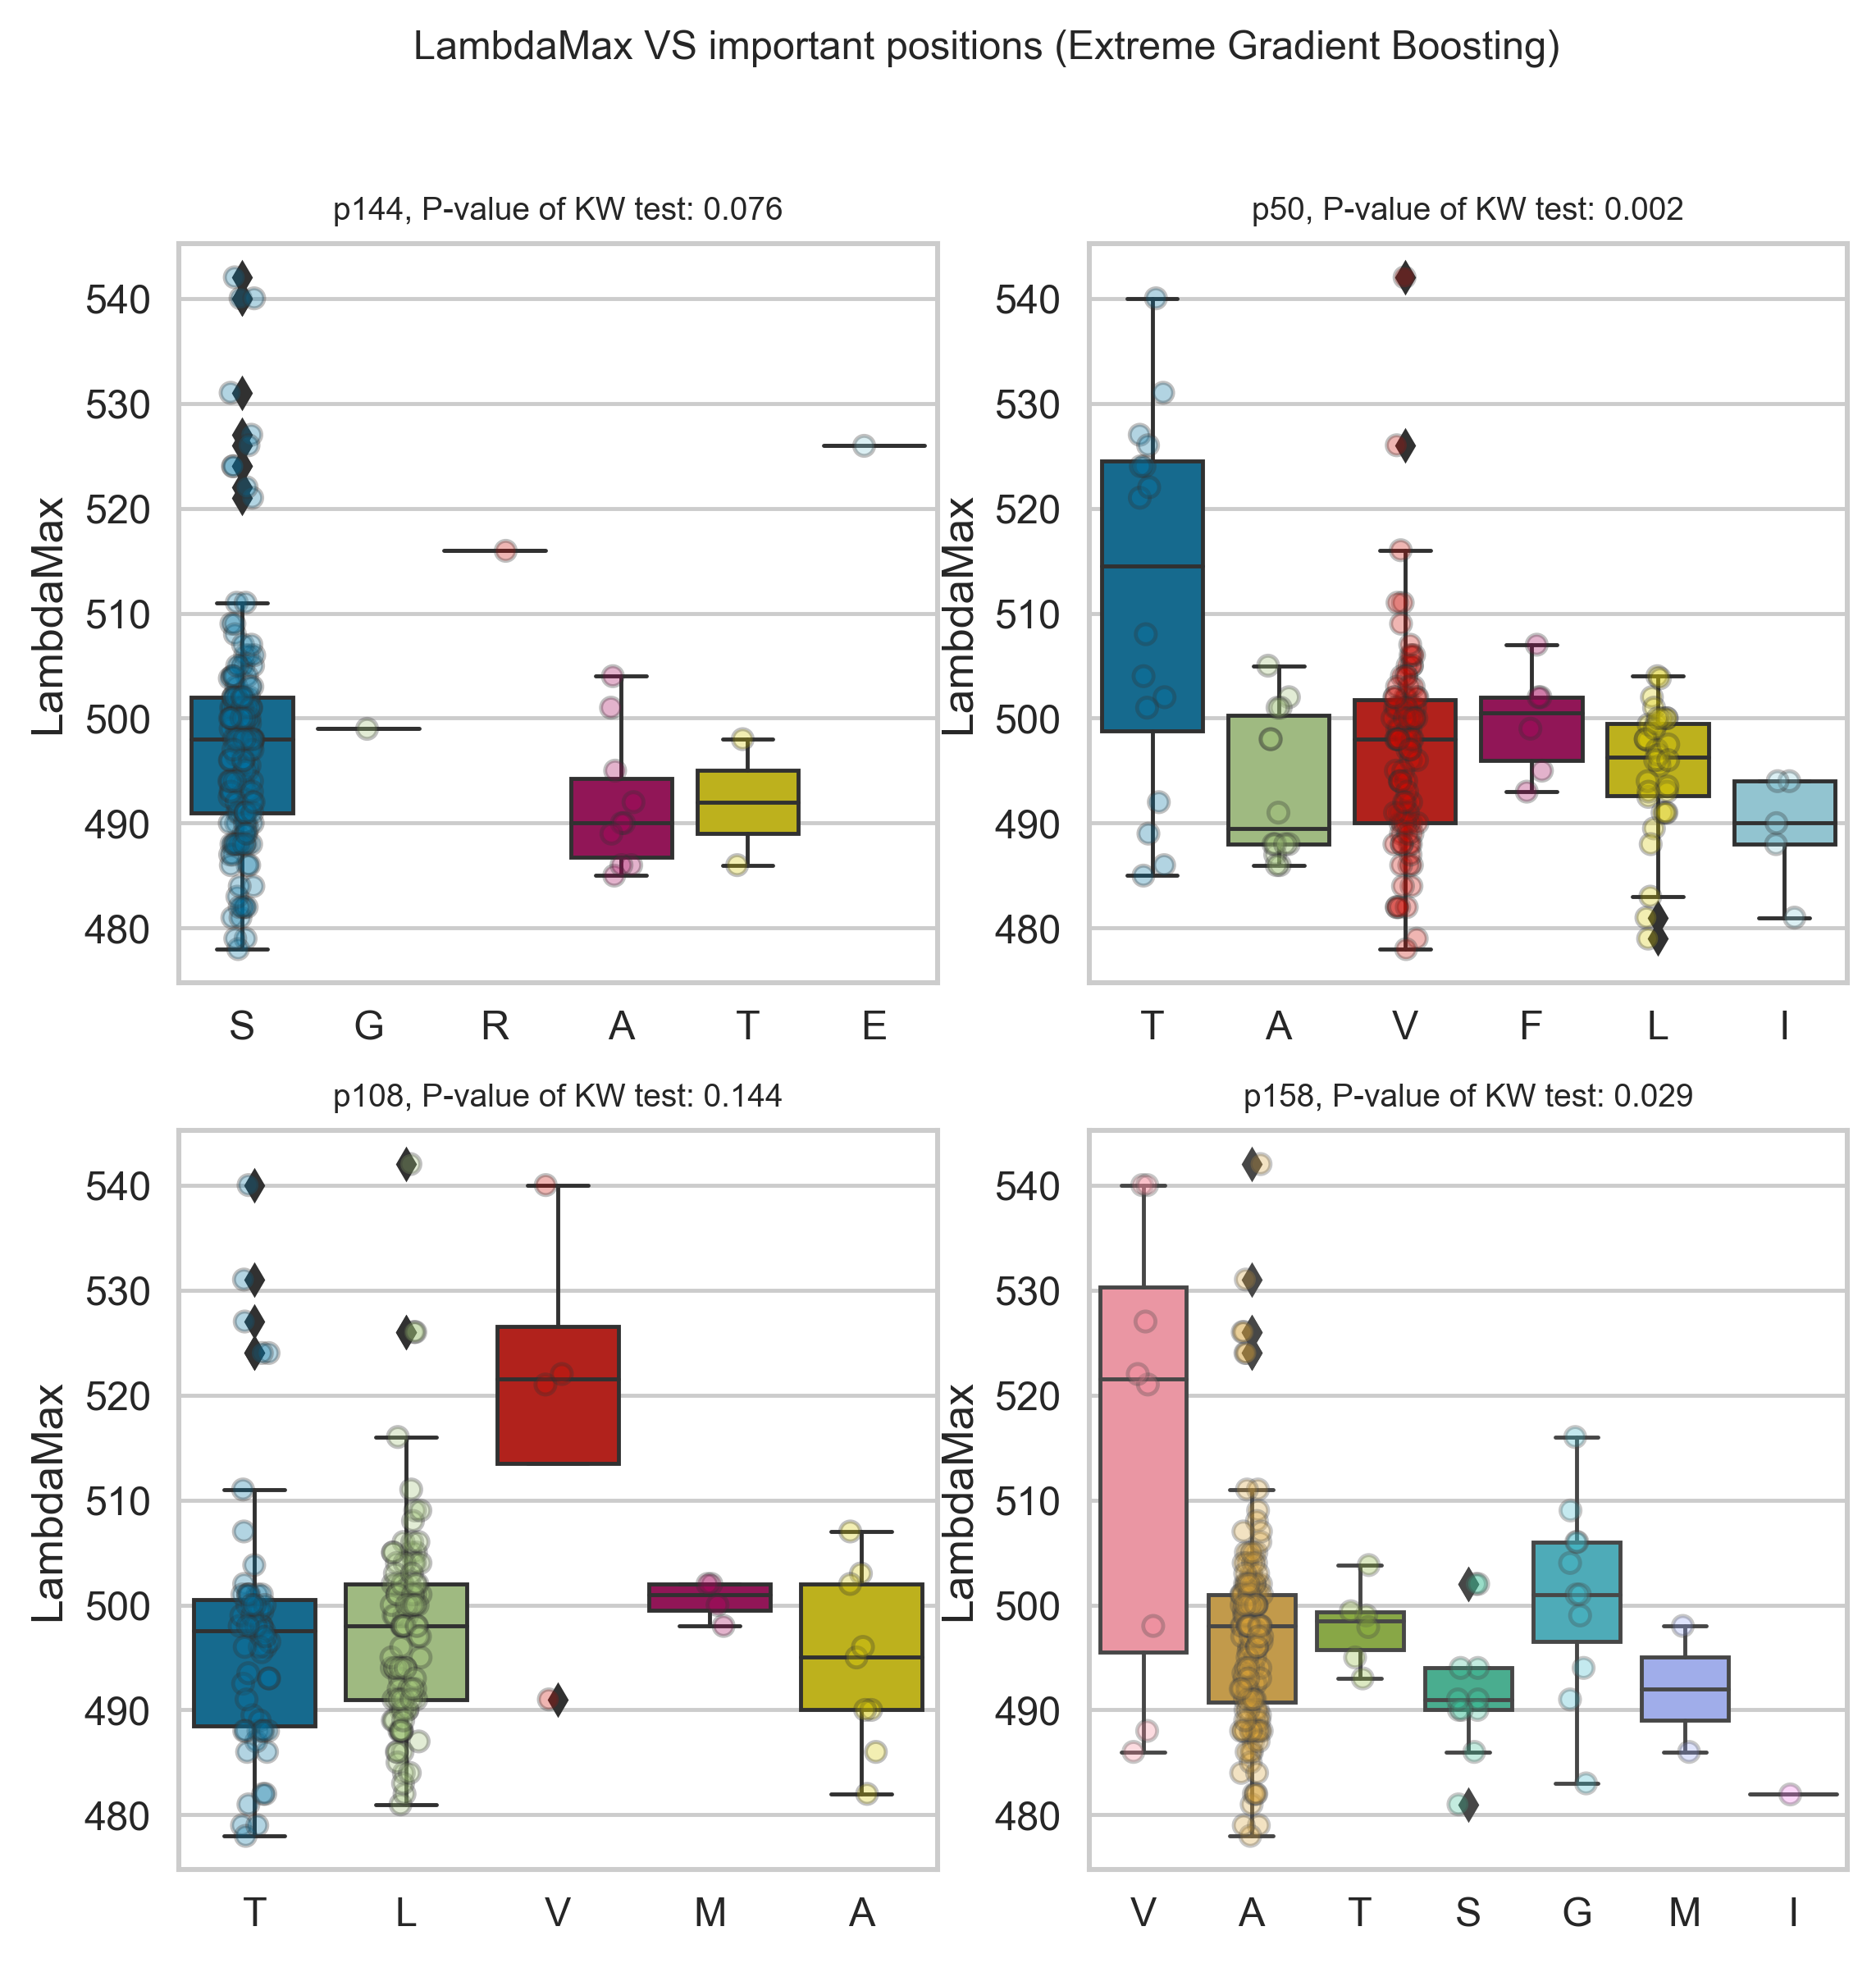

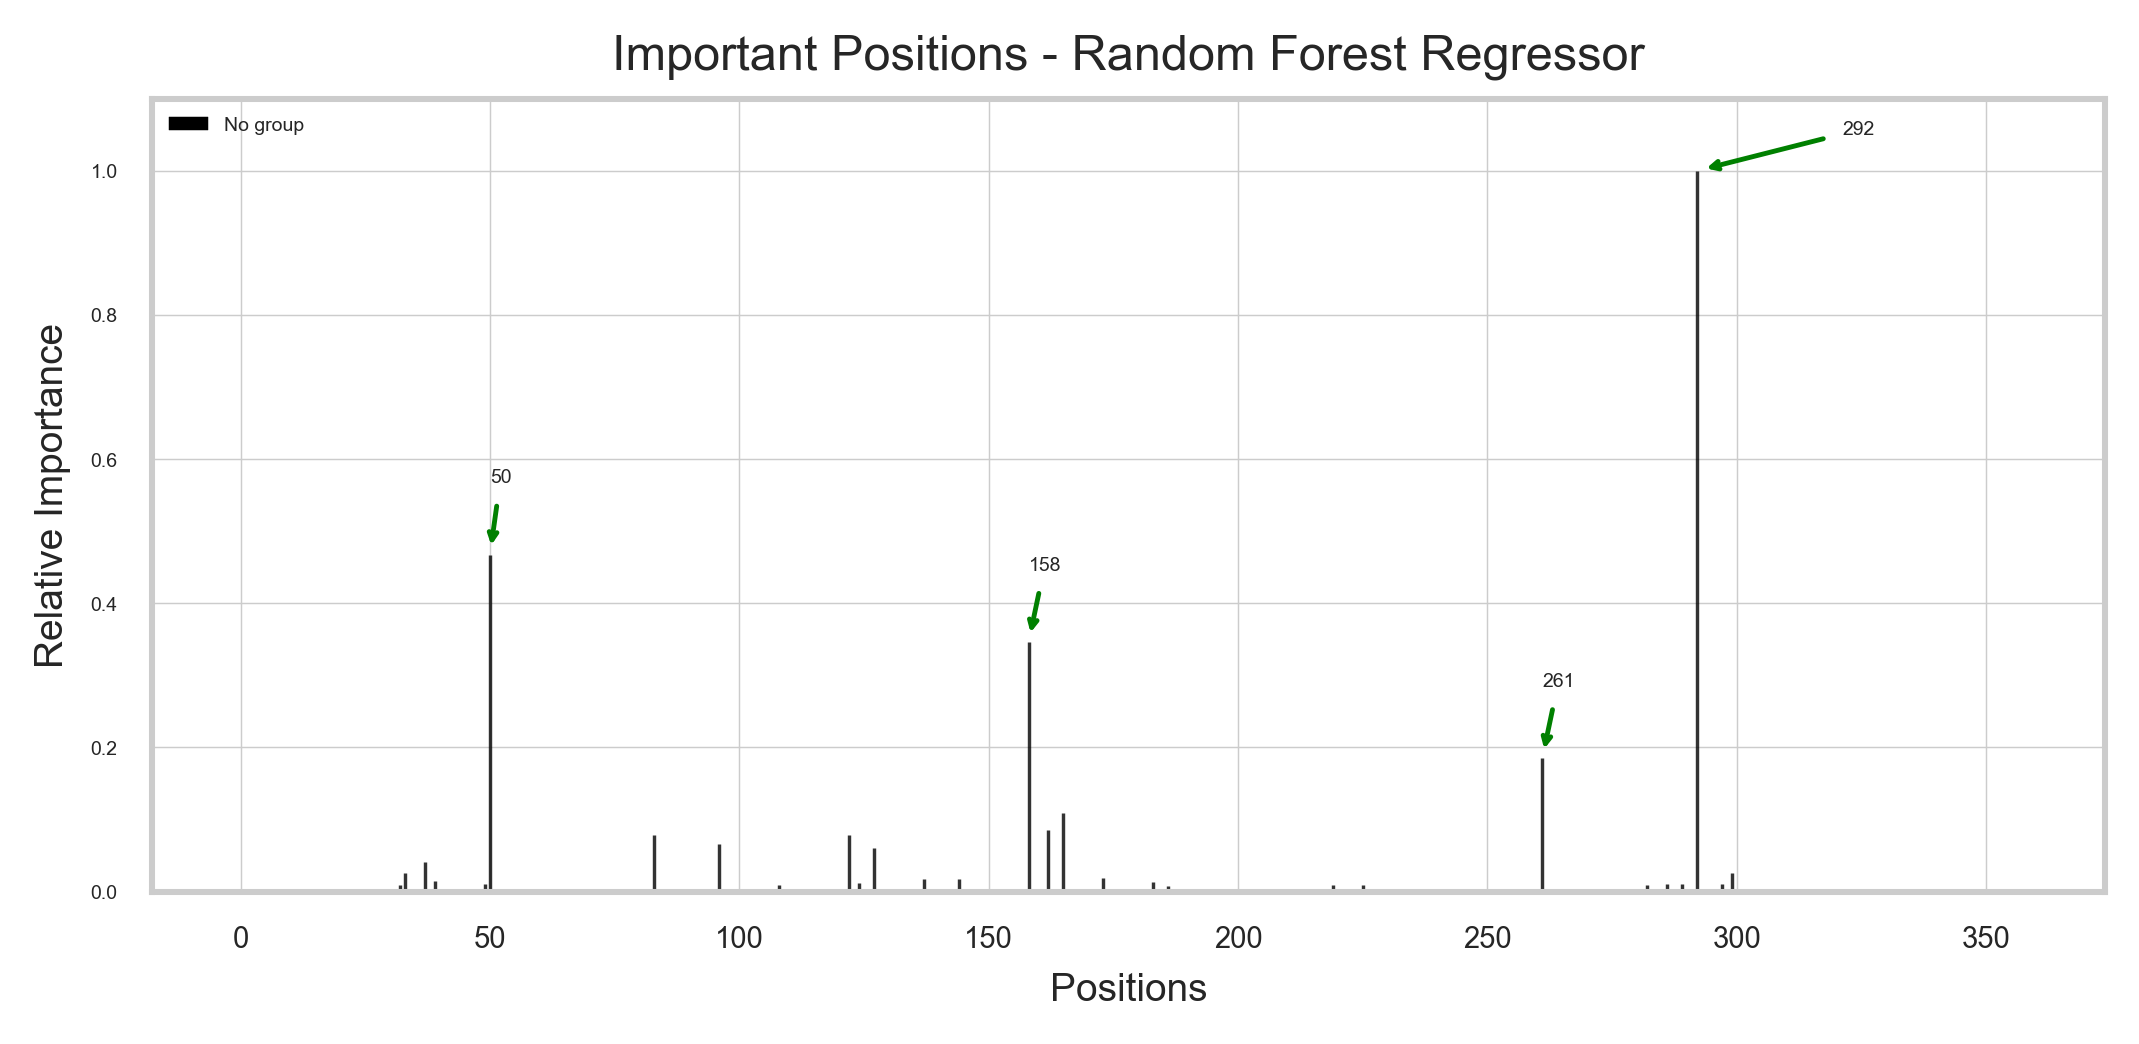

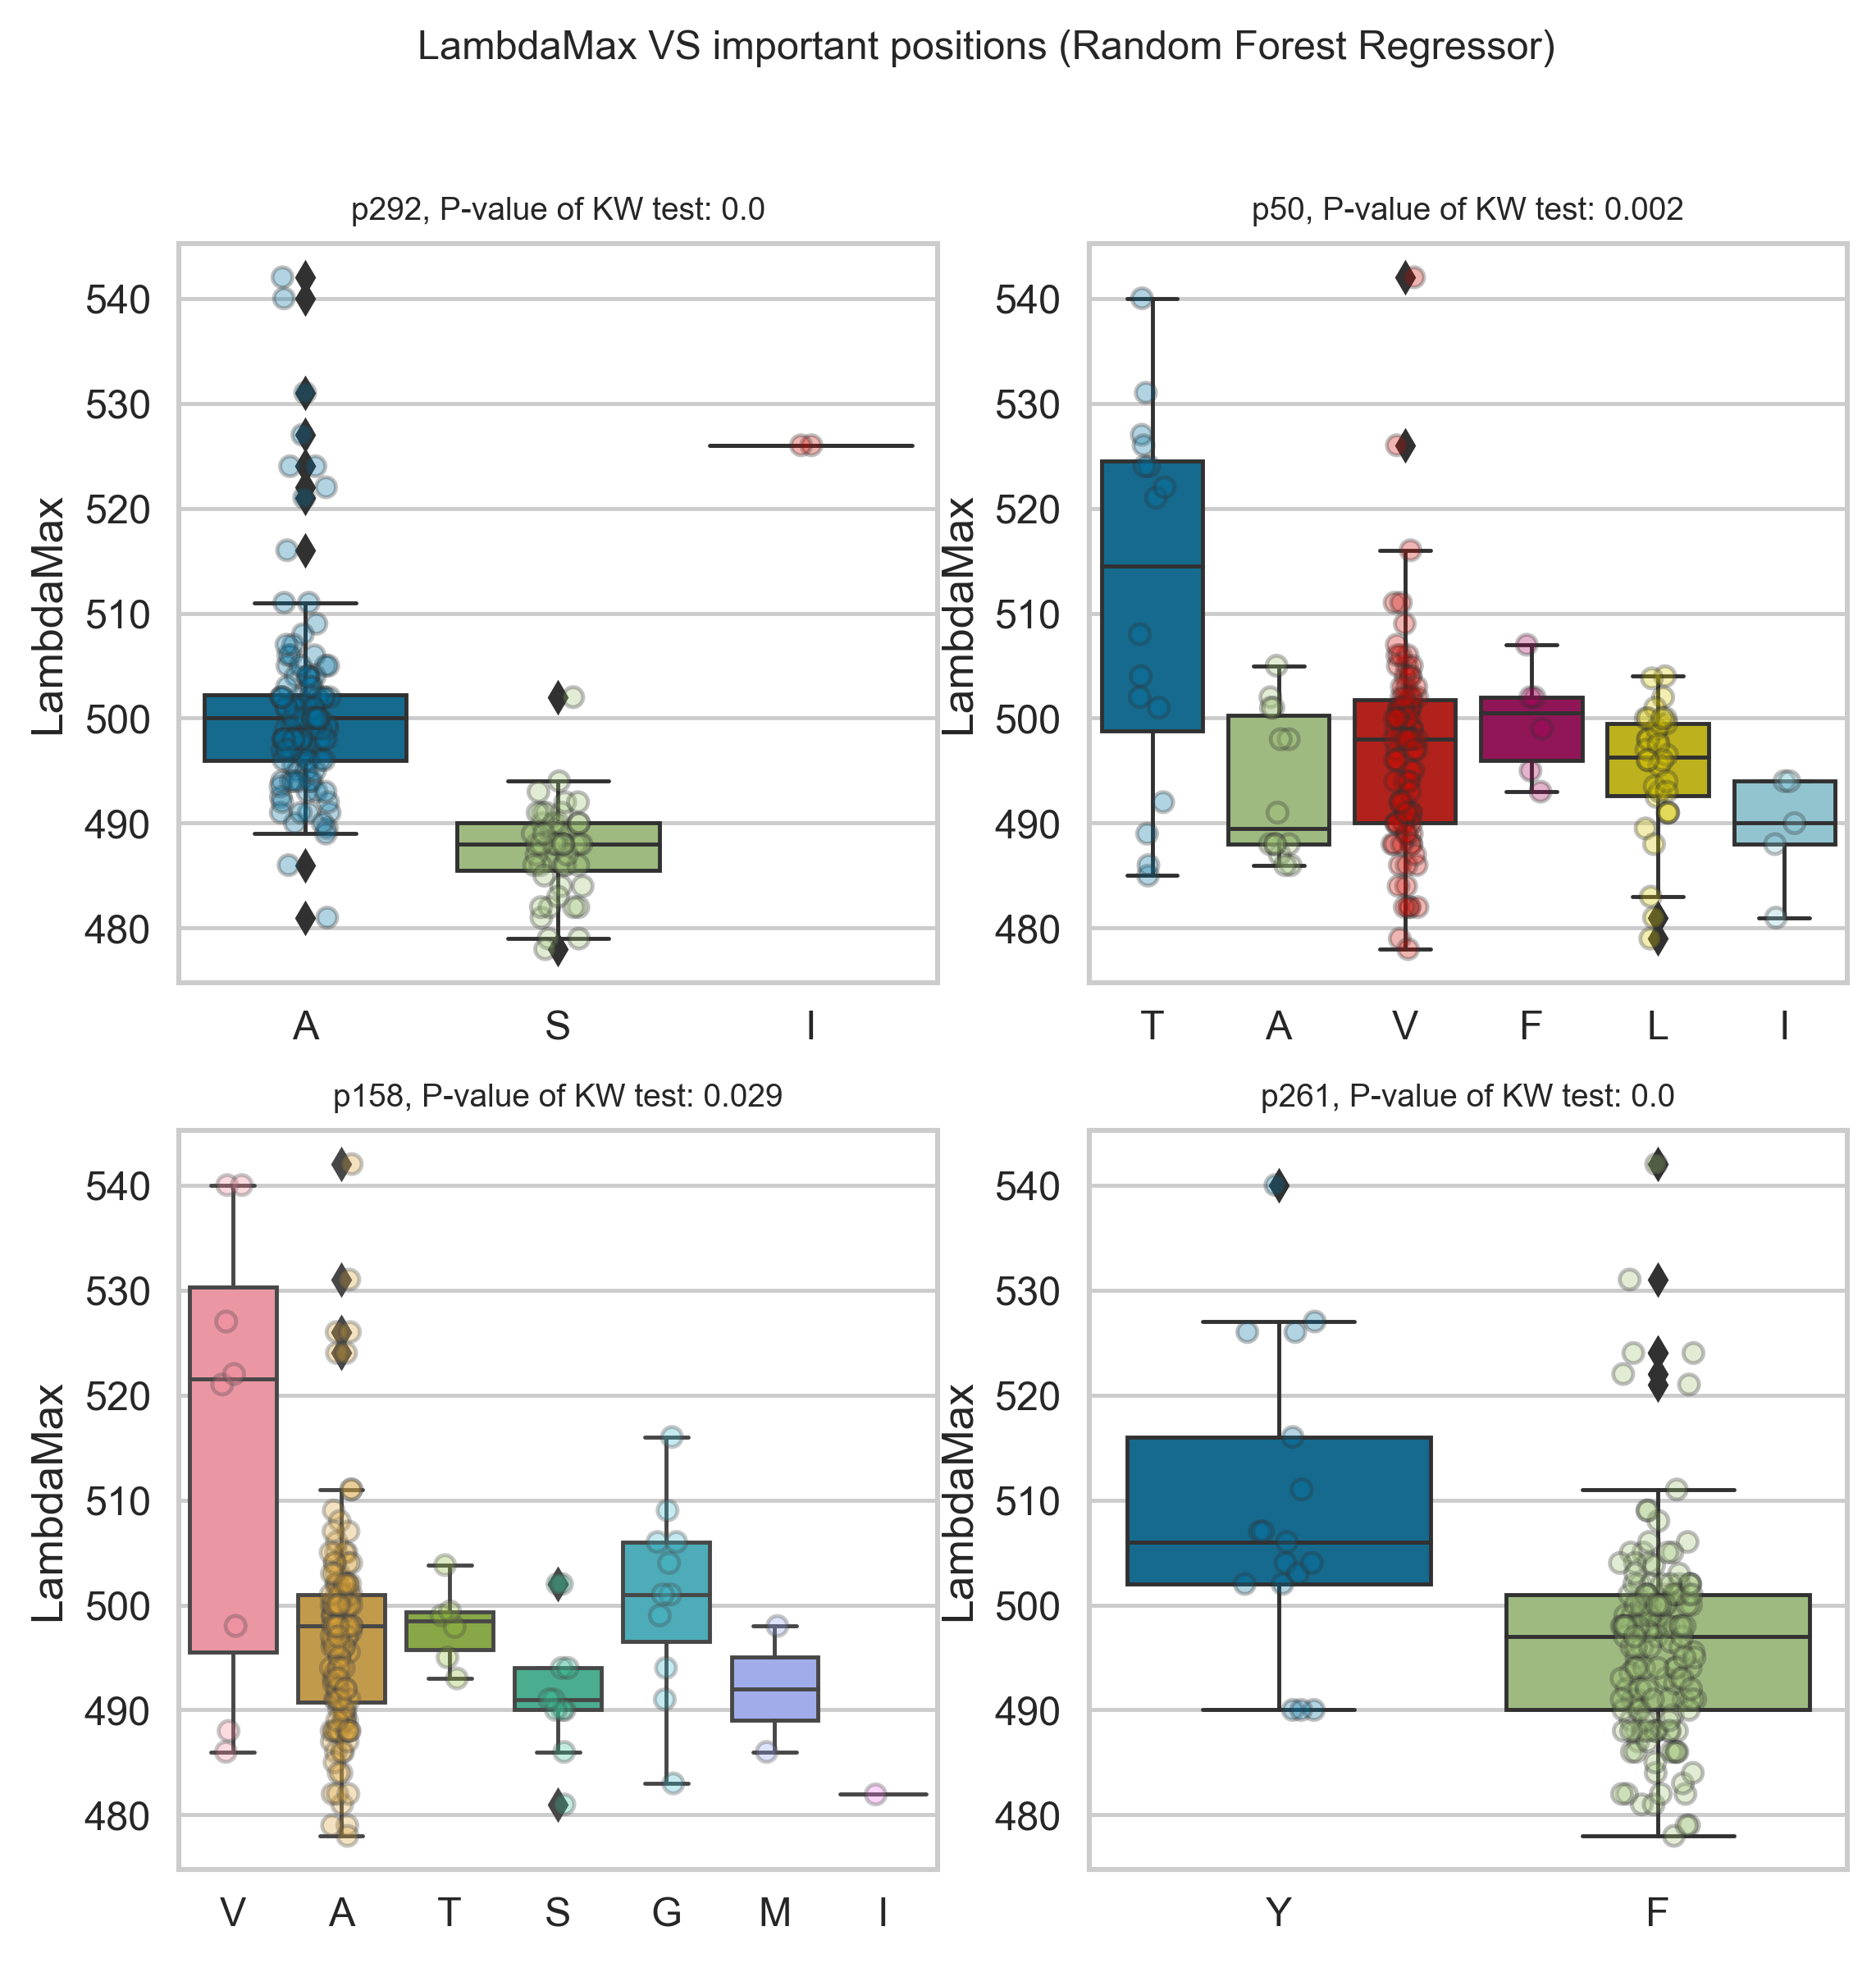

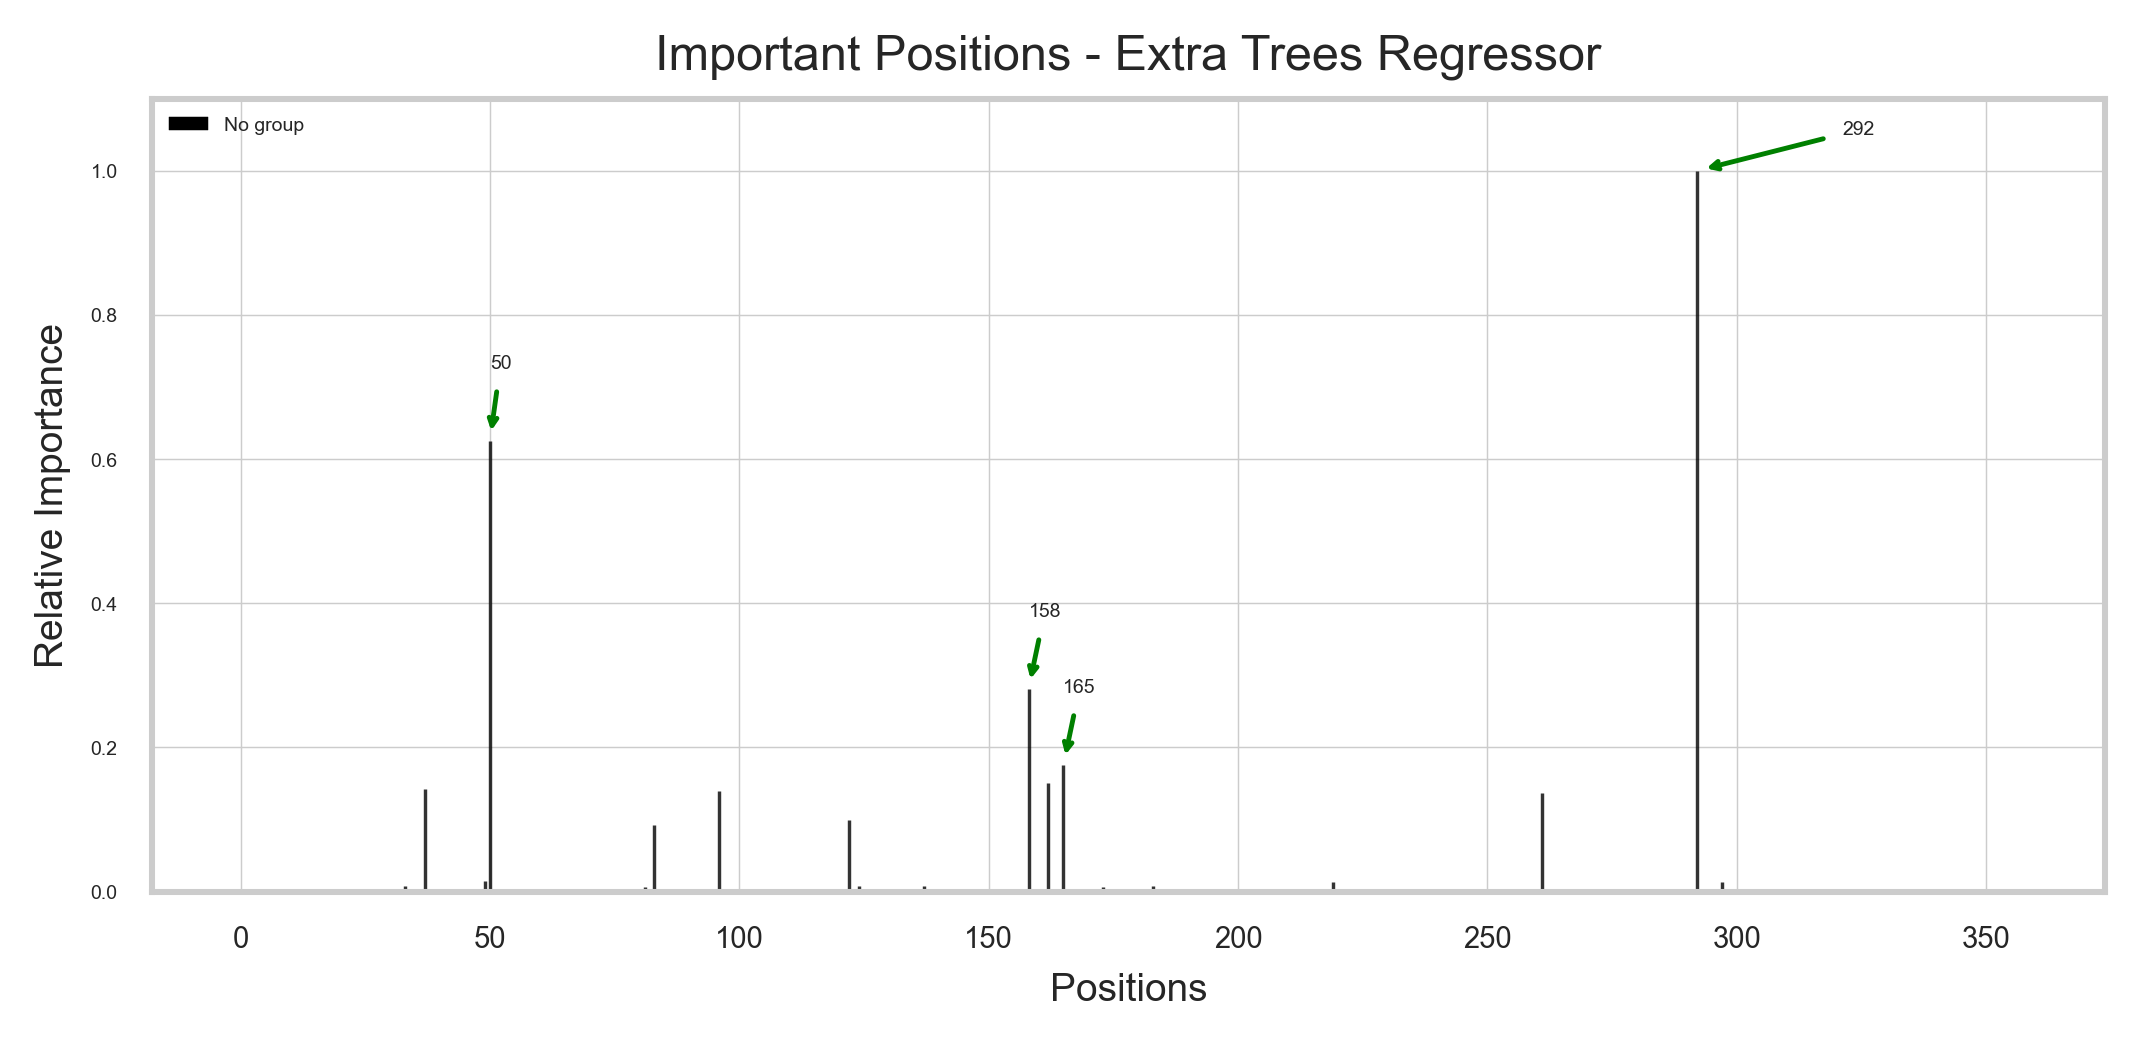

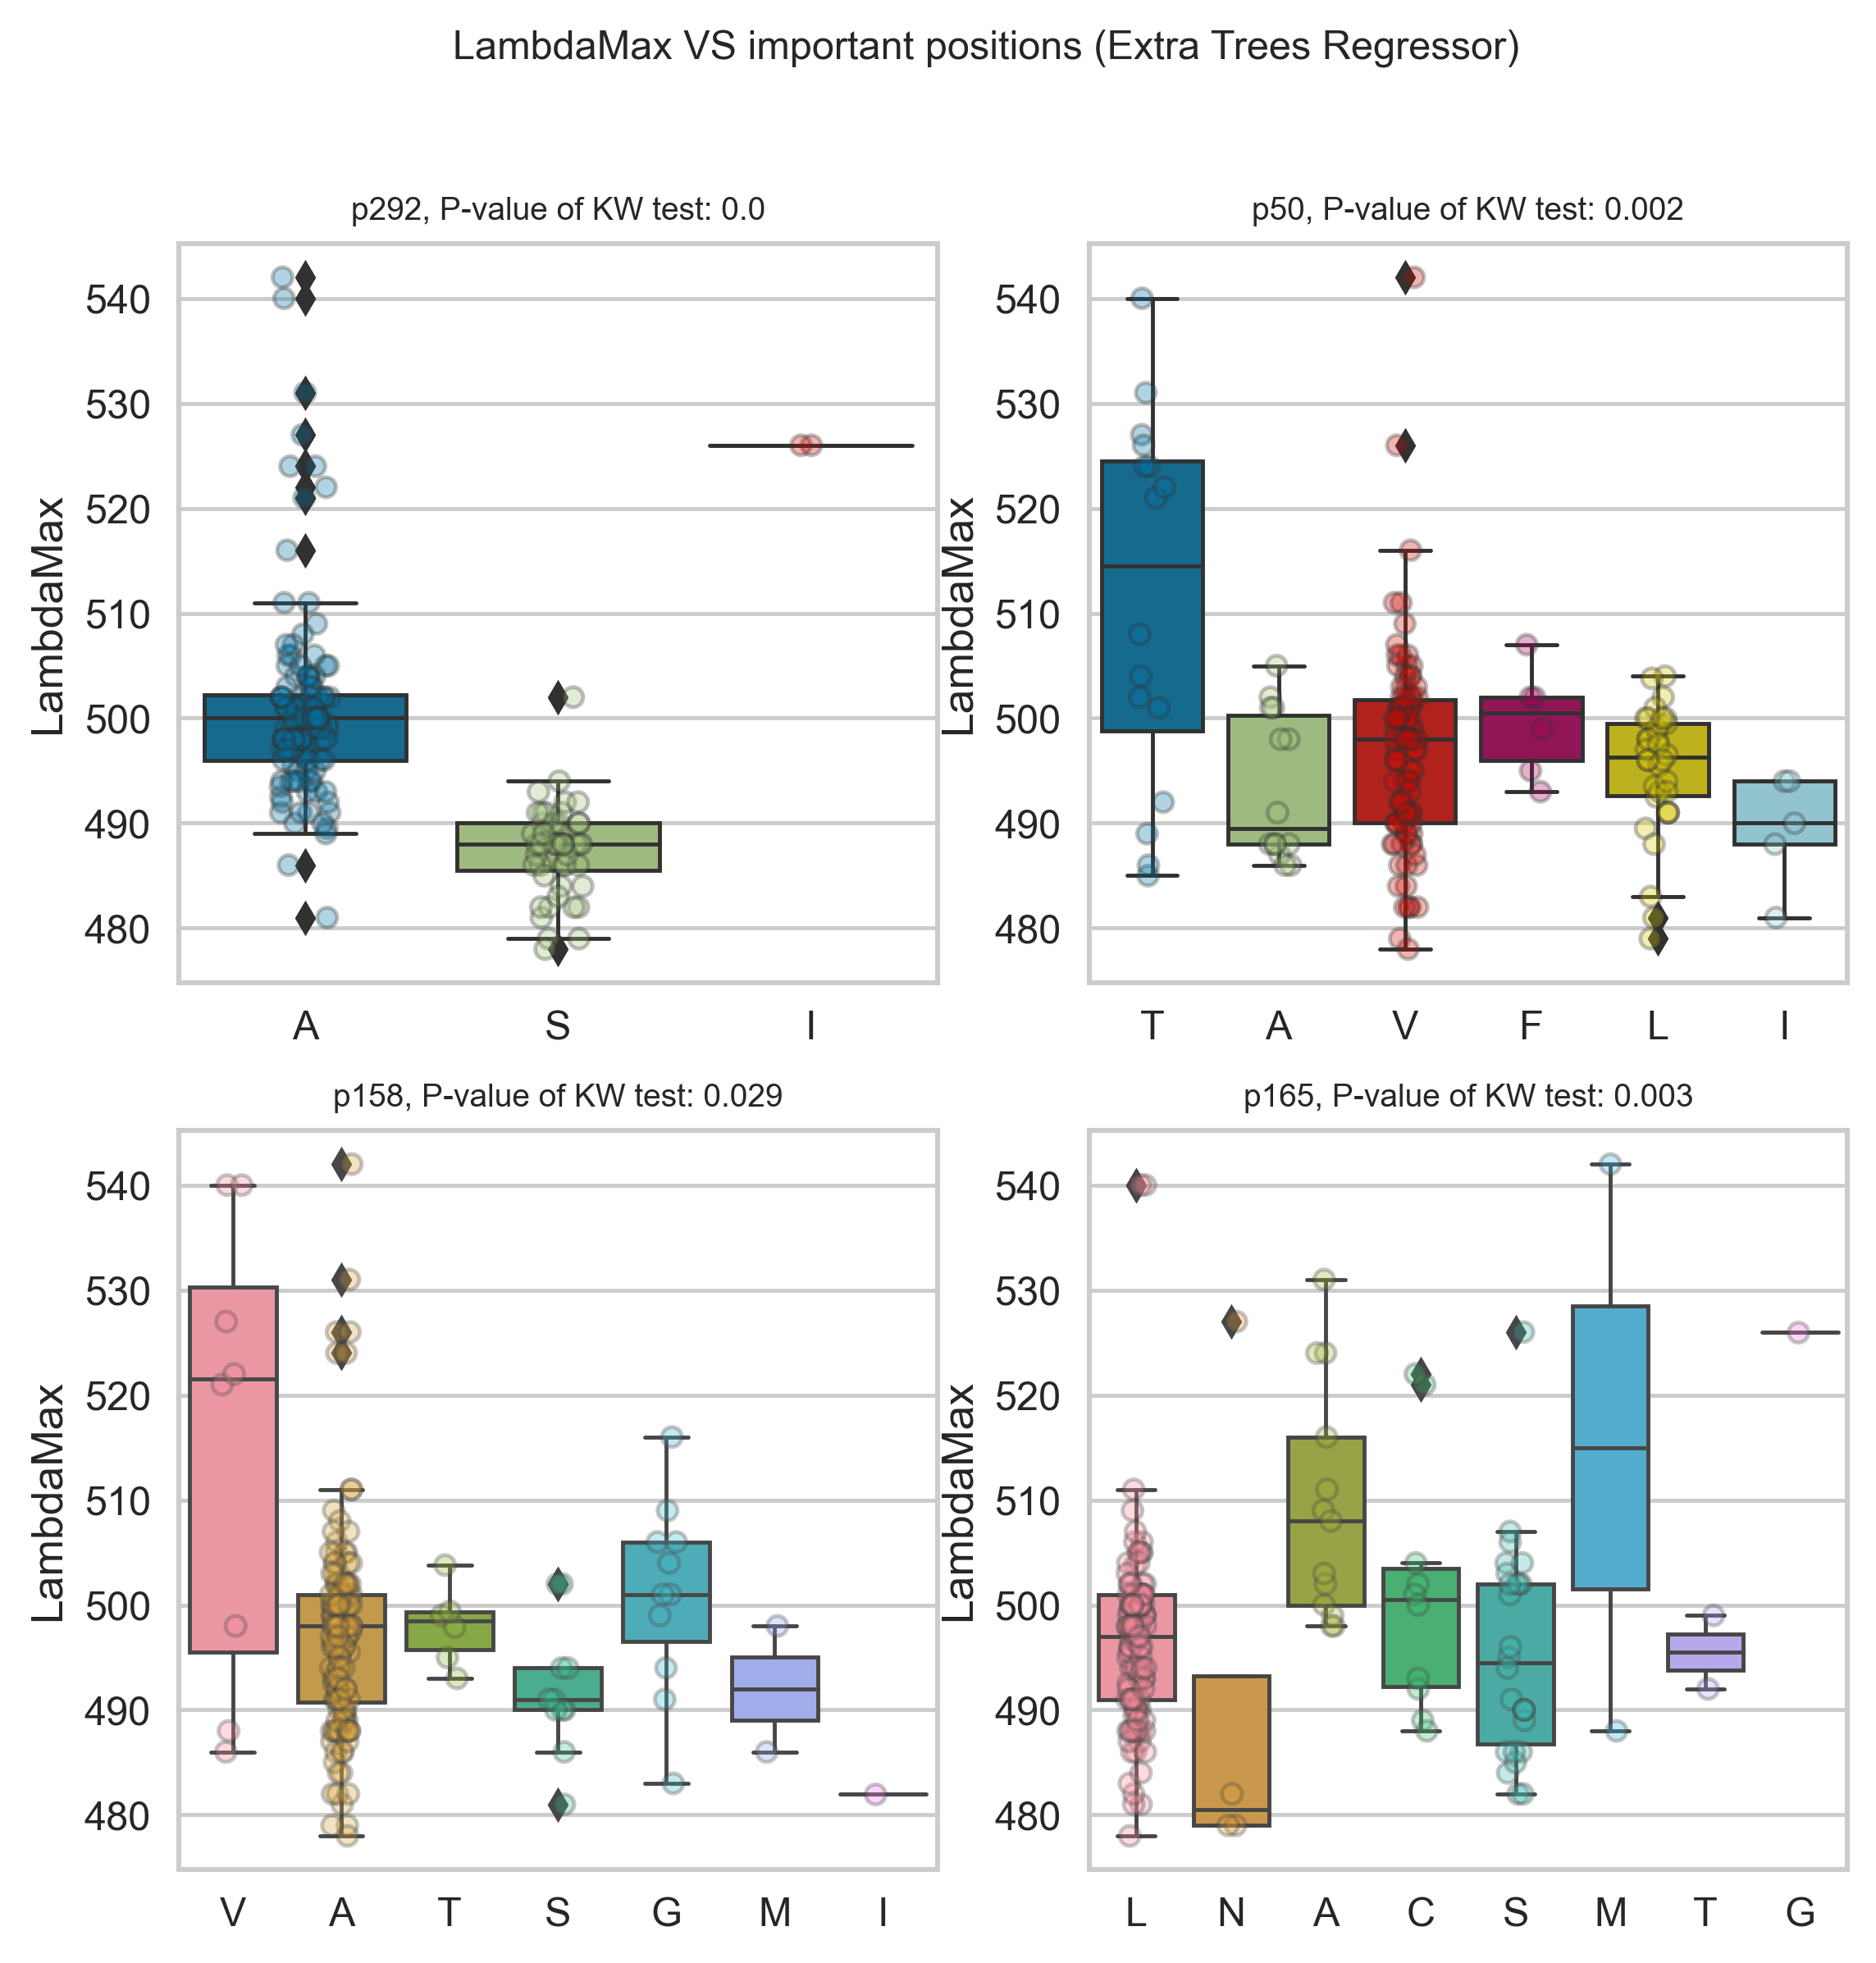

In [19]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i], 
                  train_cols=train_cols, grouped_features=dc_df,
                  n_positions=df.shape[1],report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the lollipop plot for features based on each model
    viz.plot_imp_model(dat =df, trained_model = top_models[i], model_name = model_names[i],
               train_cols= train_cols, grouped_features = dc_df,
                   meta_var = mt, n_positions = df.shape[1], model_type = anaType, report_dir = report_dir)

/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax_LambdaMax_2022-07-10_22-38-08/mean_350.png


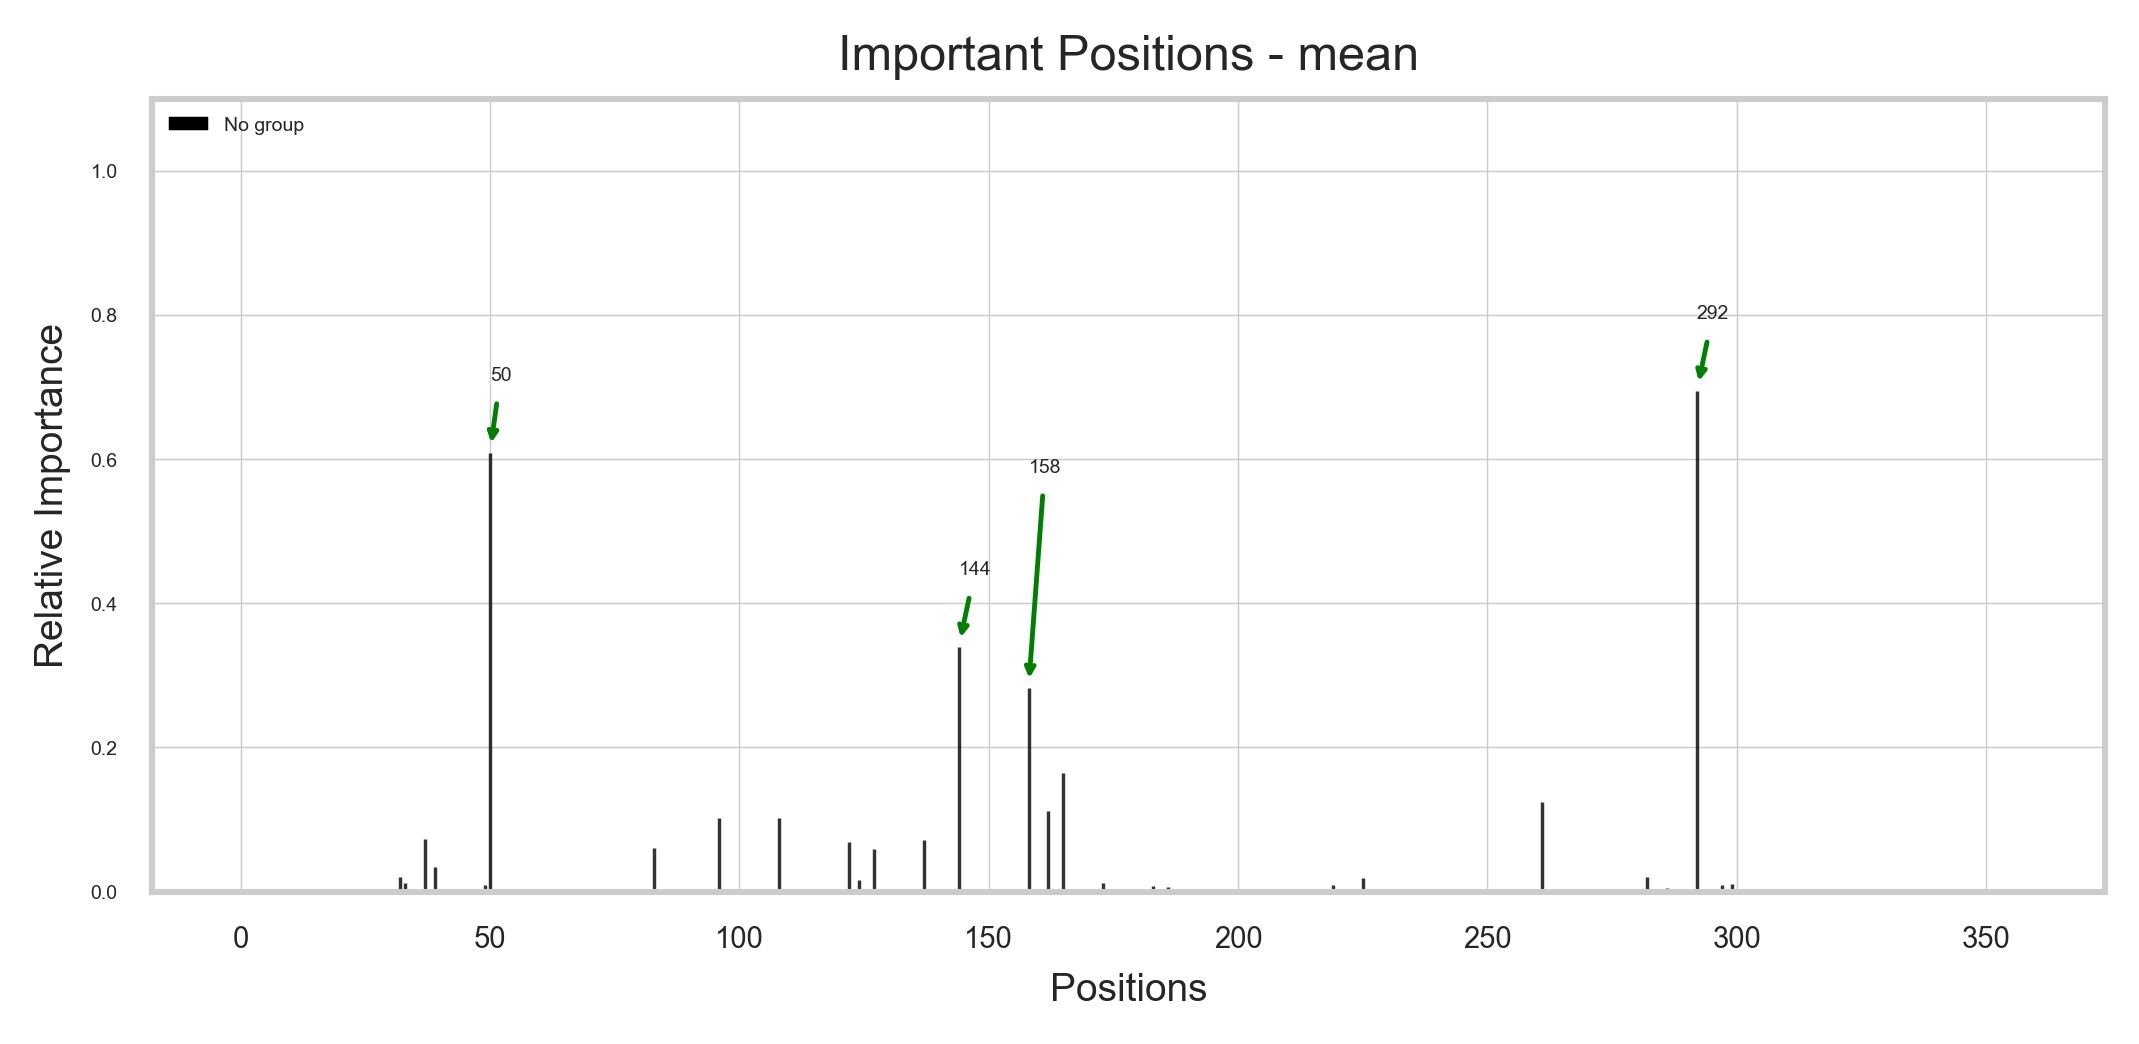

In [20]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc_df,
                              n_positions=df.shape[1],report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat = mean_imp, model_name= 'mean',imp_col='mean_imp', report_dir=report_dir)

Model  0  Done
Model  1  Done
Model  2  Done


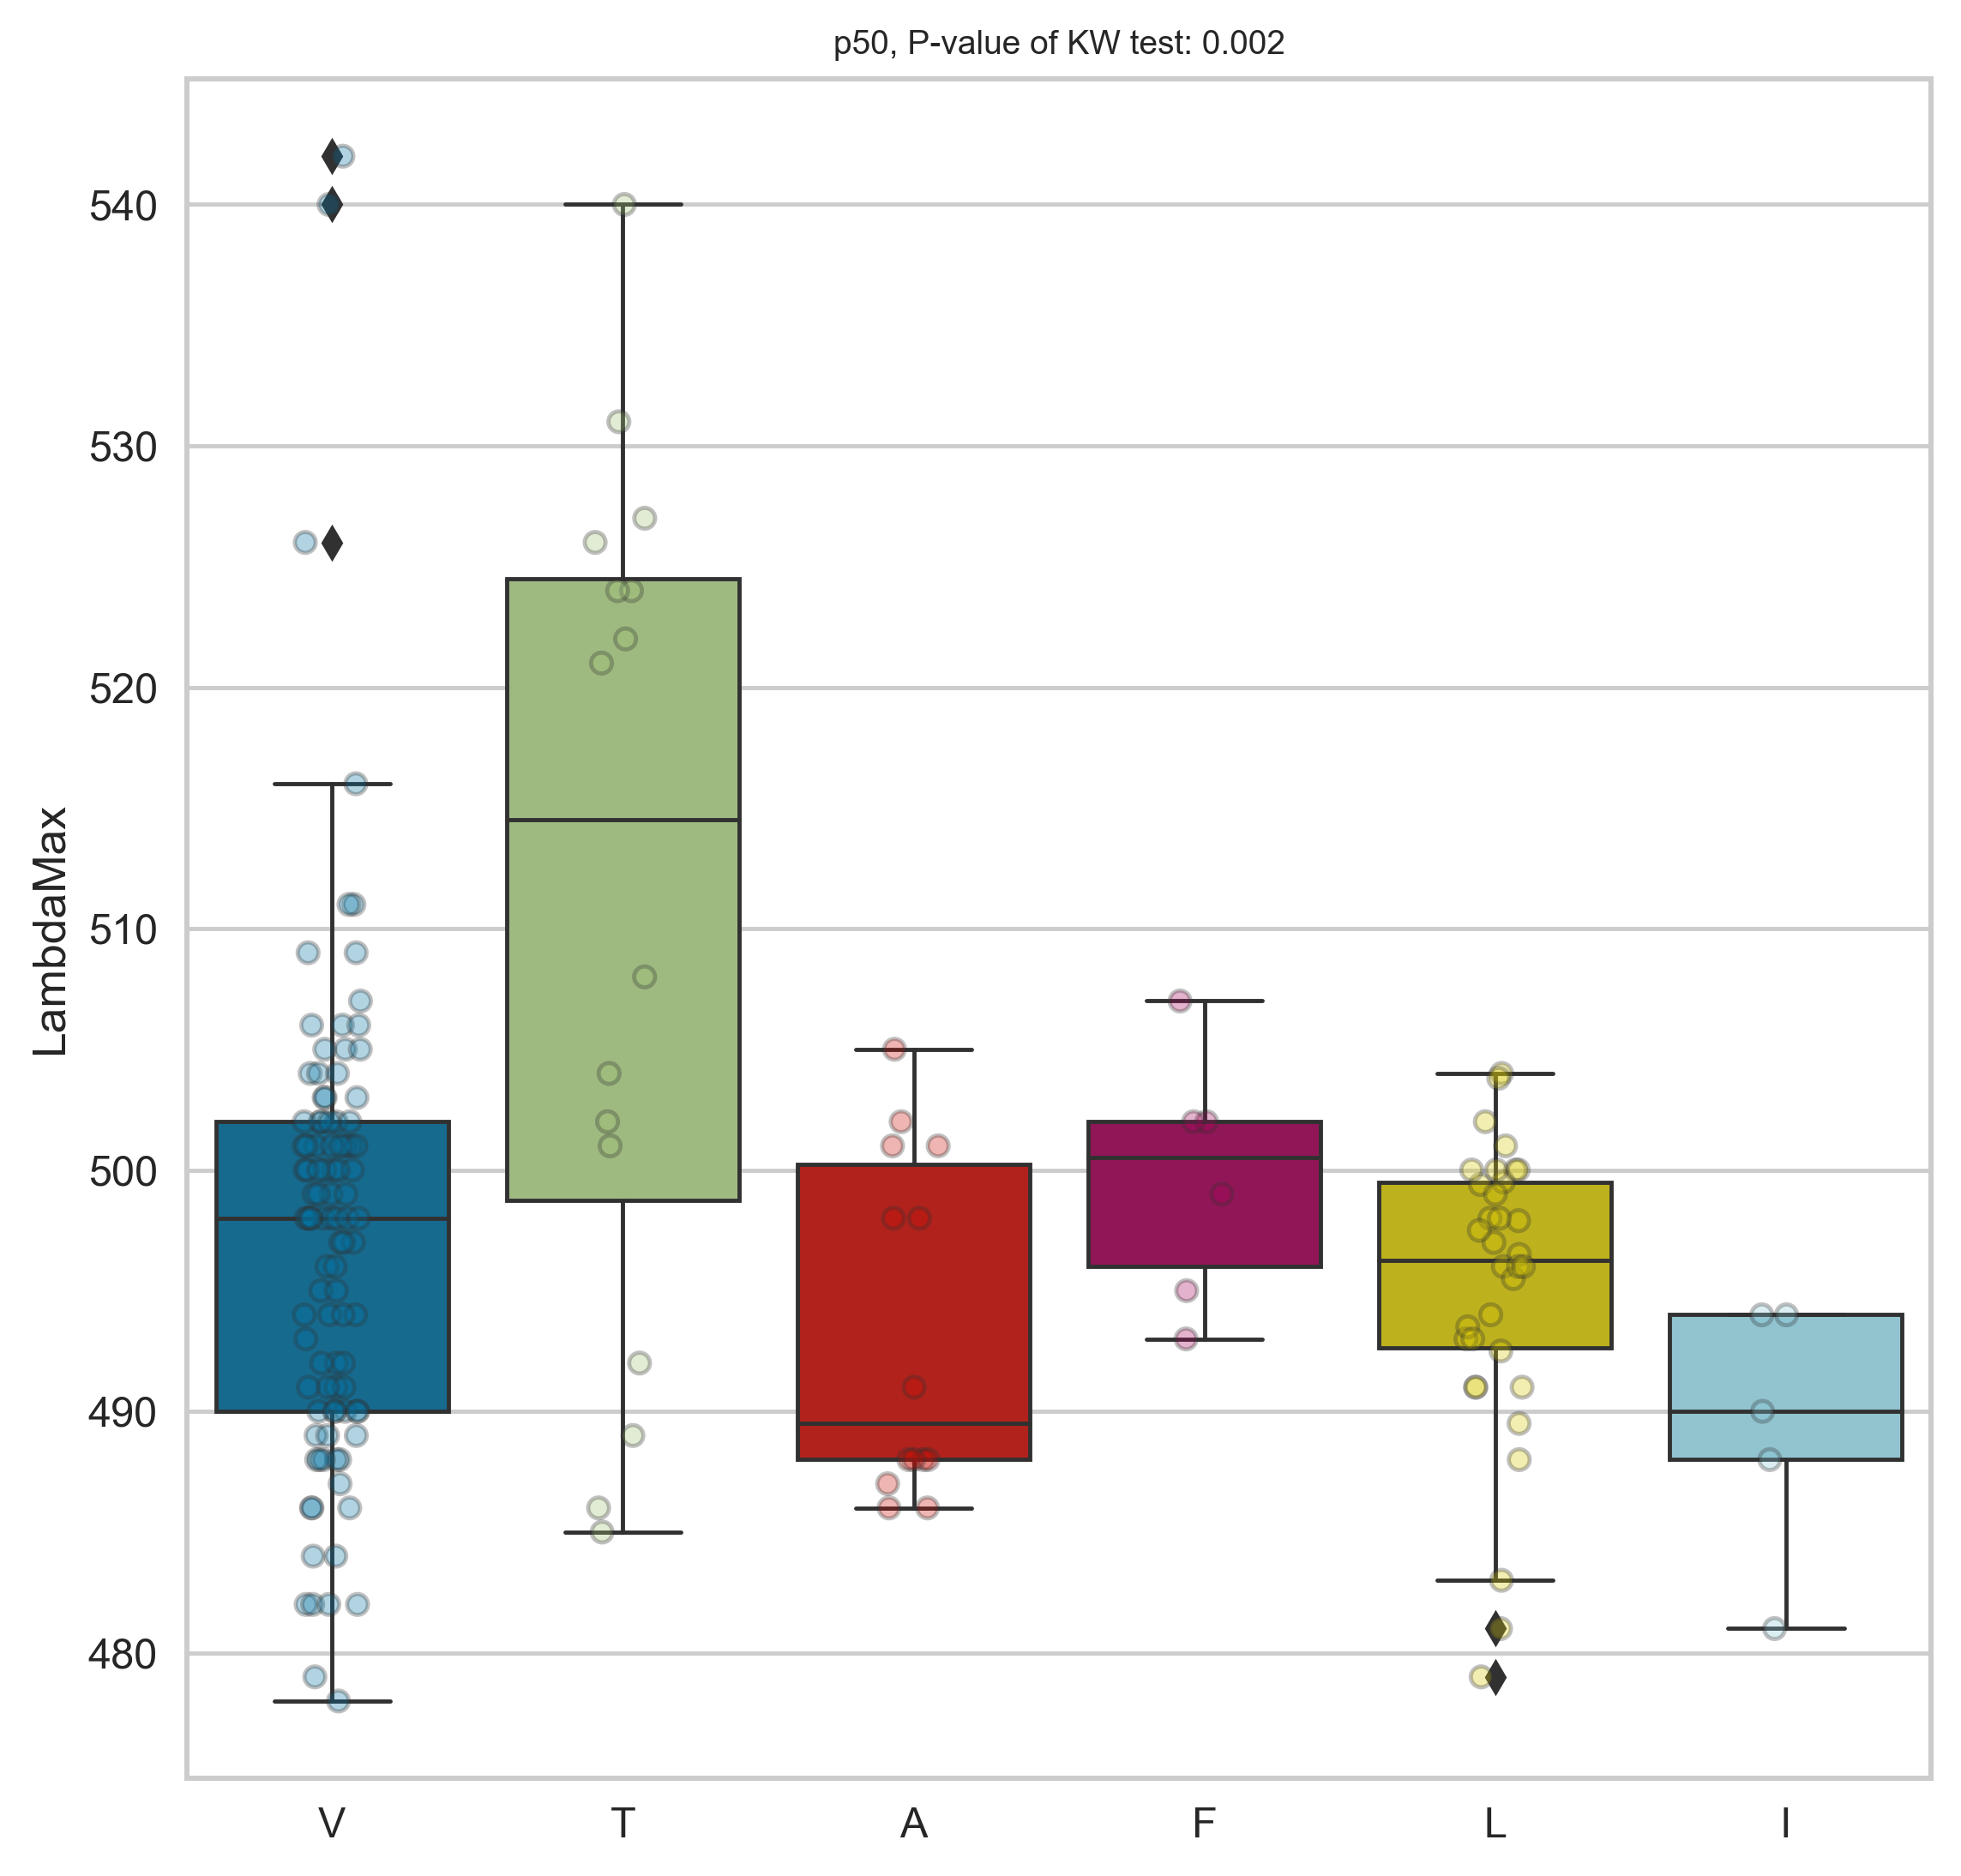

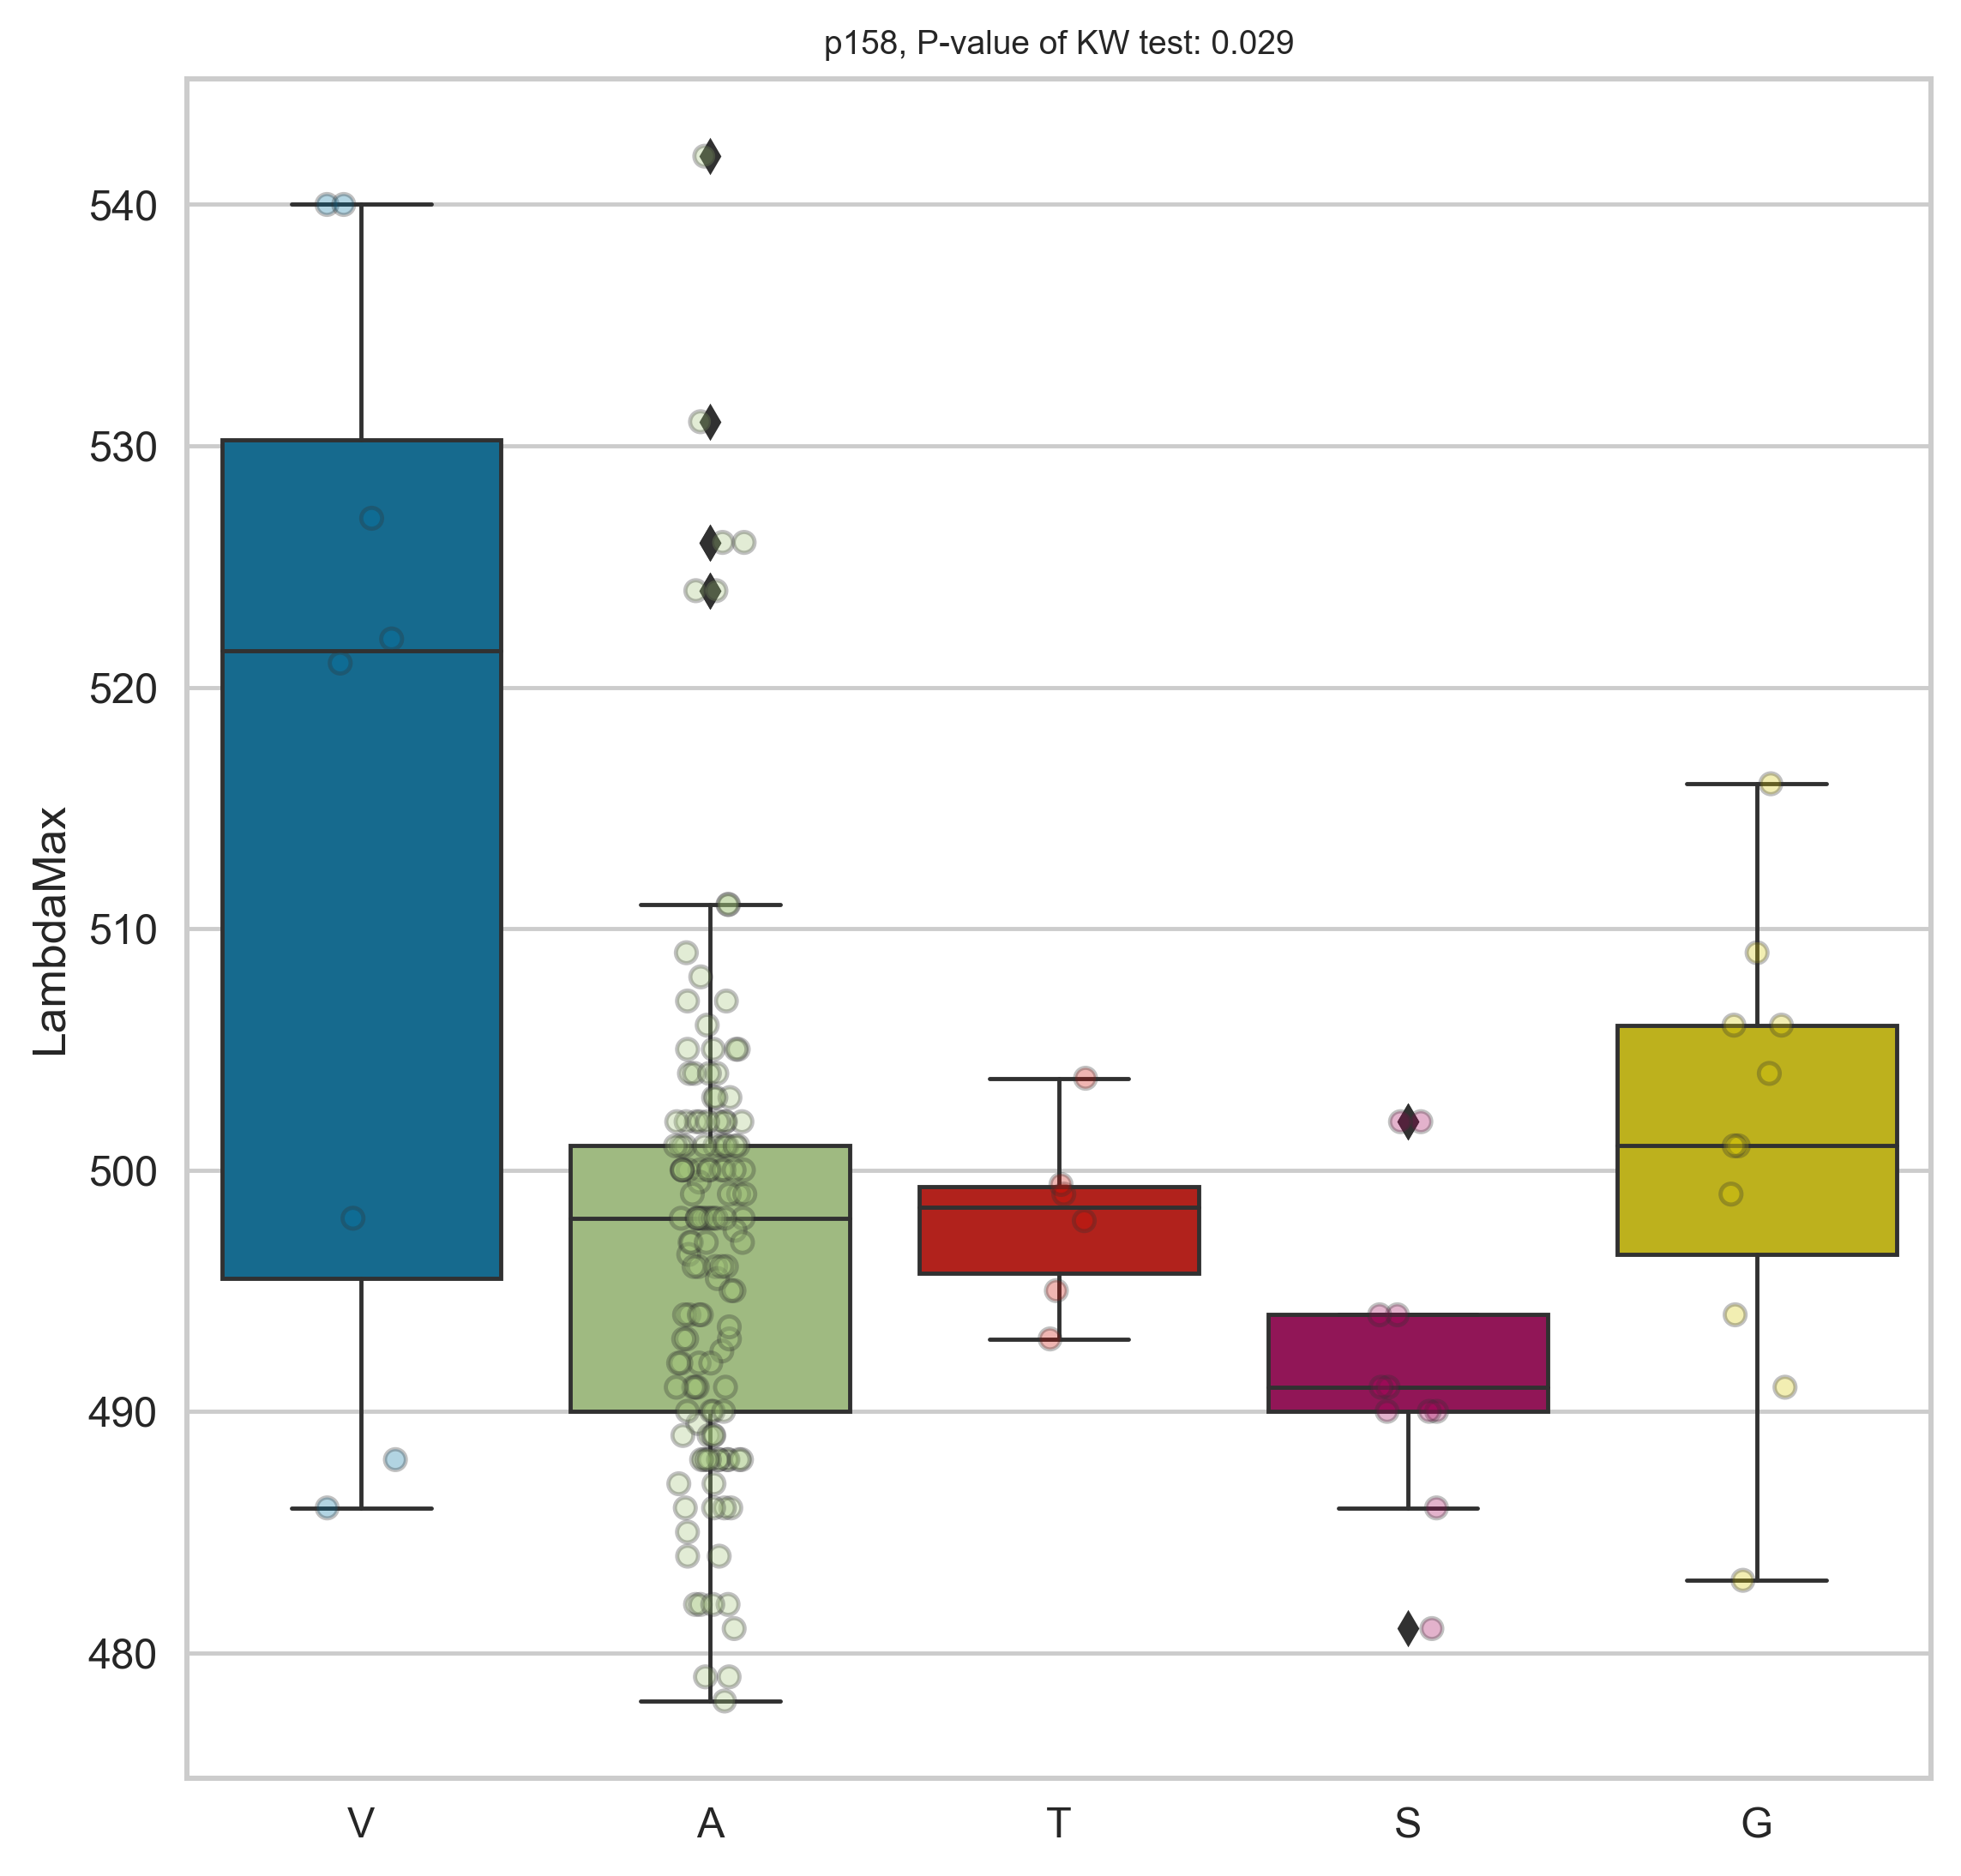

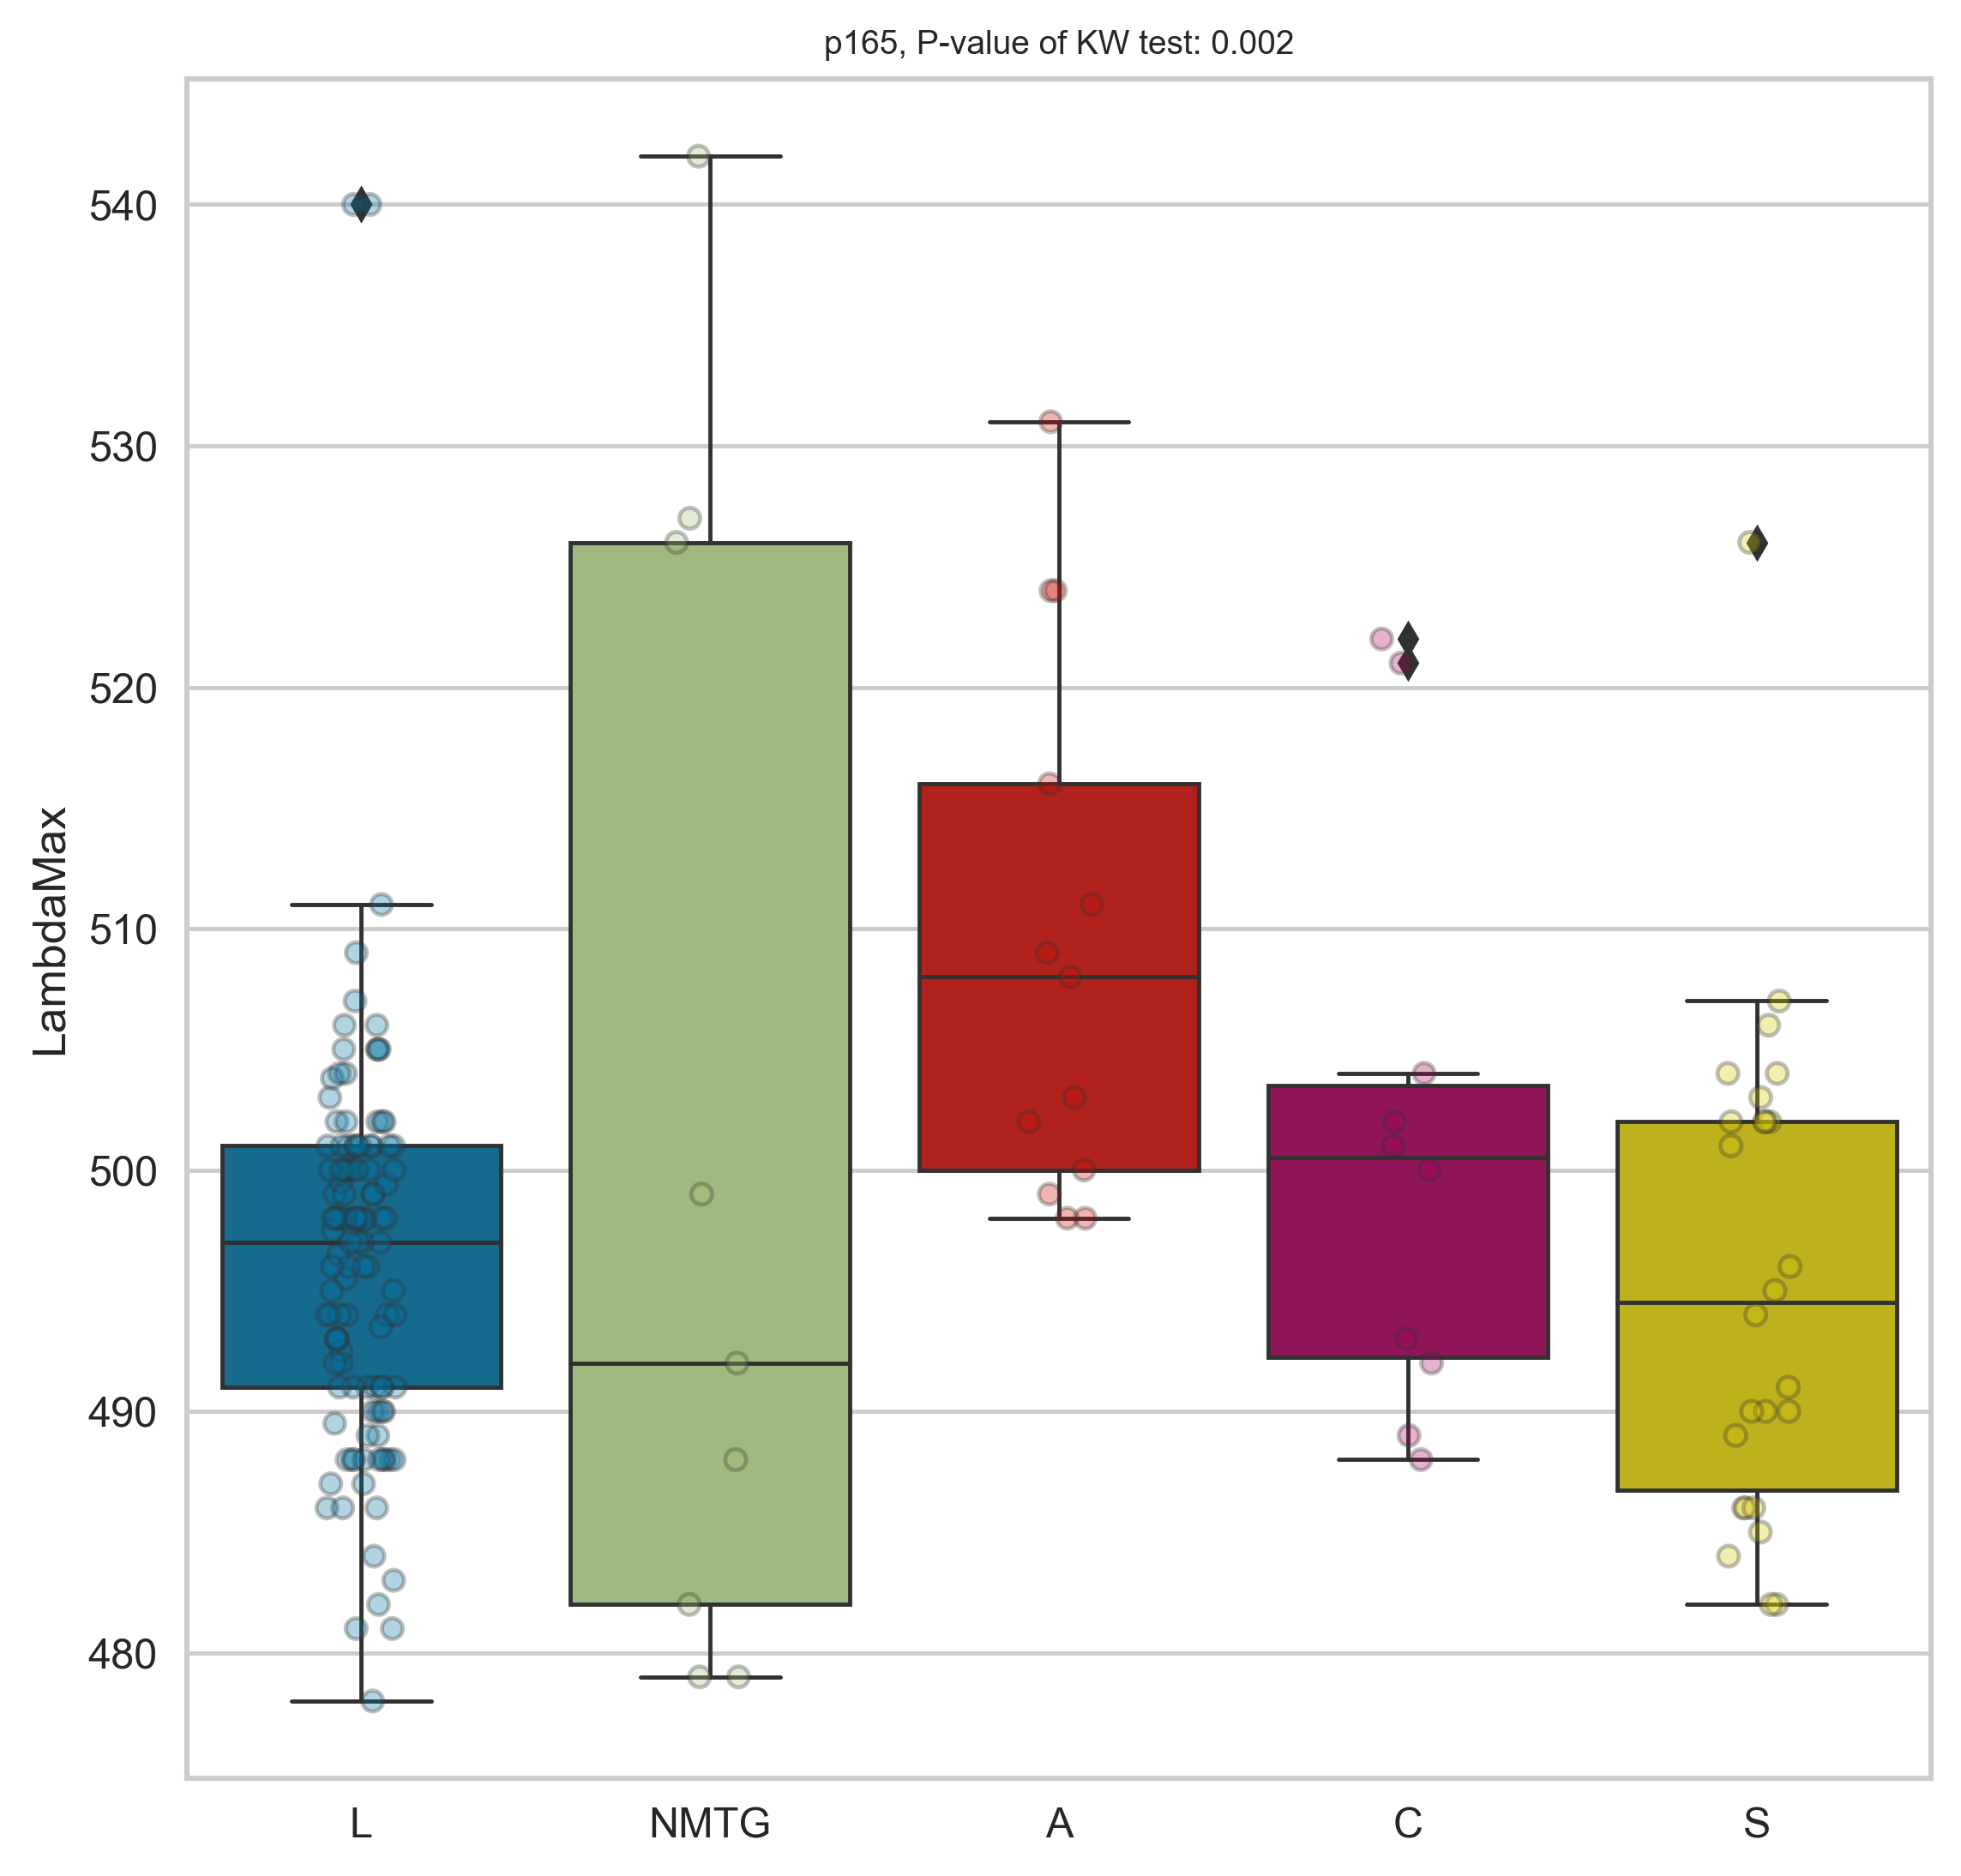

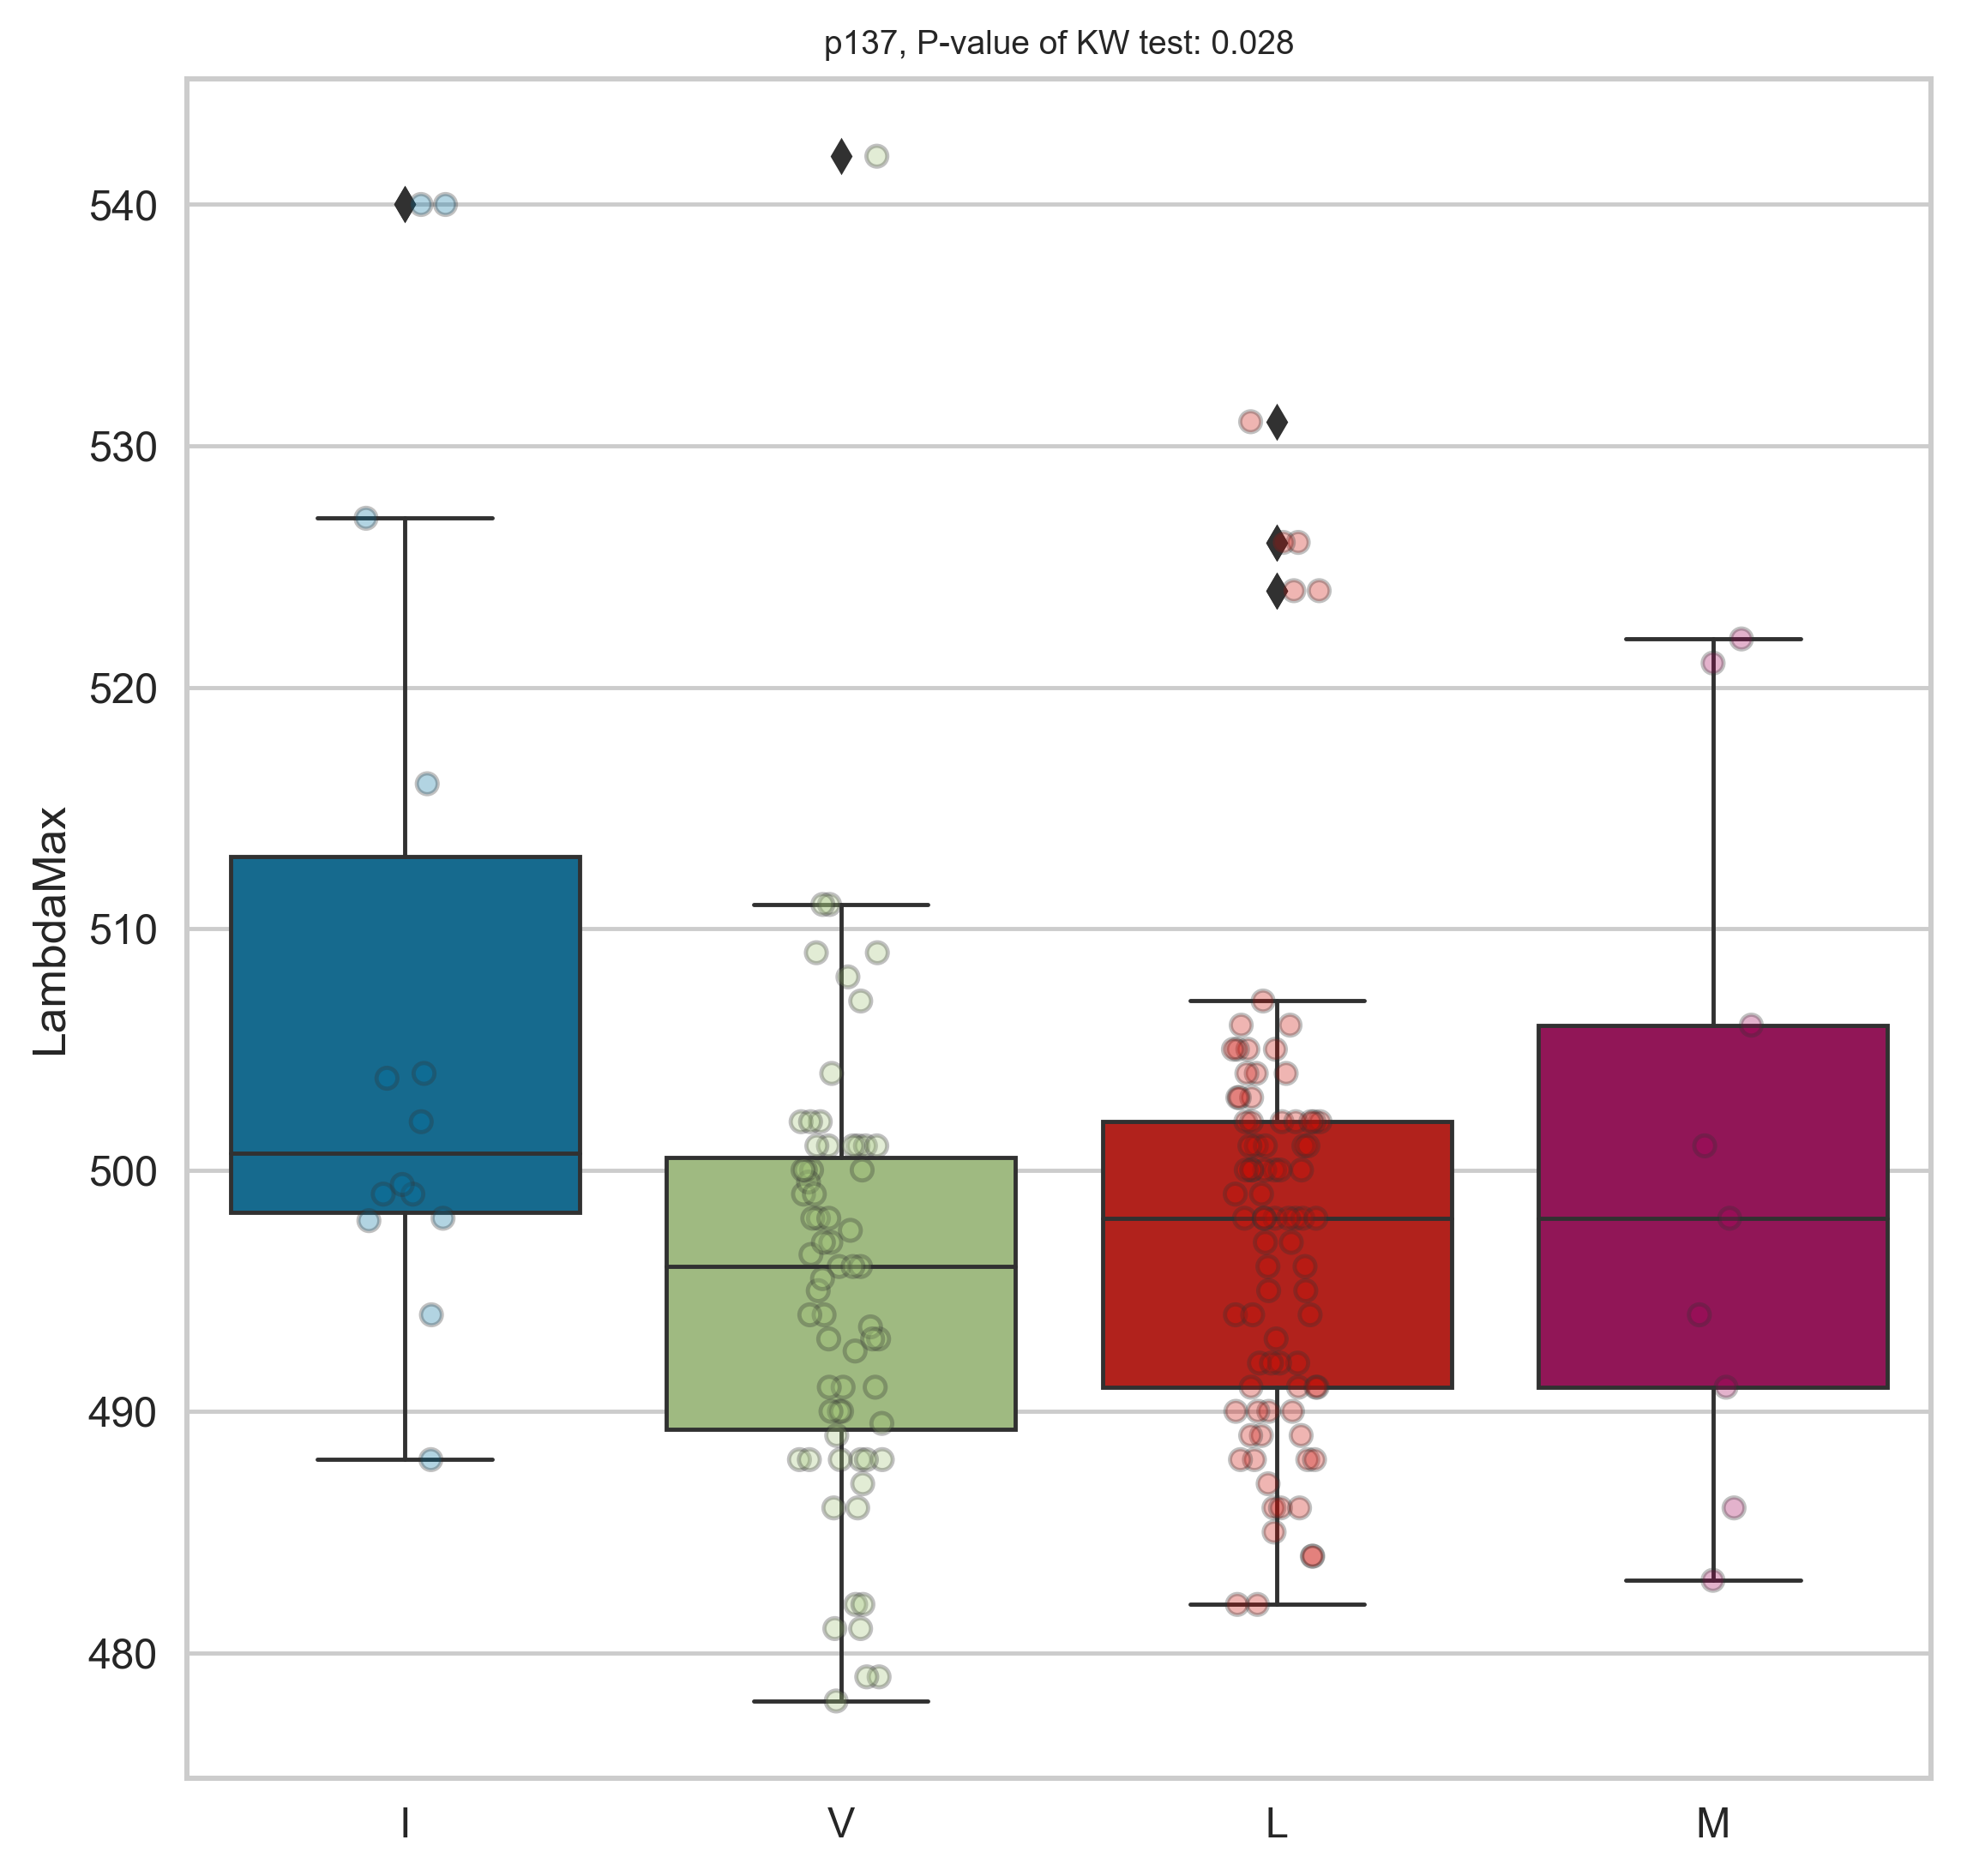

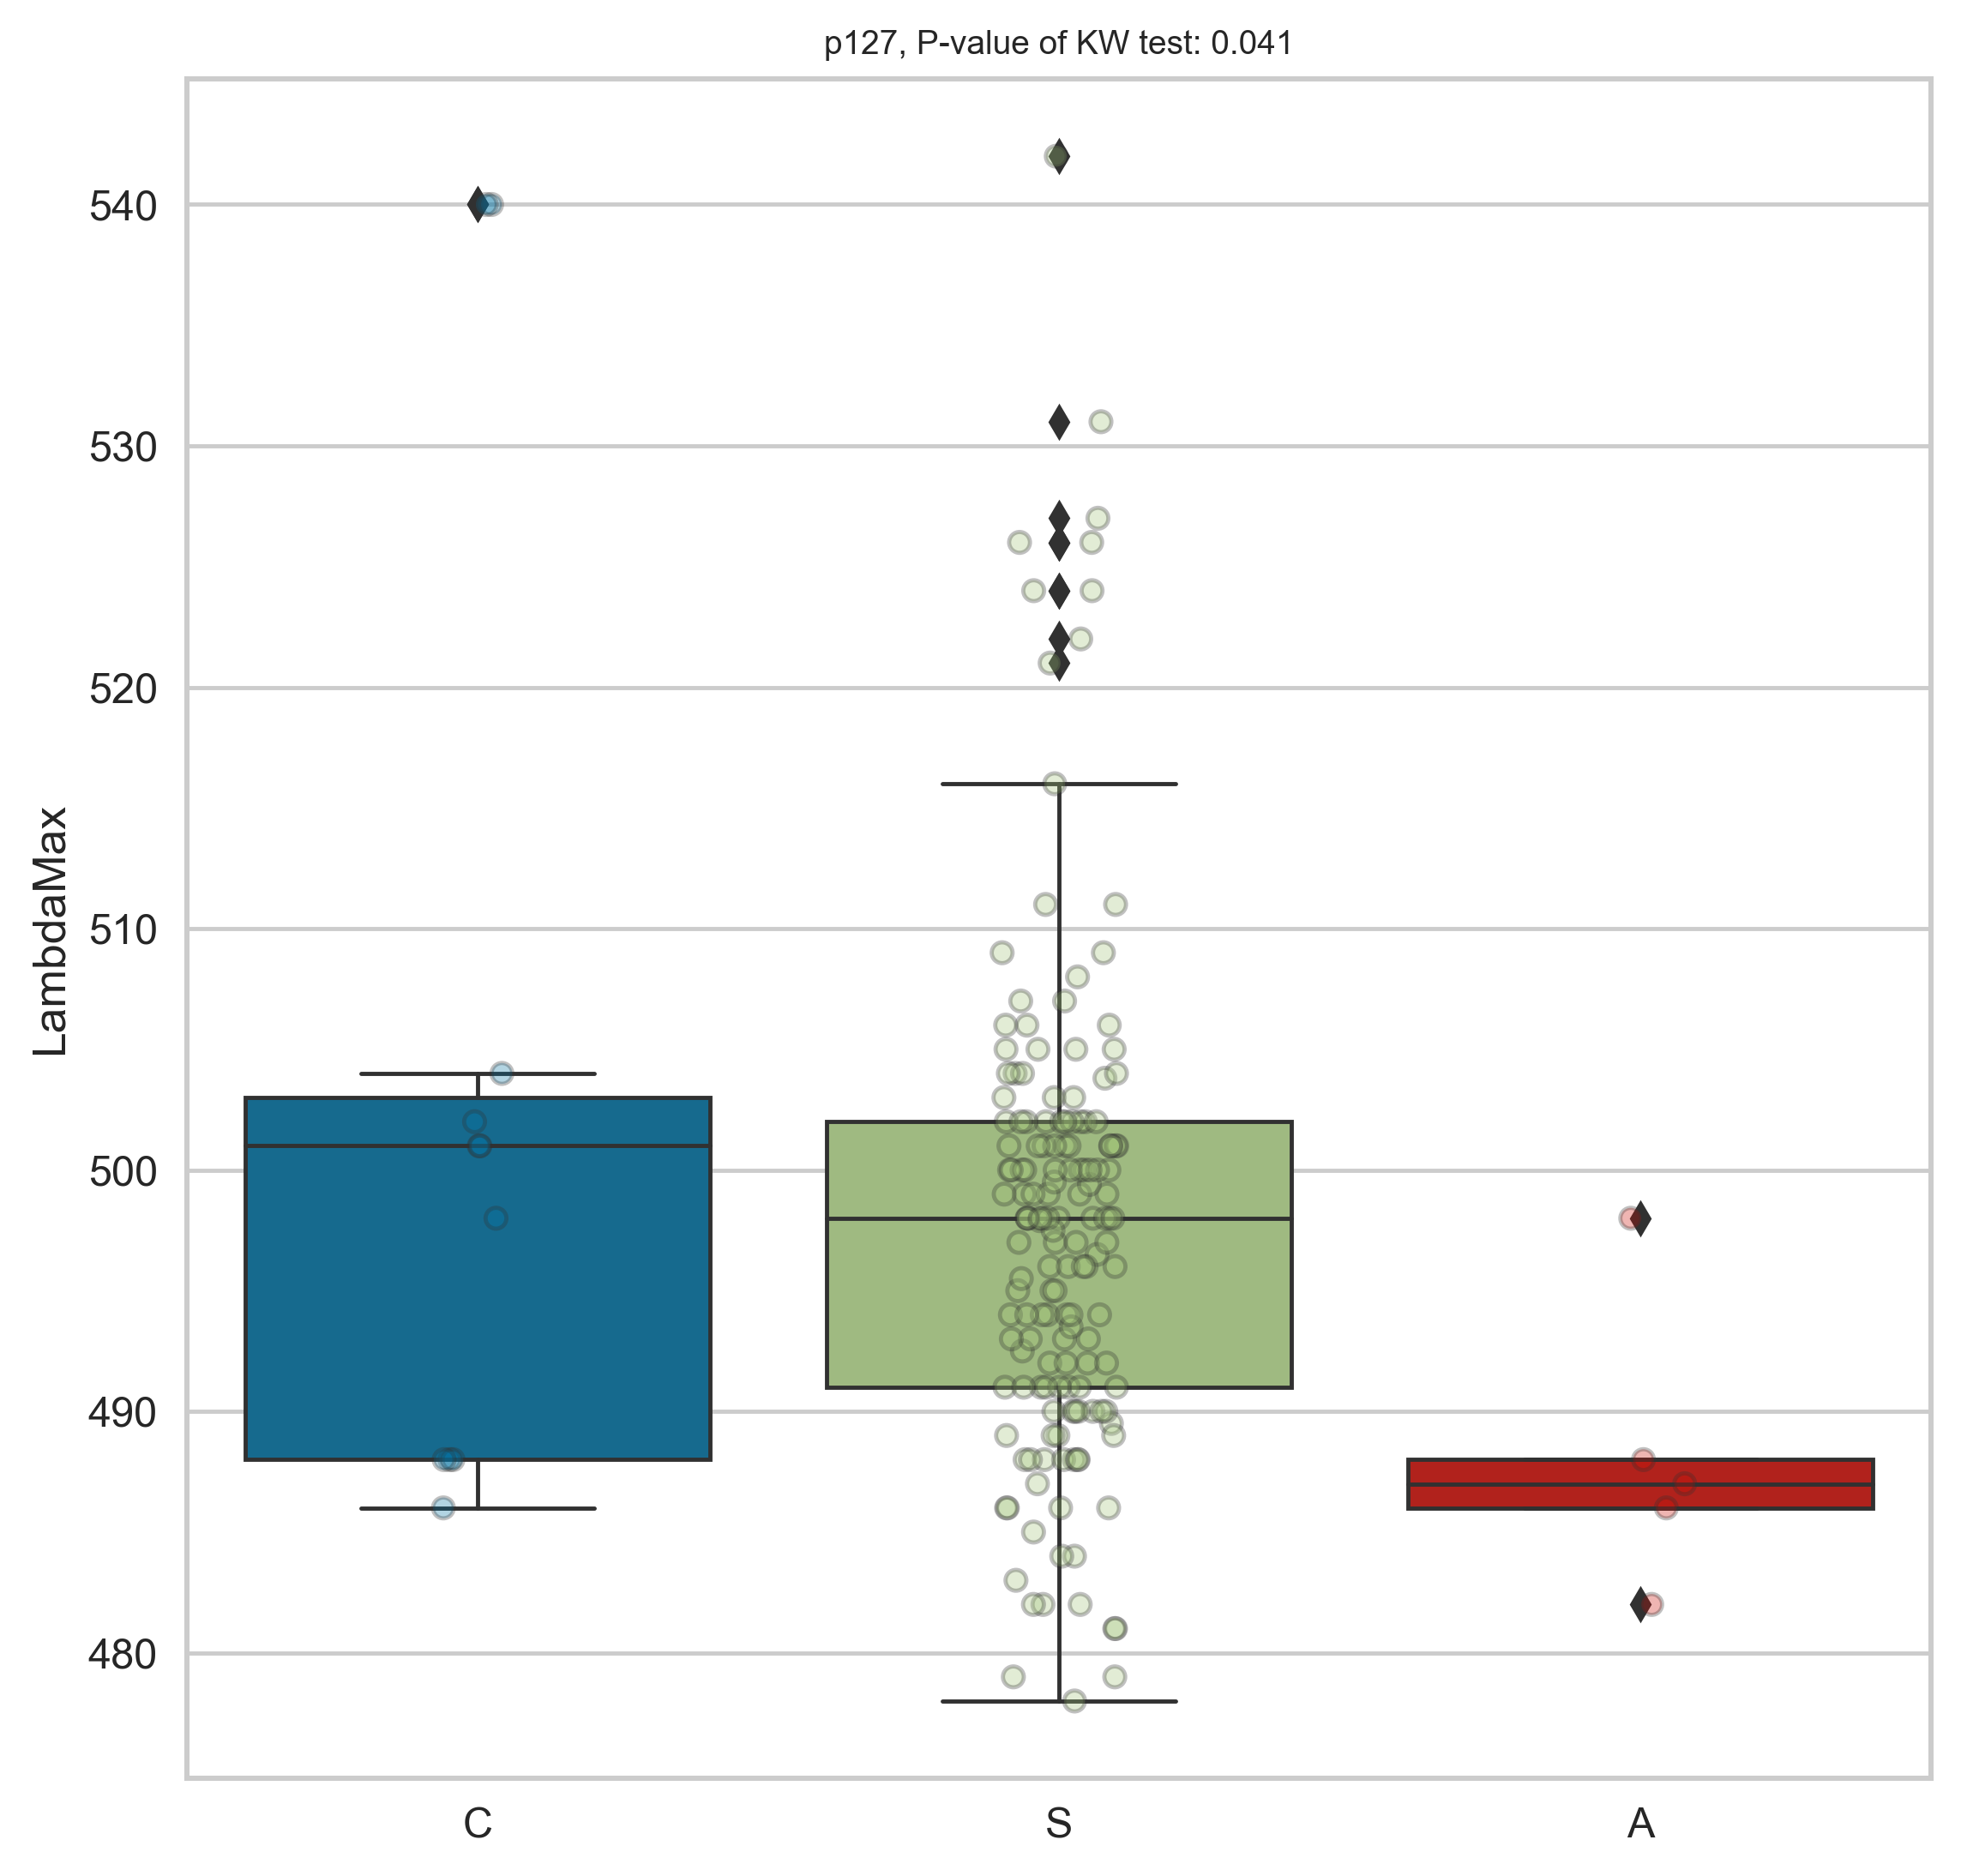

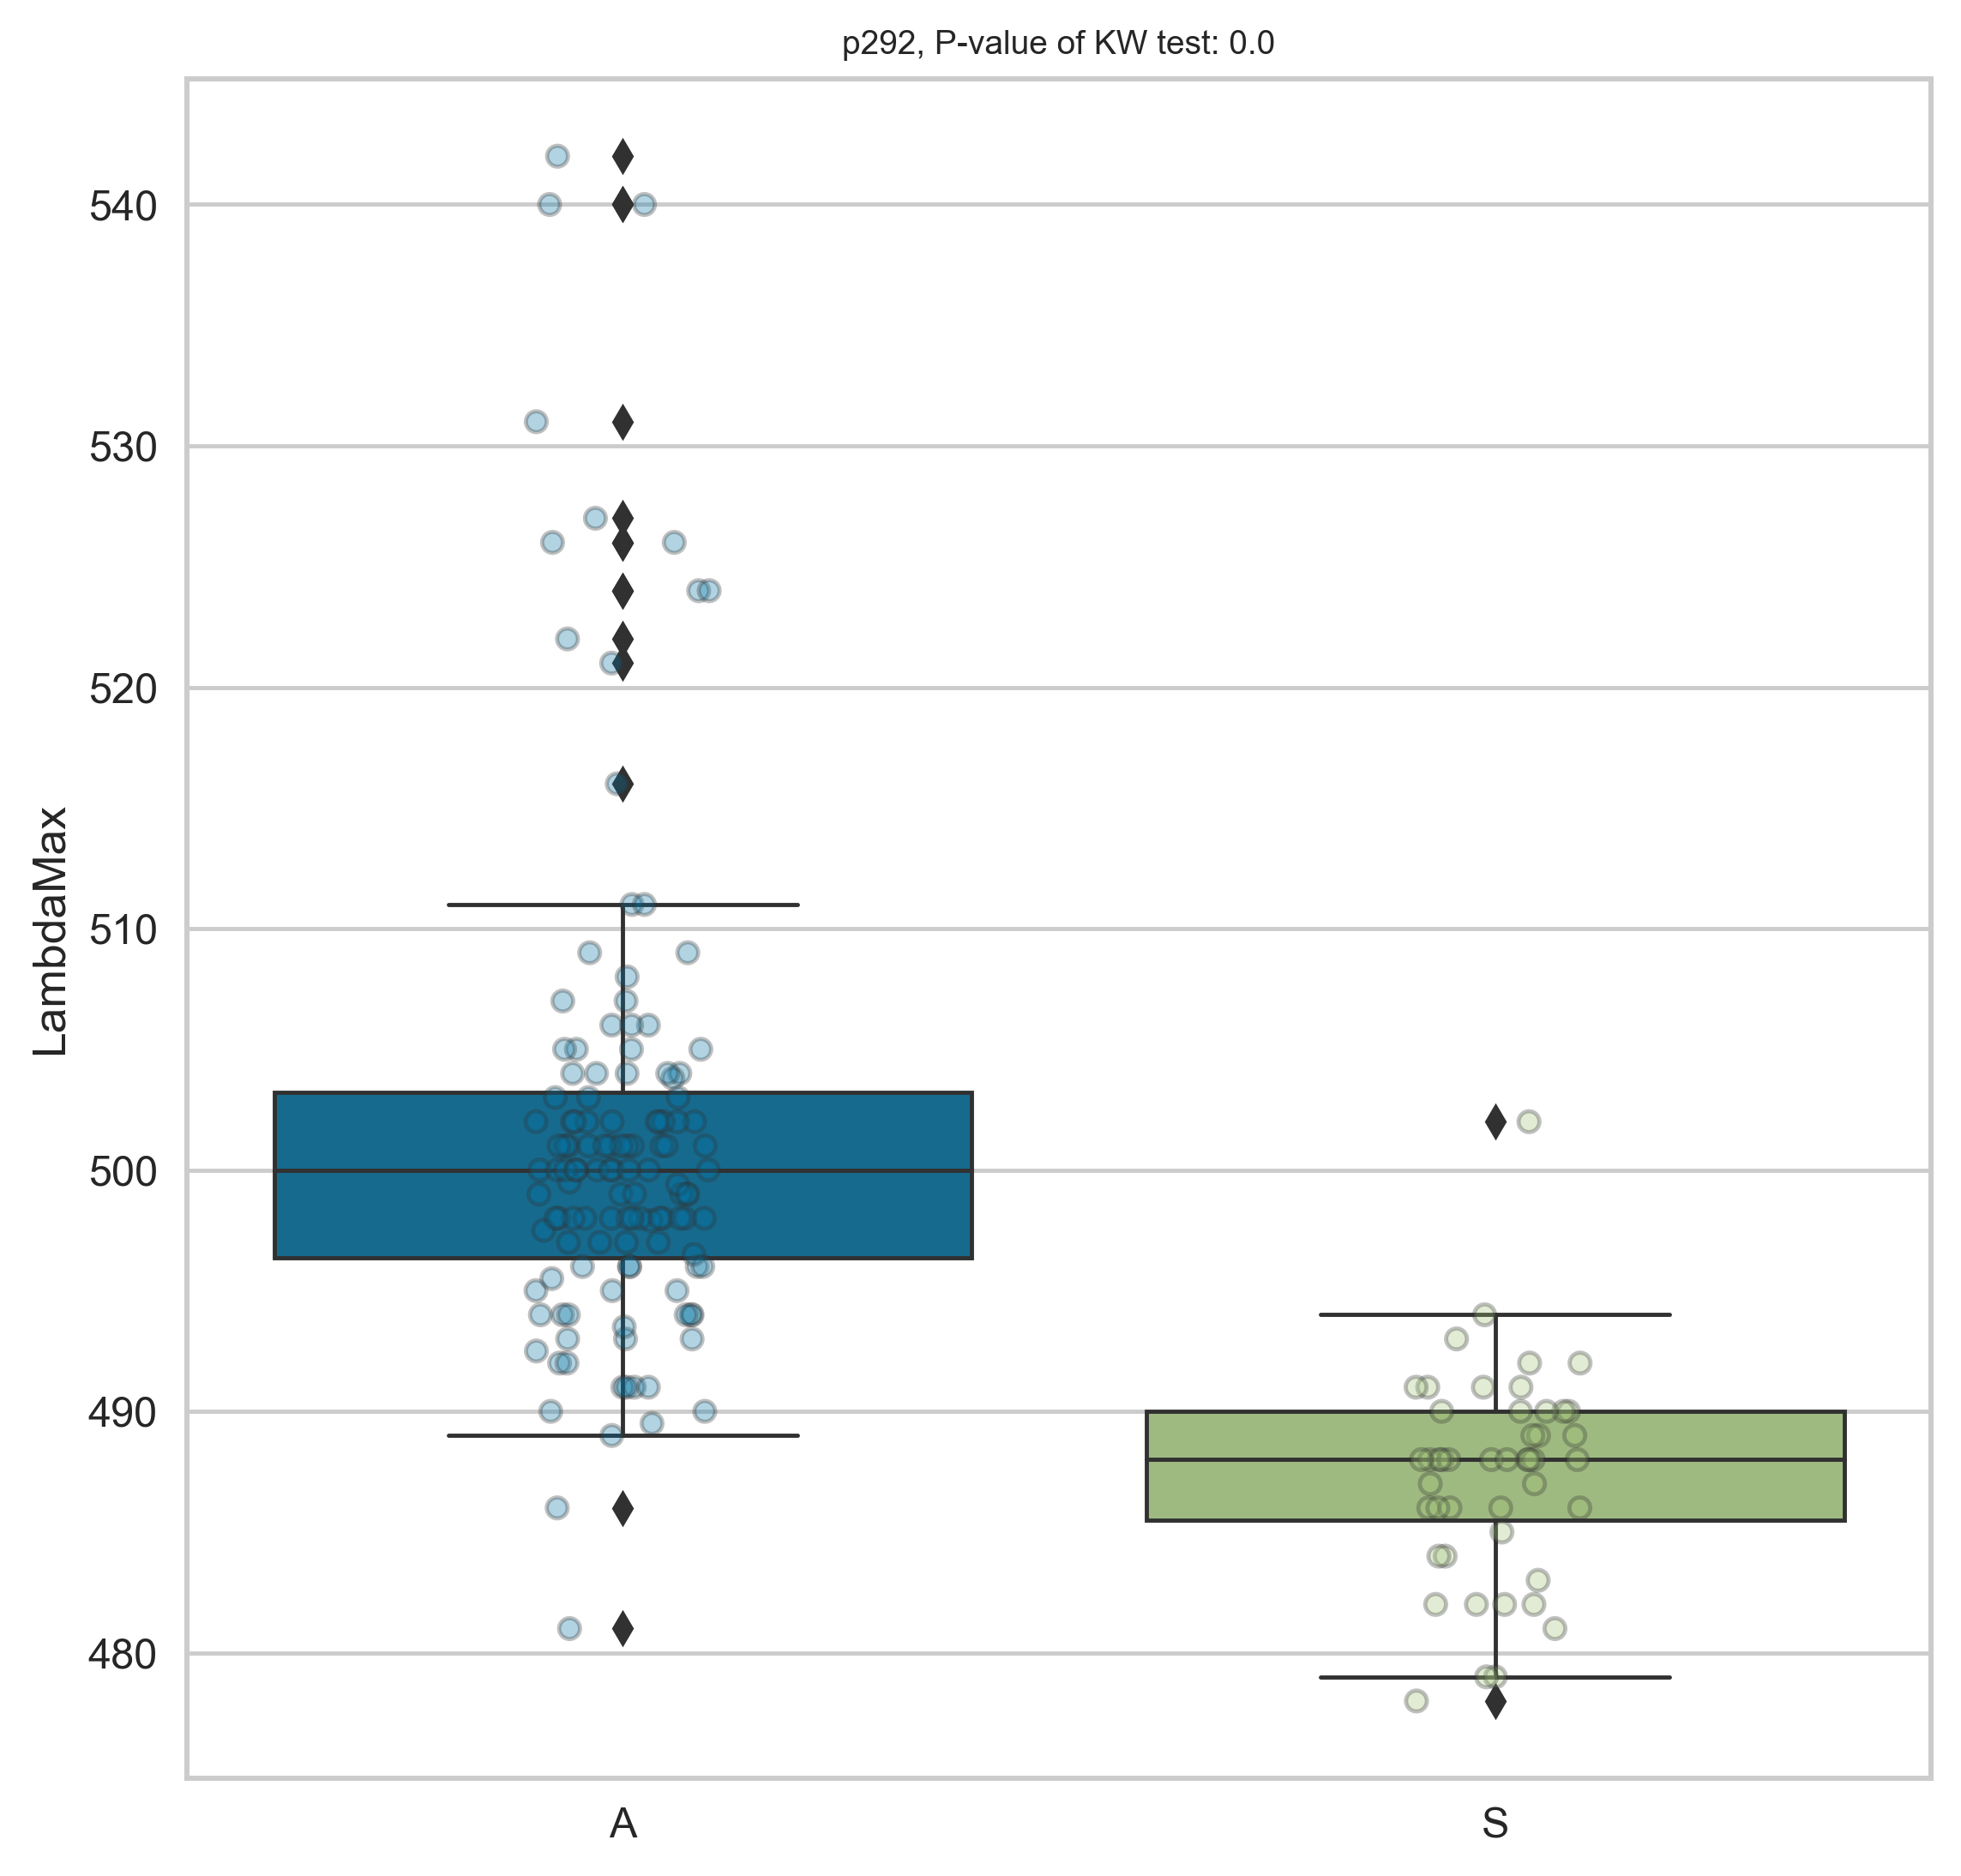

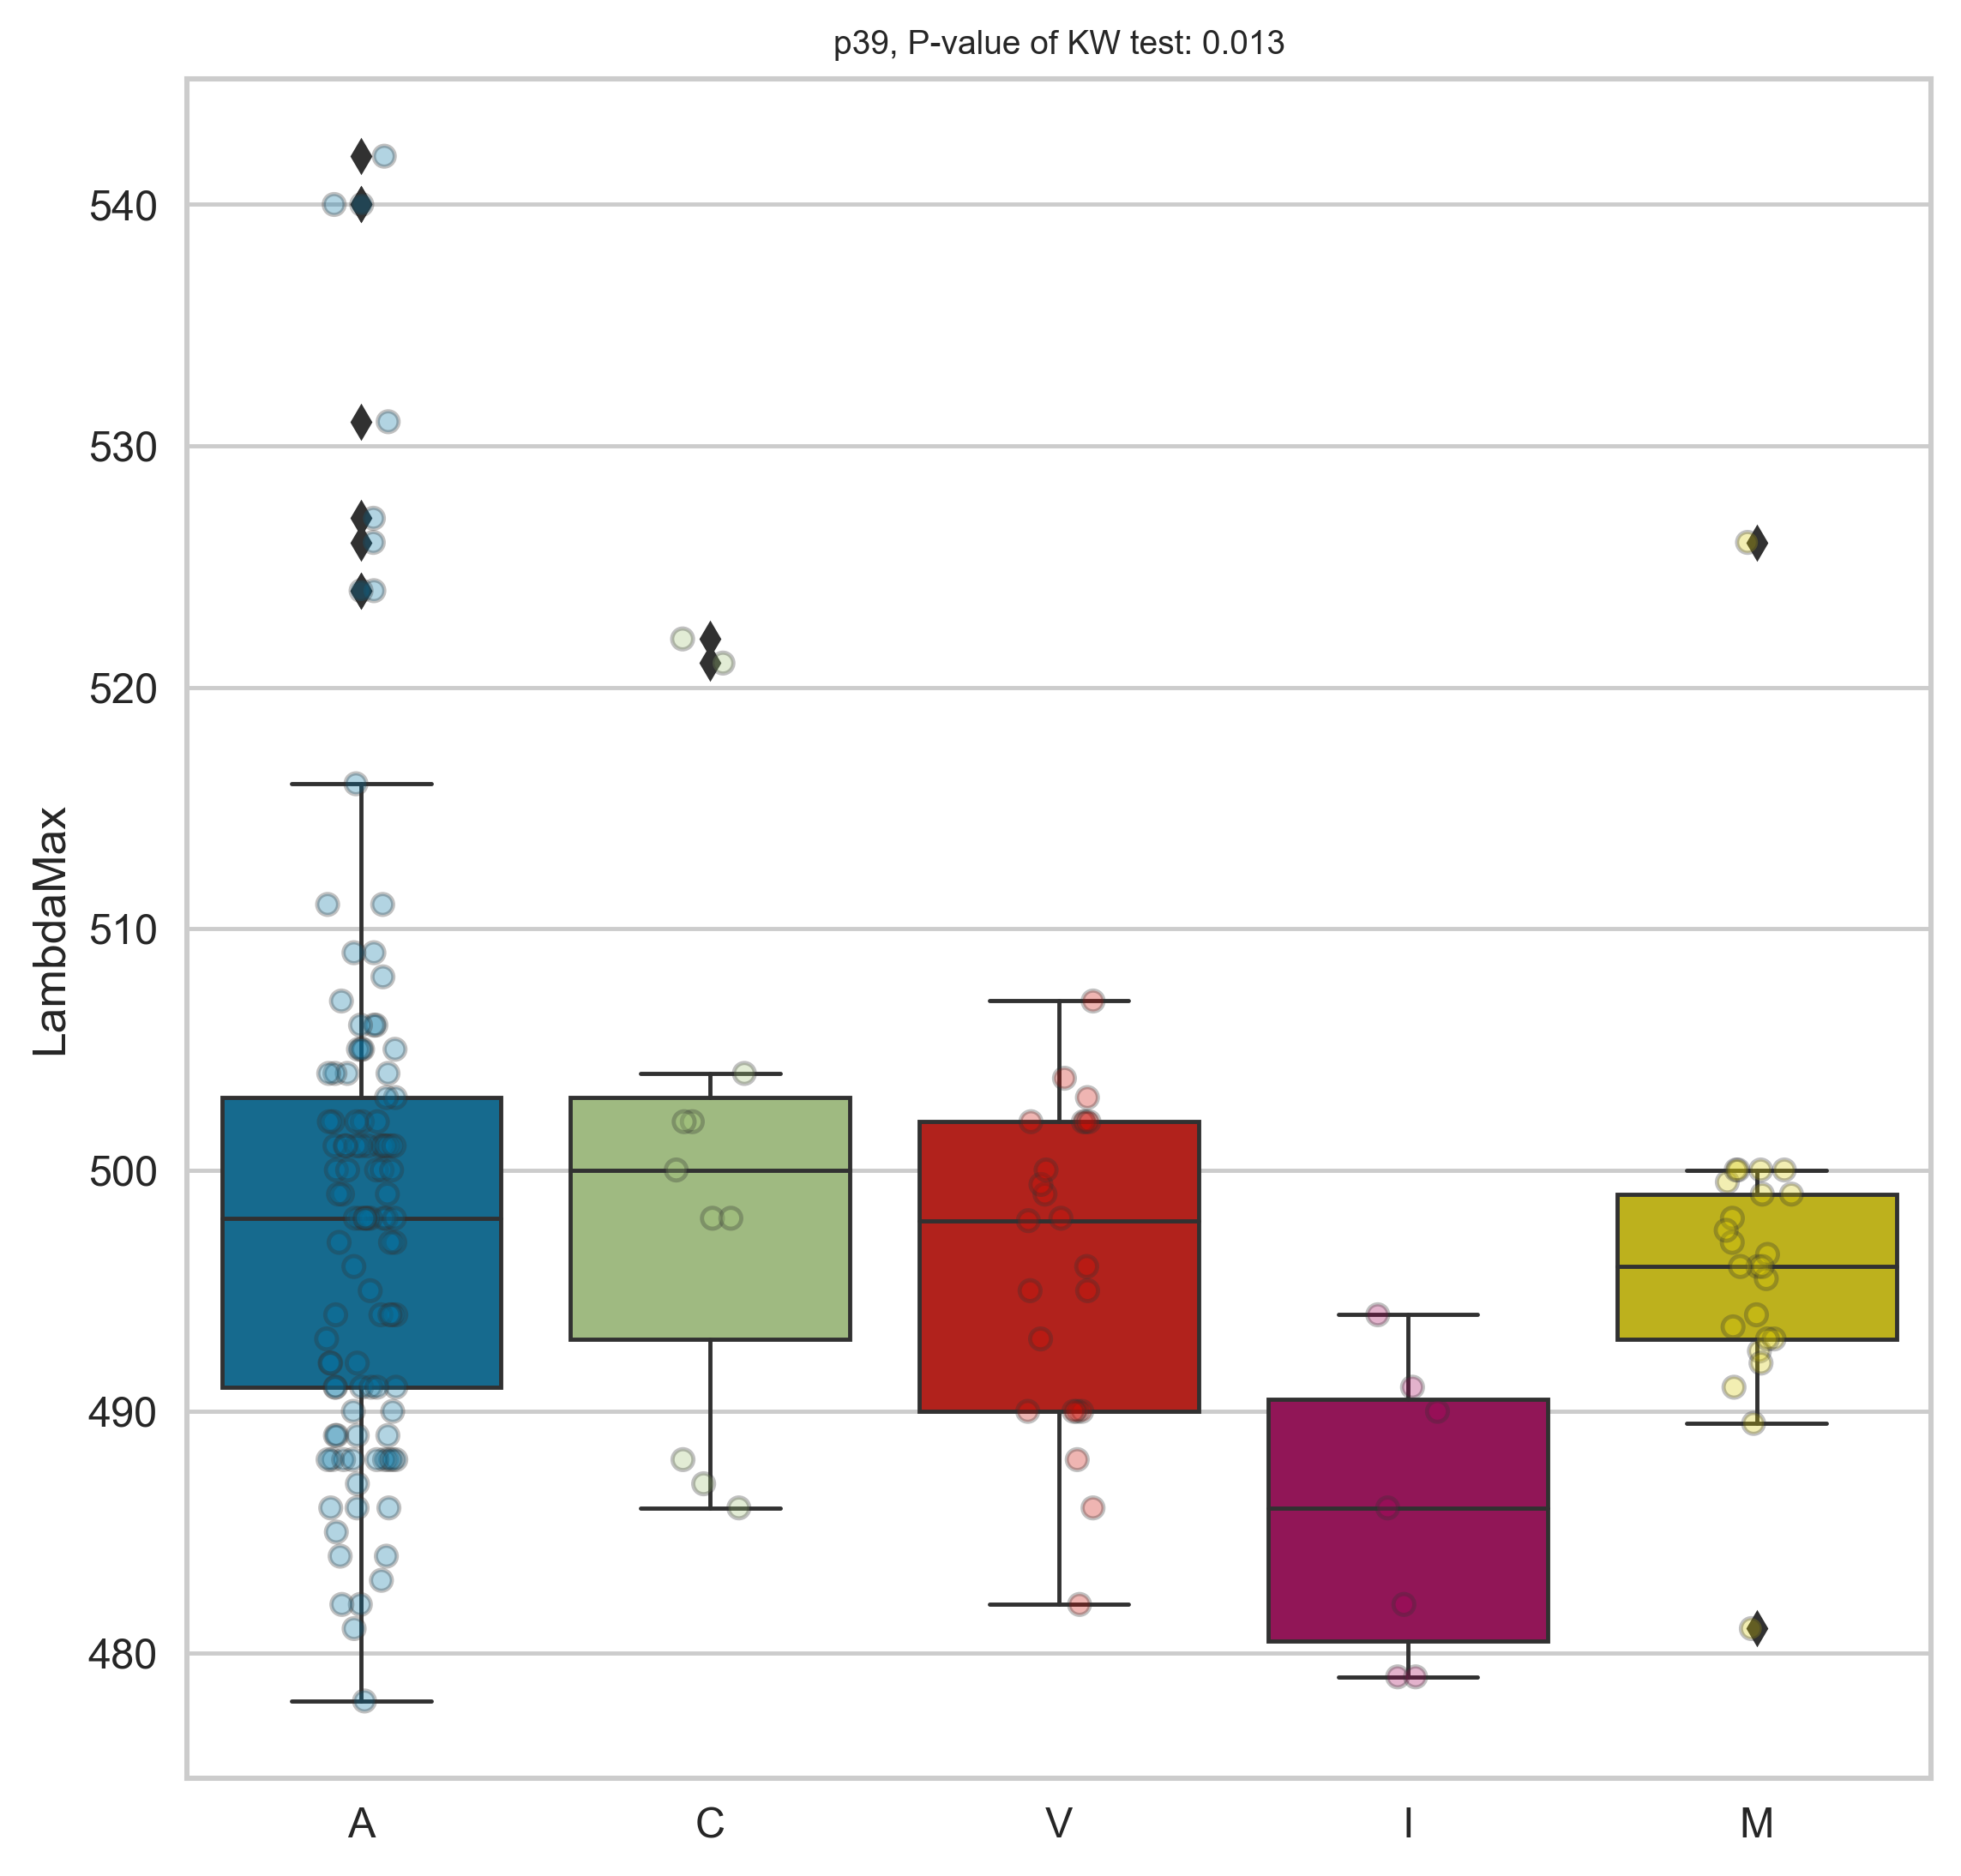

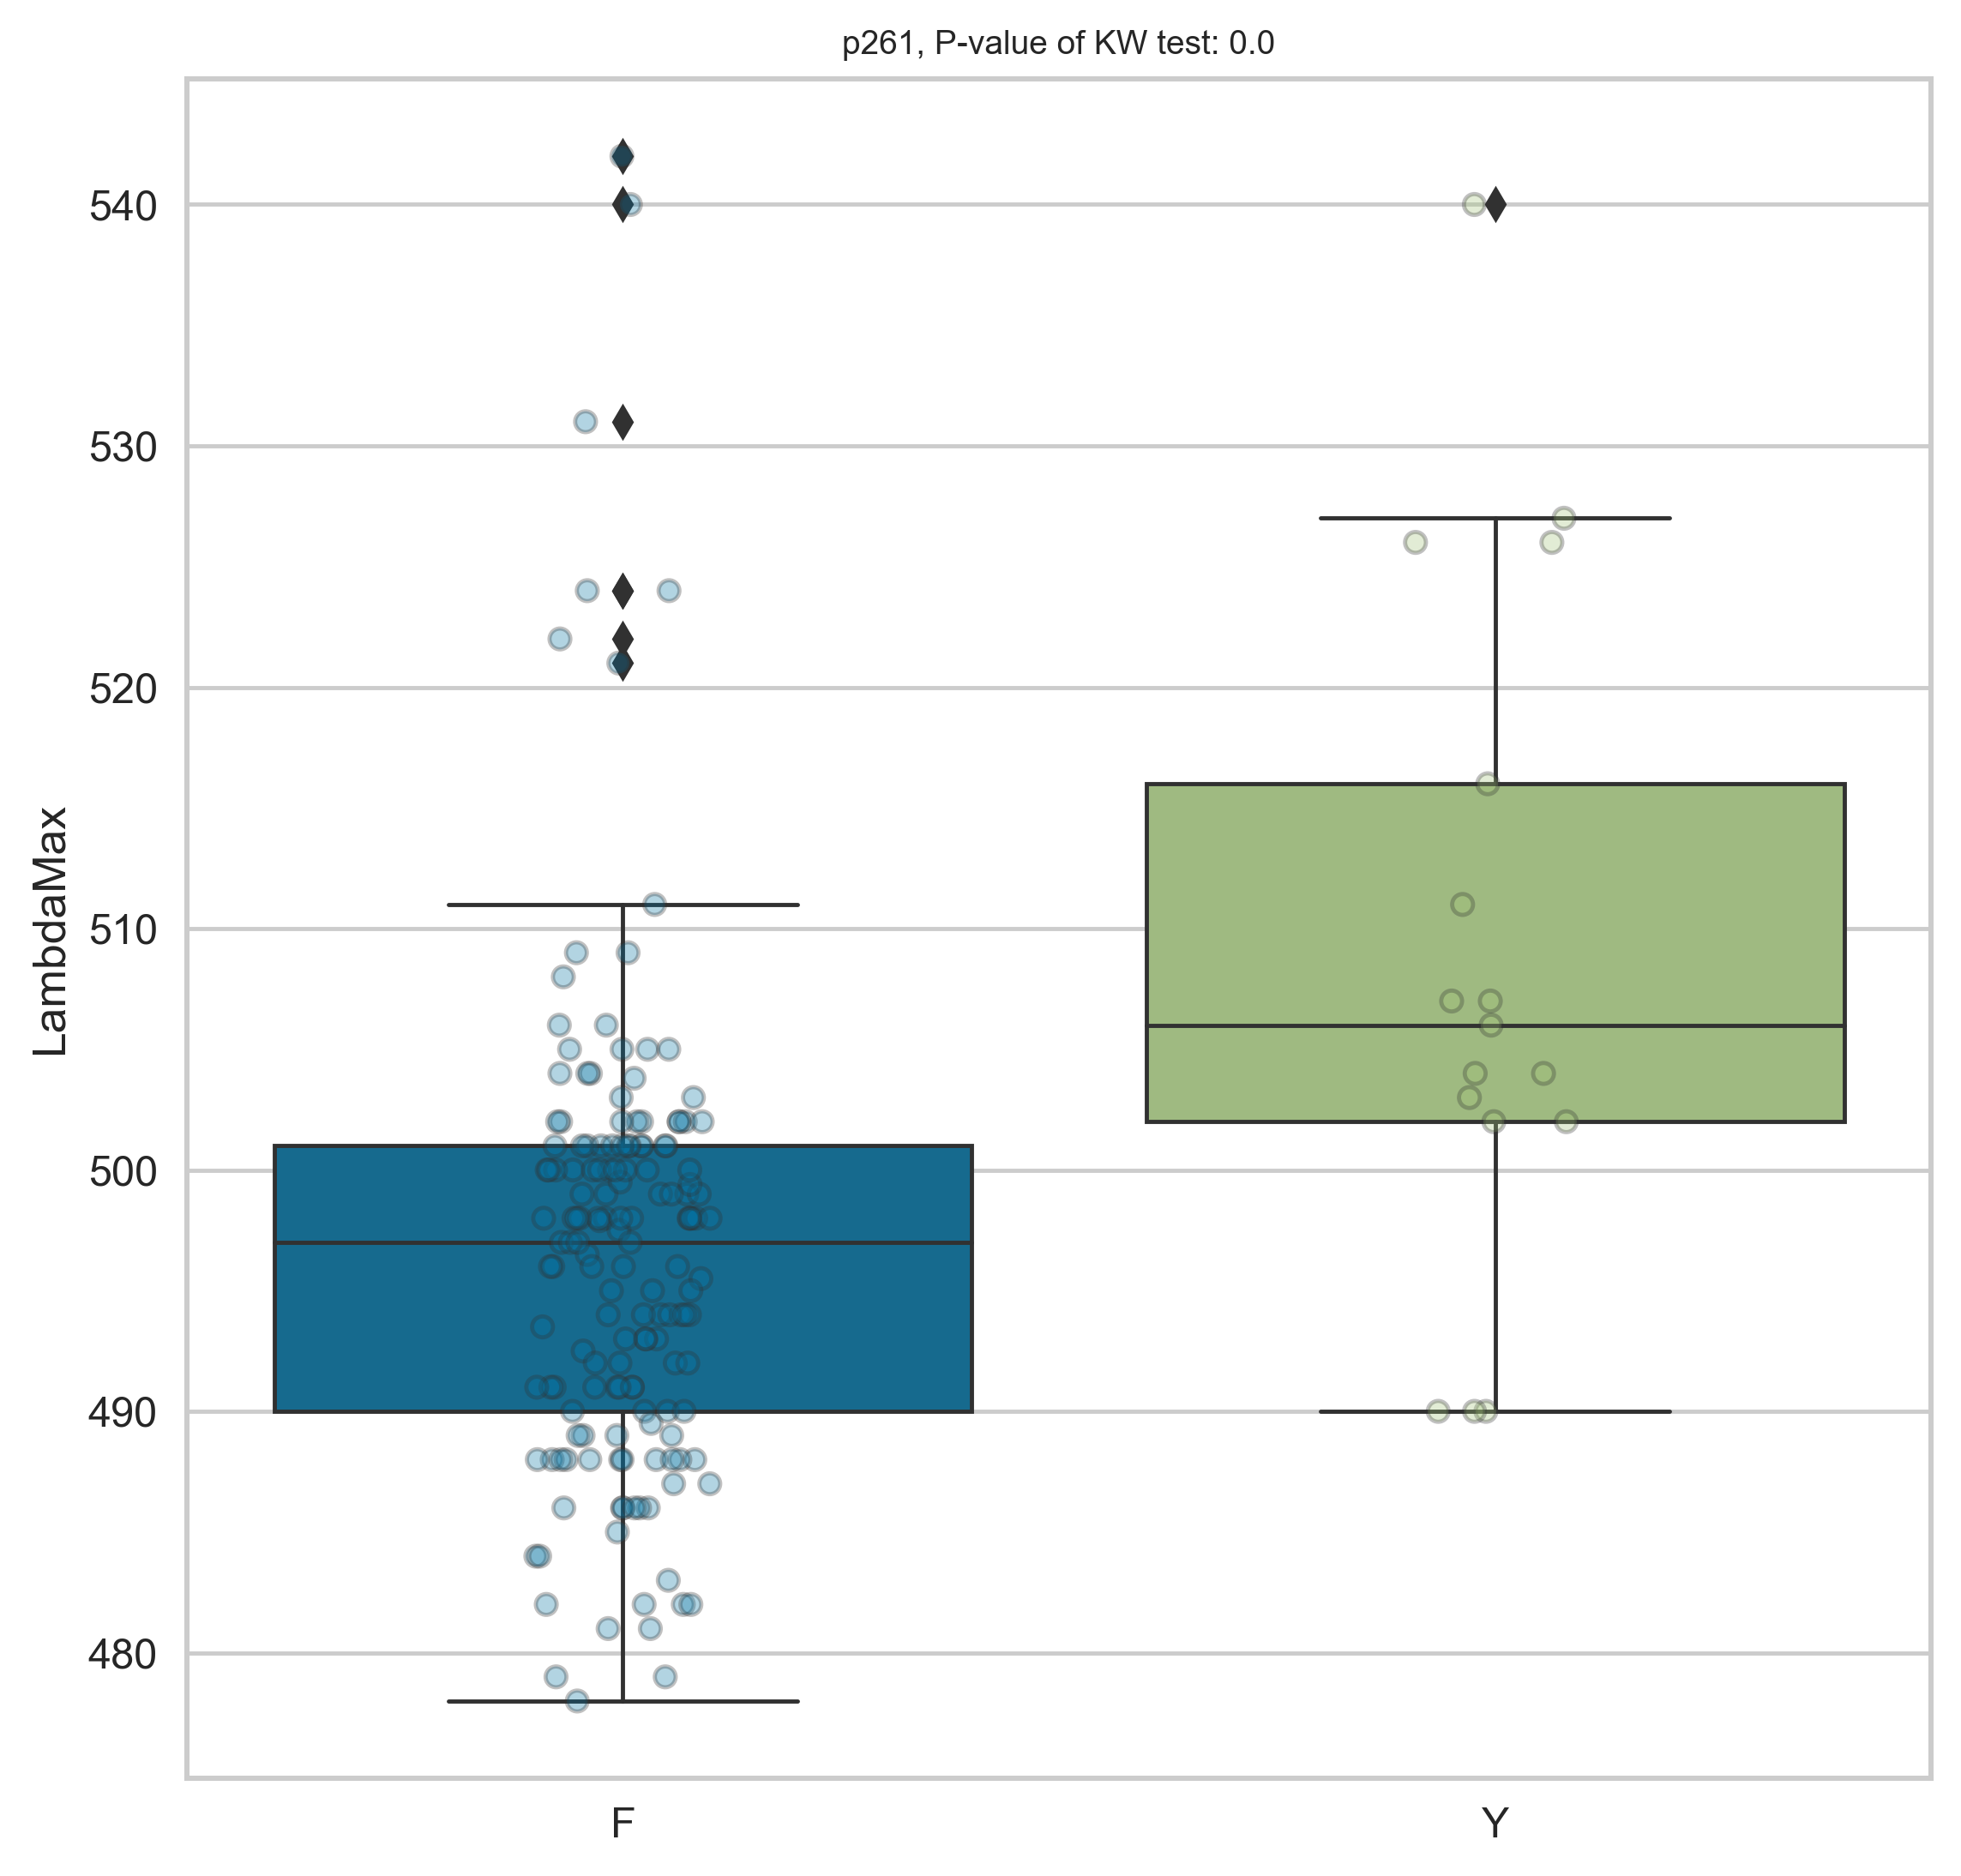

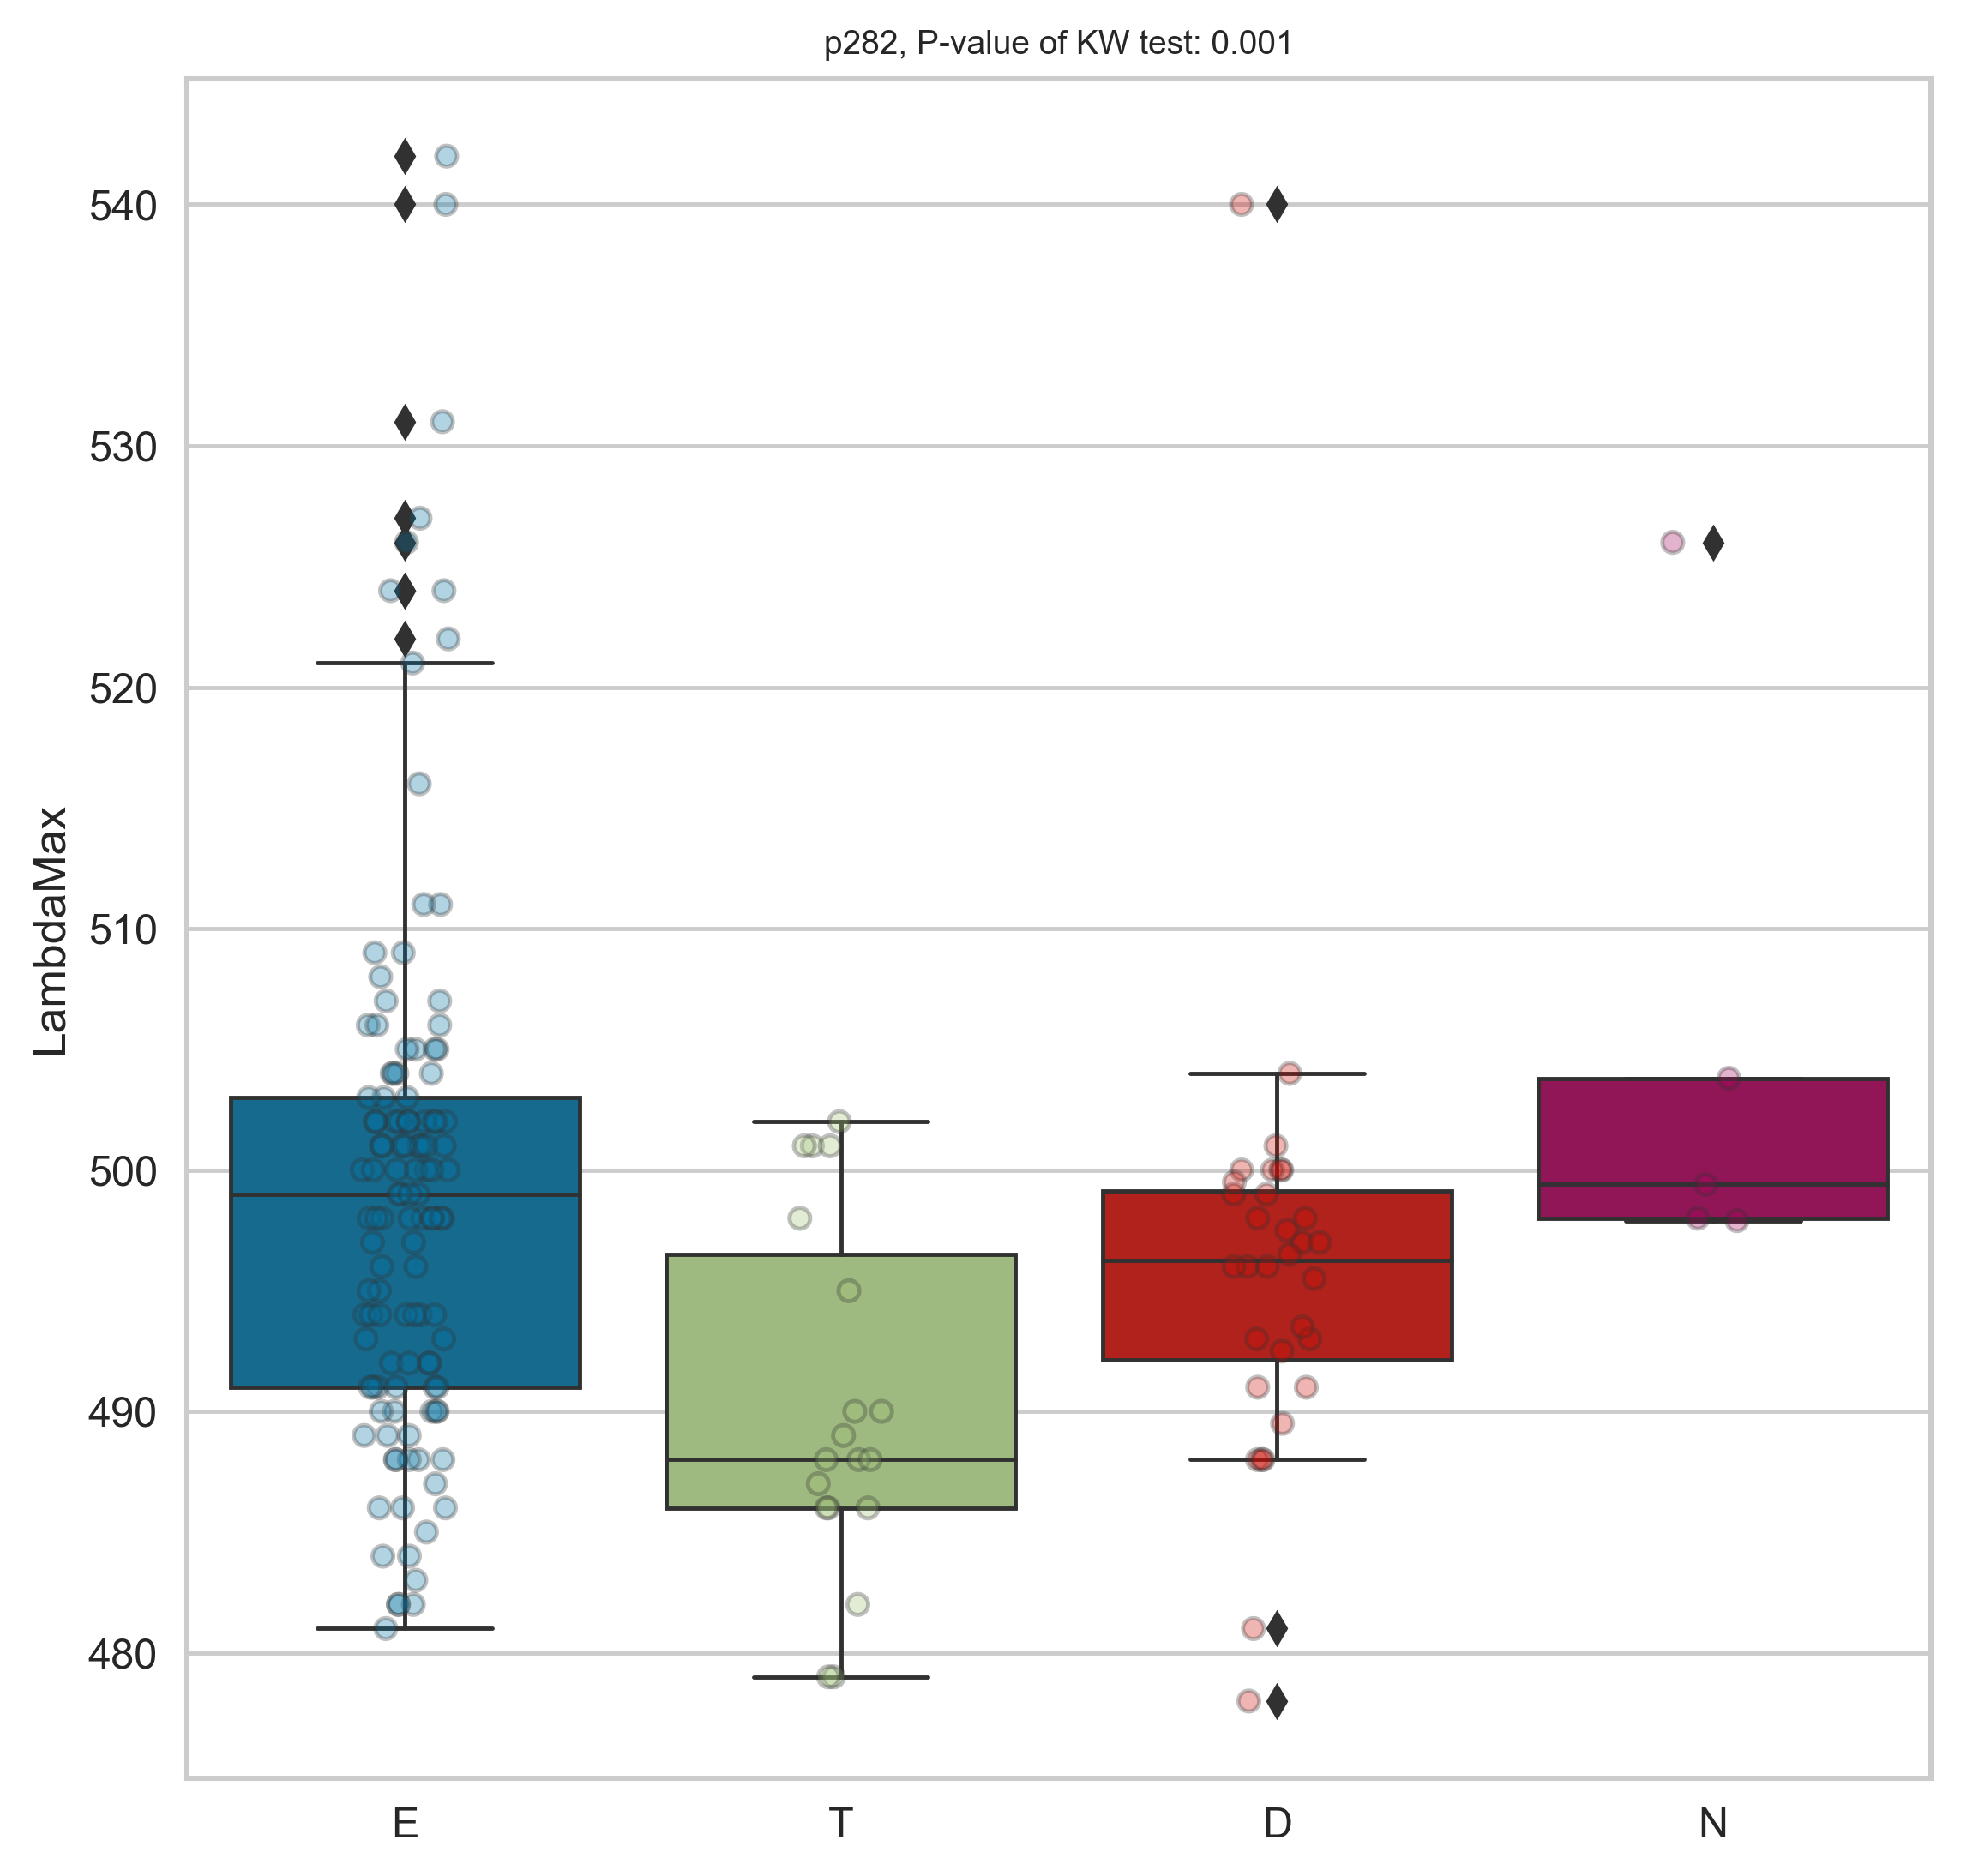

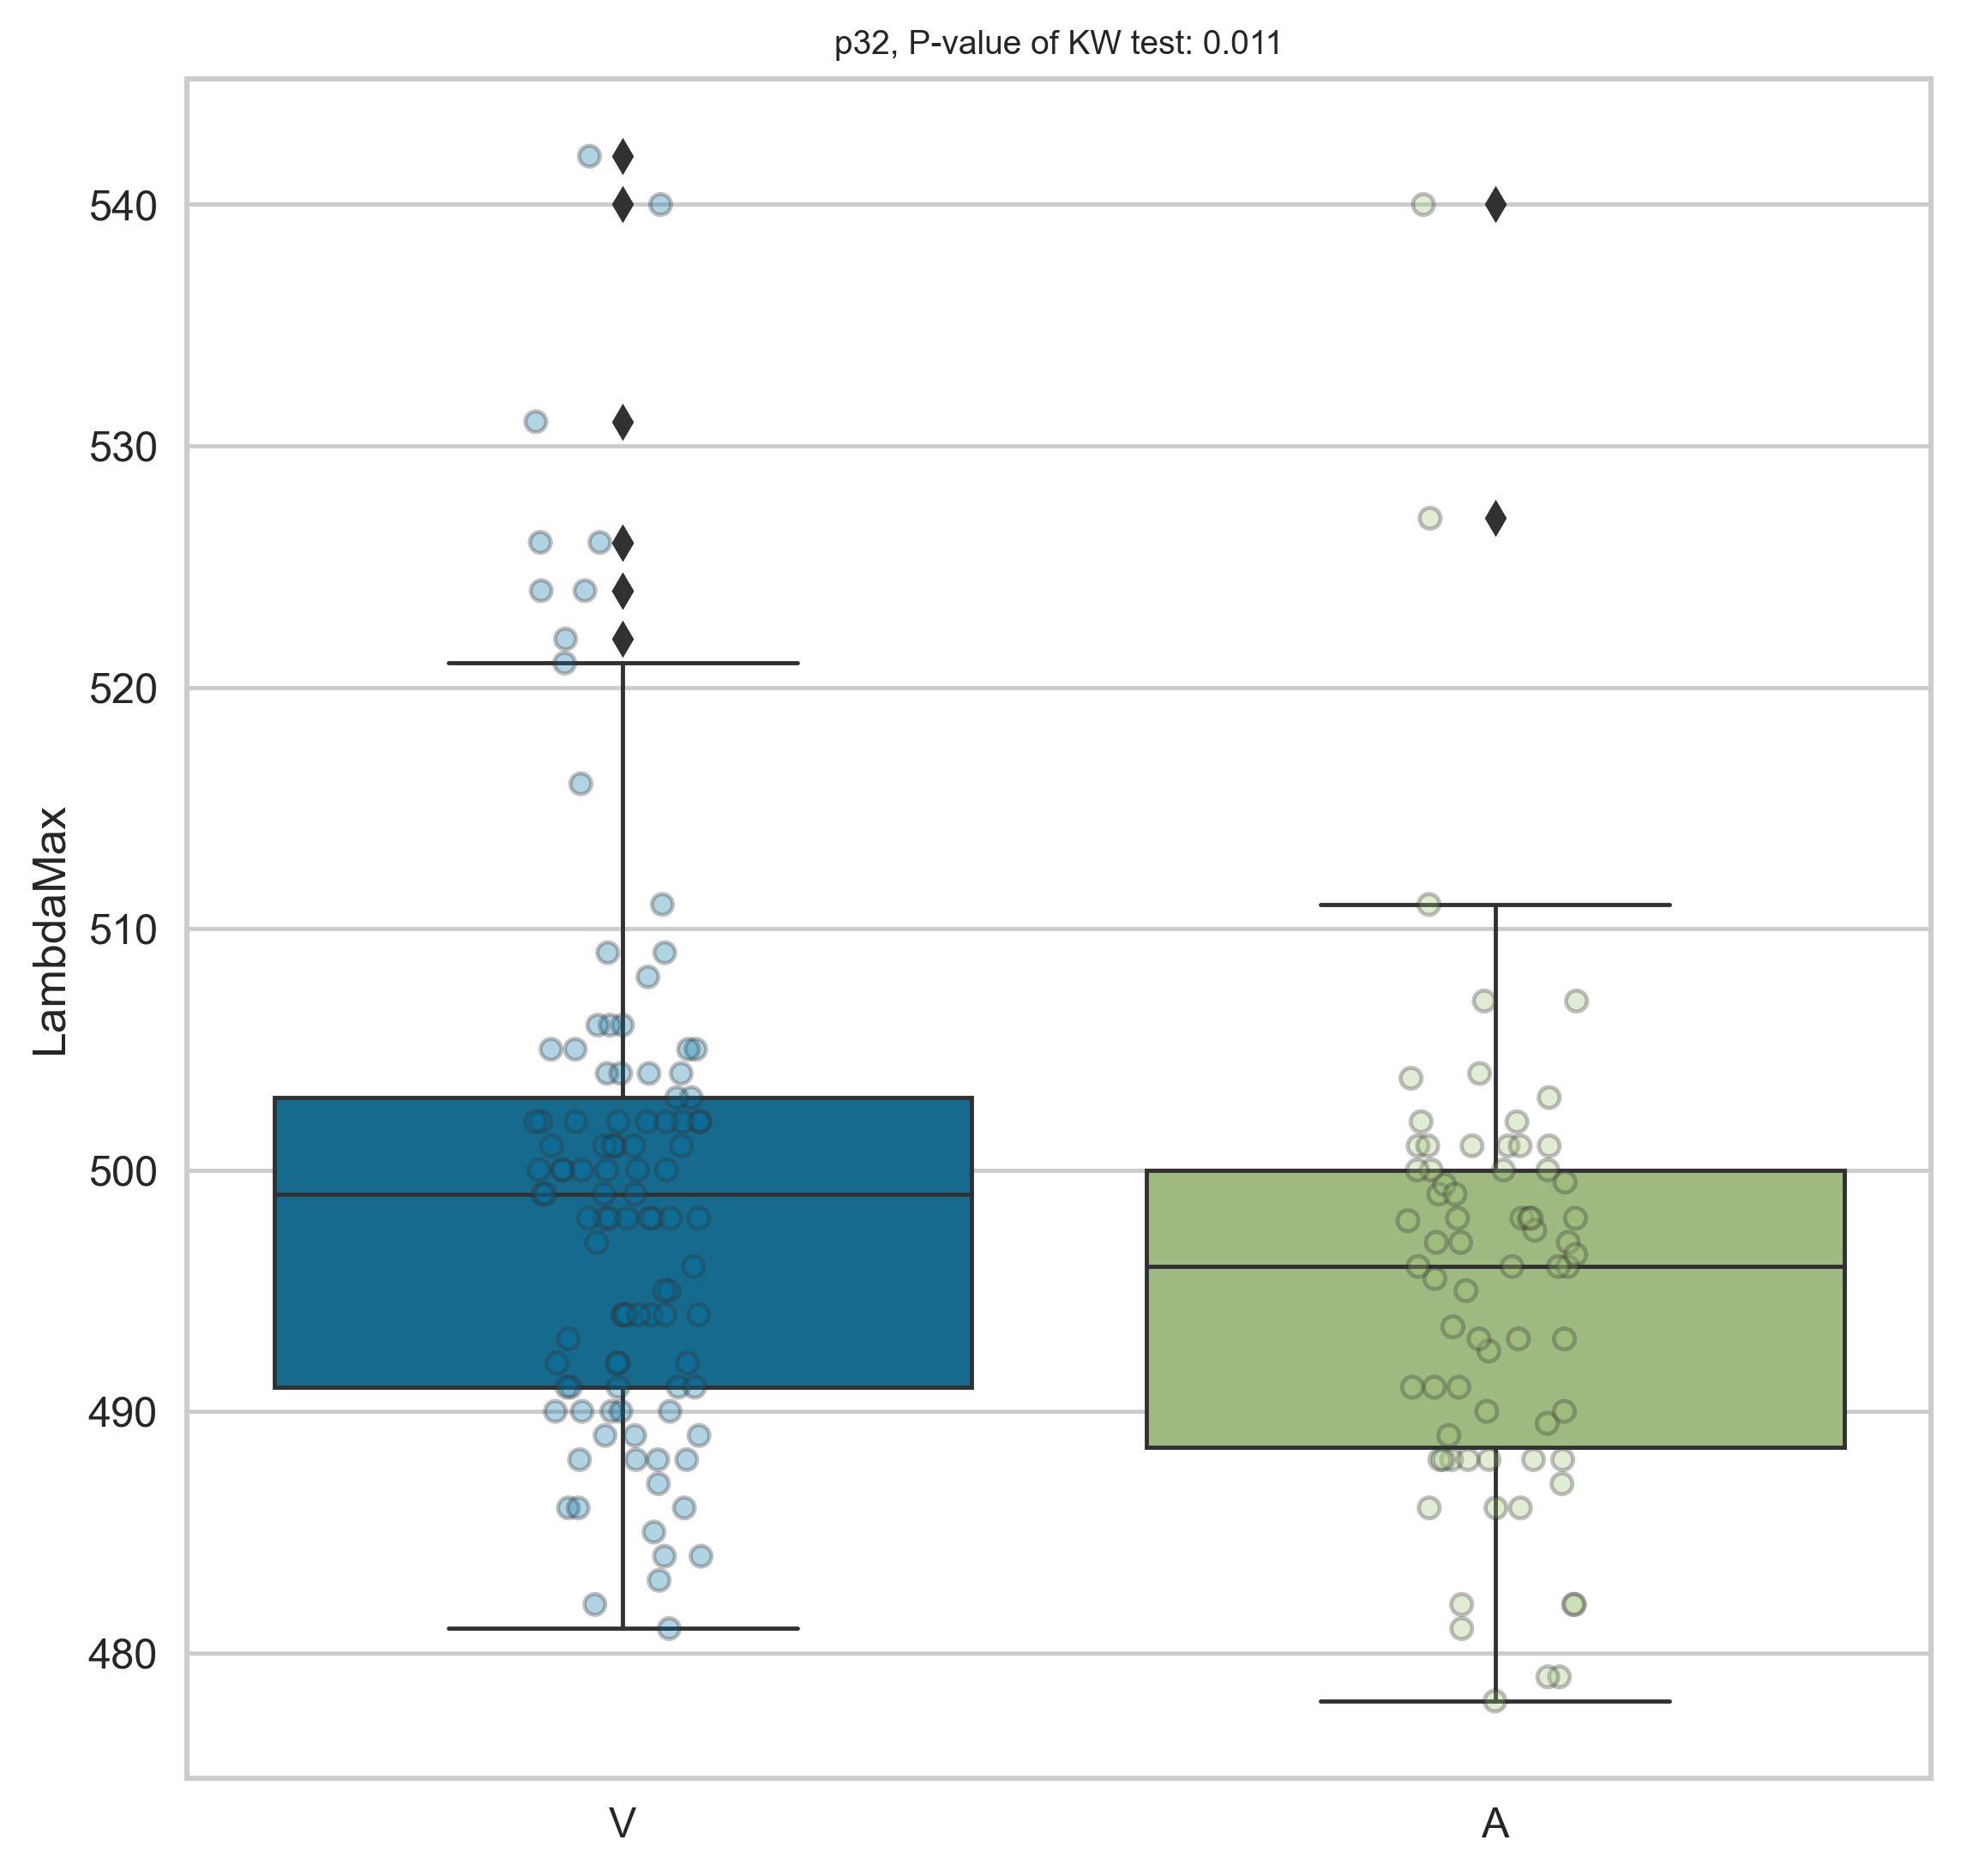

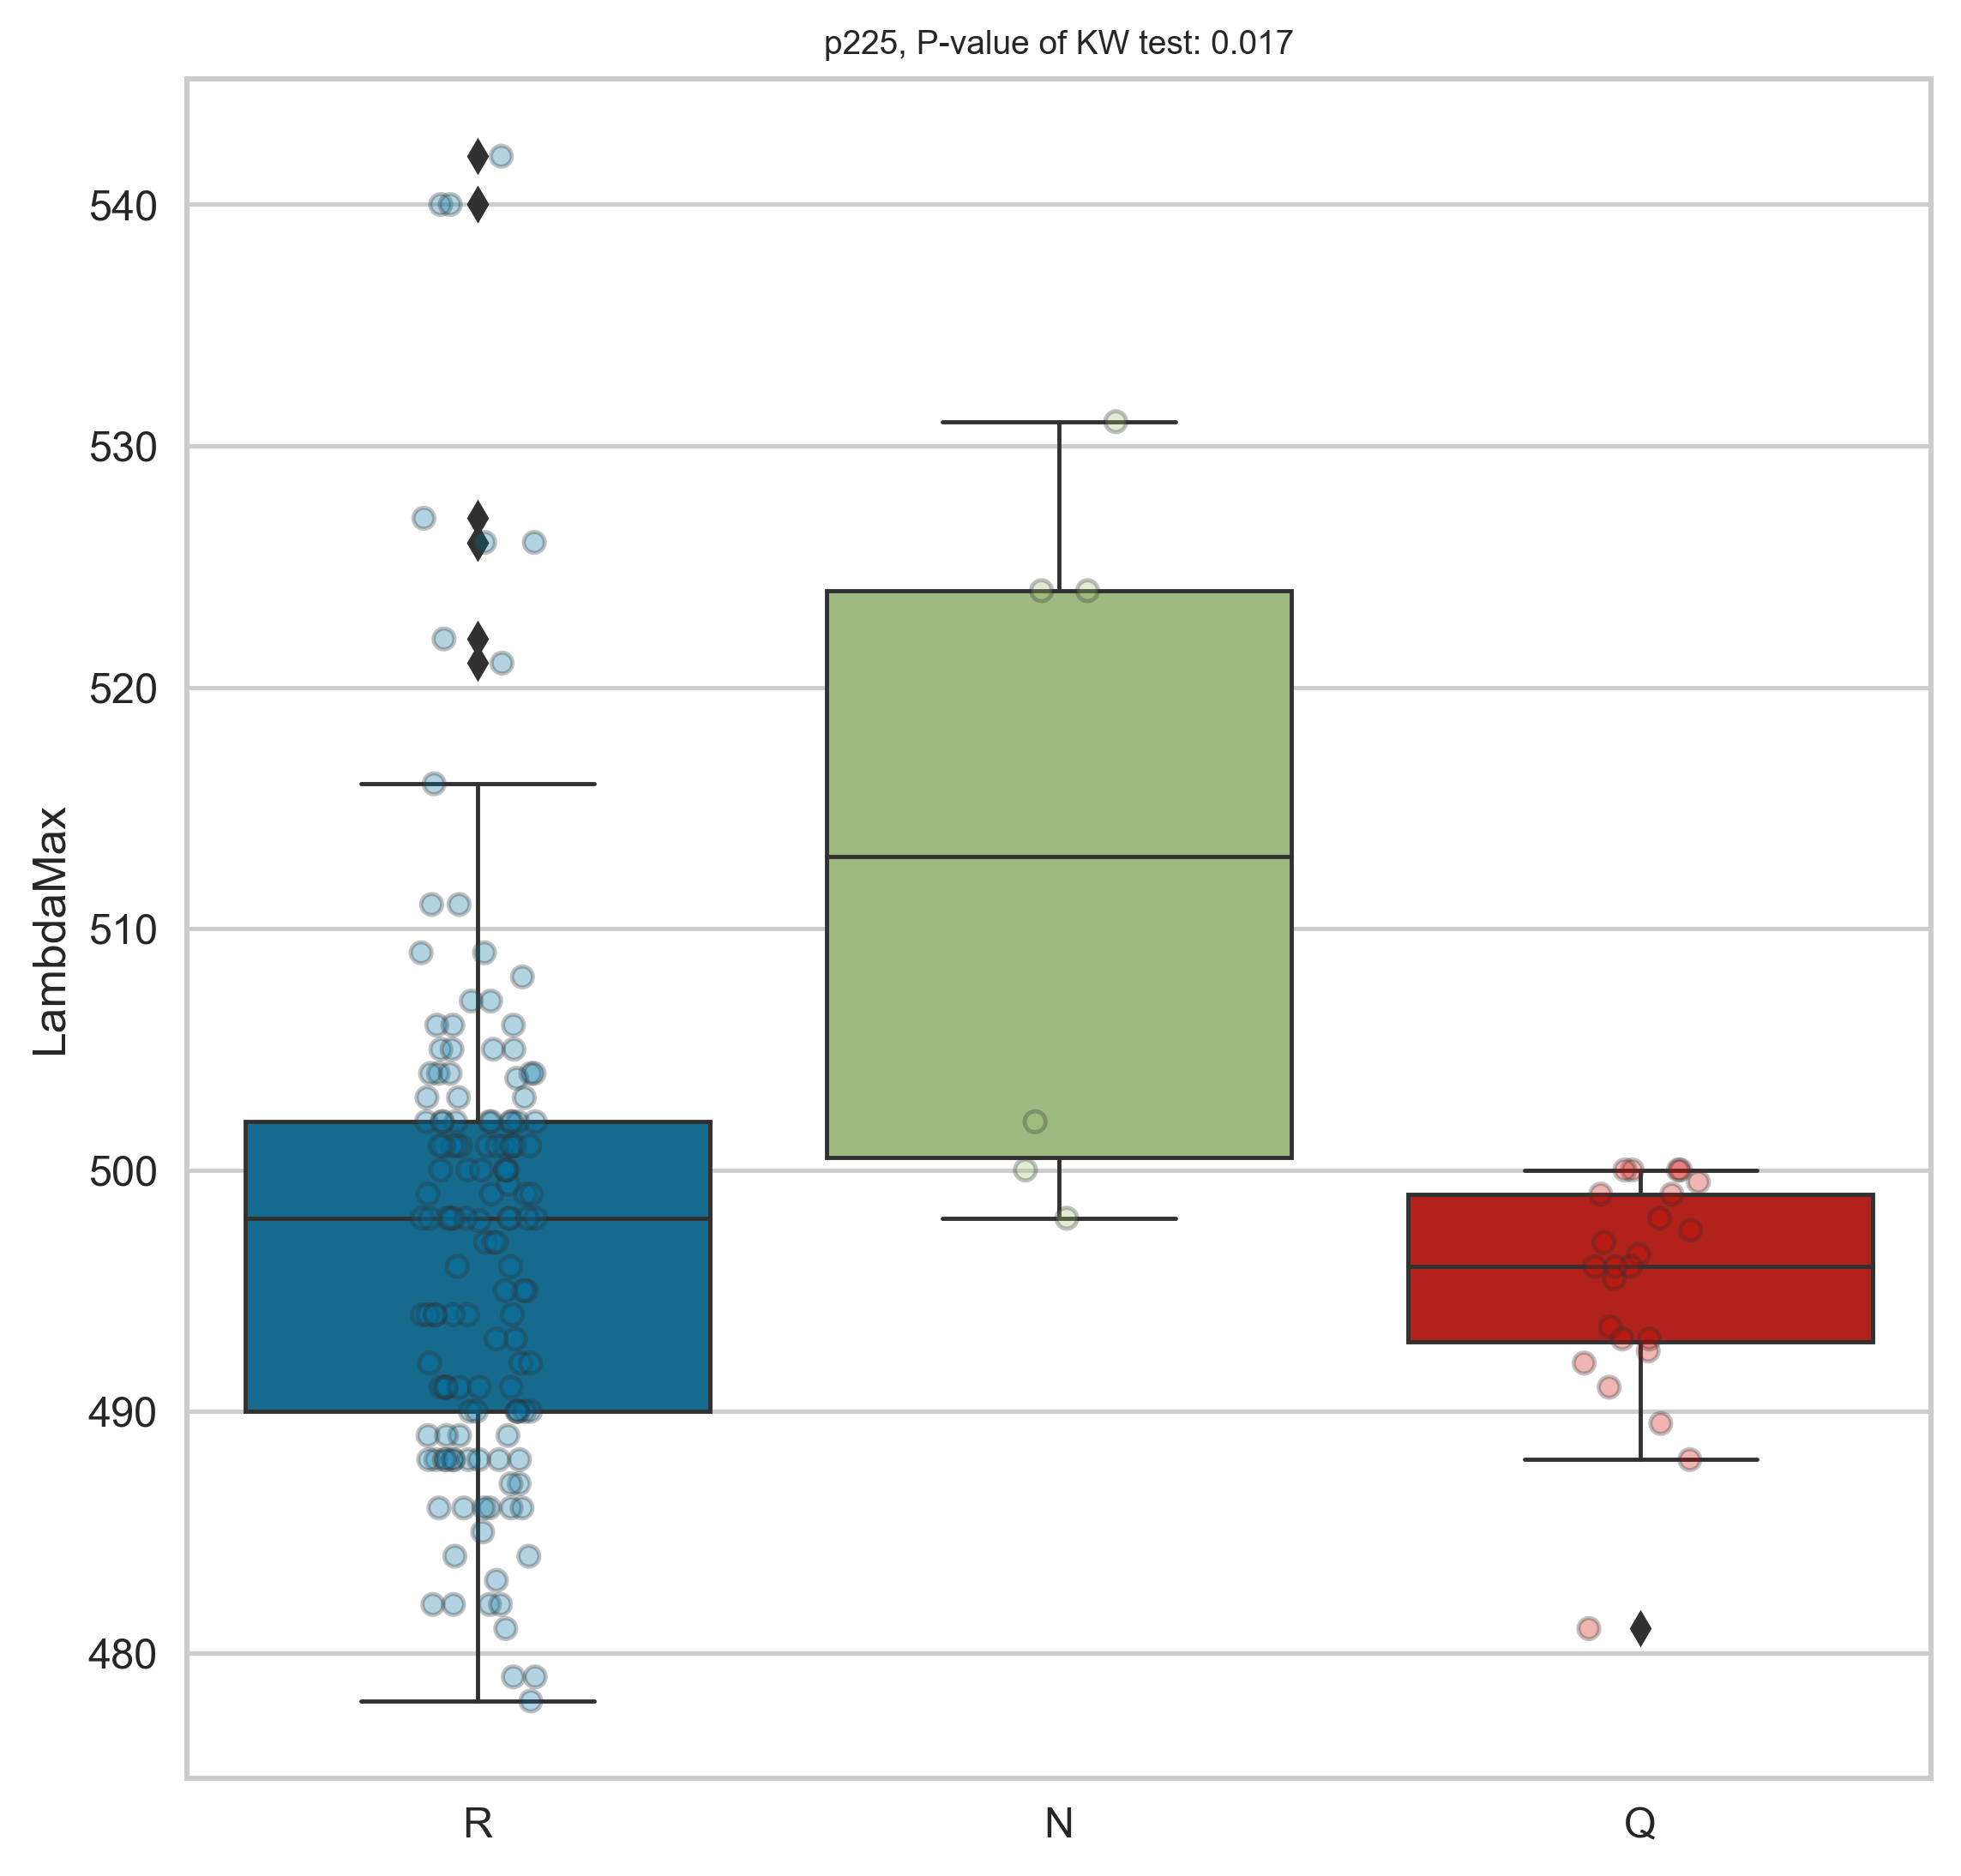

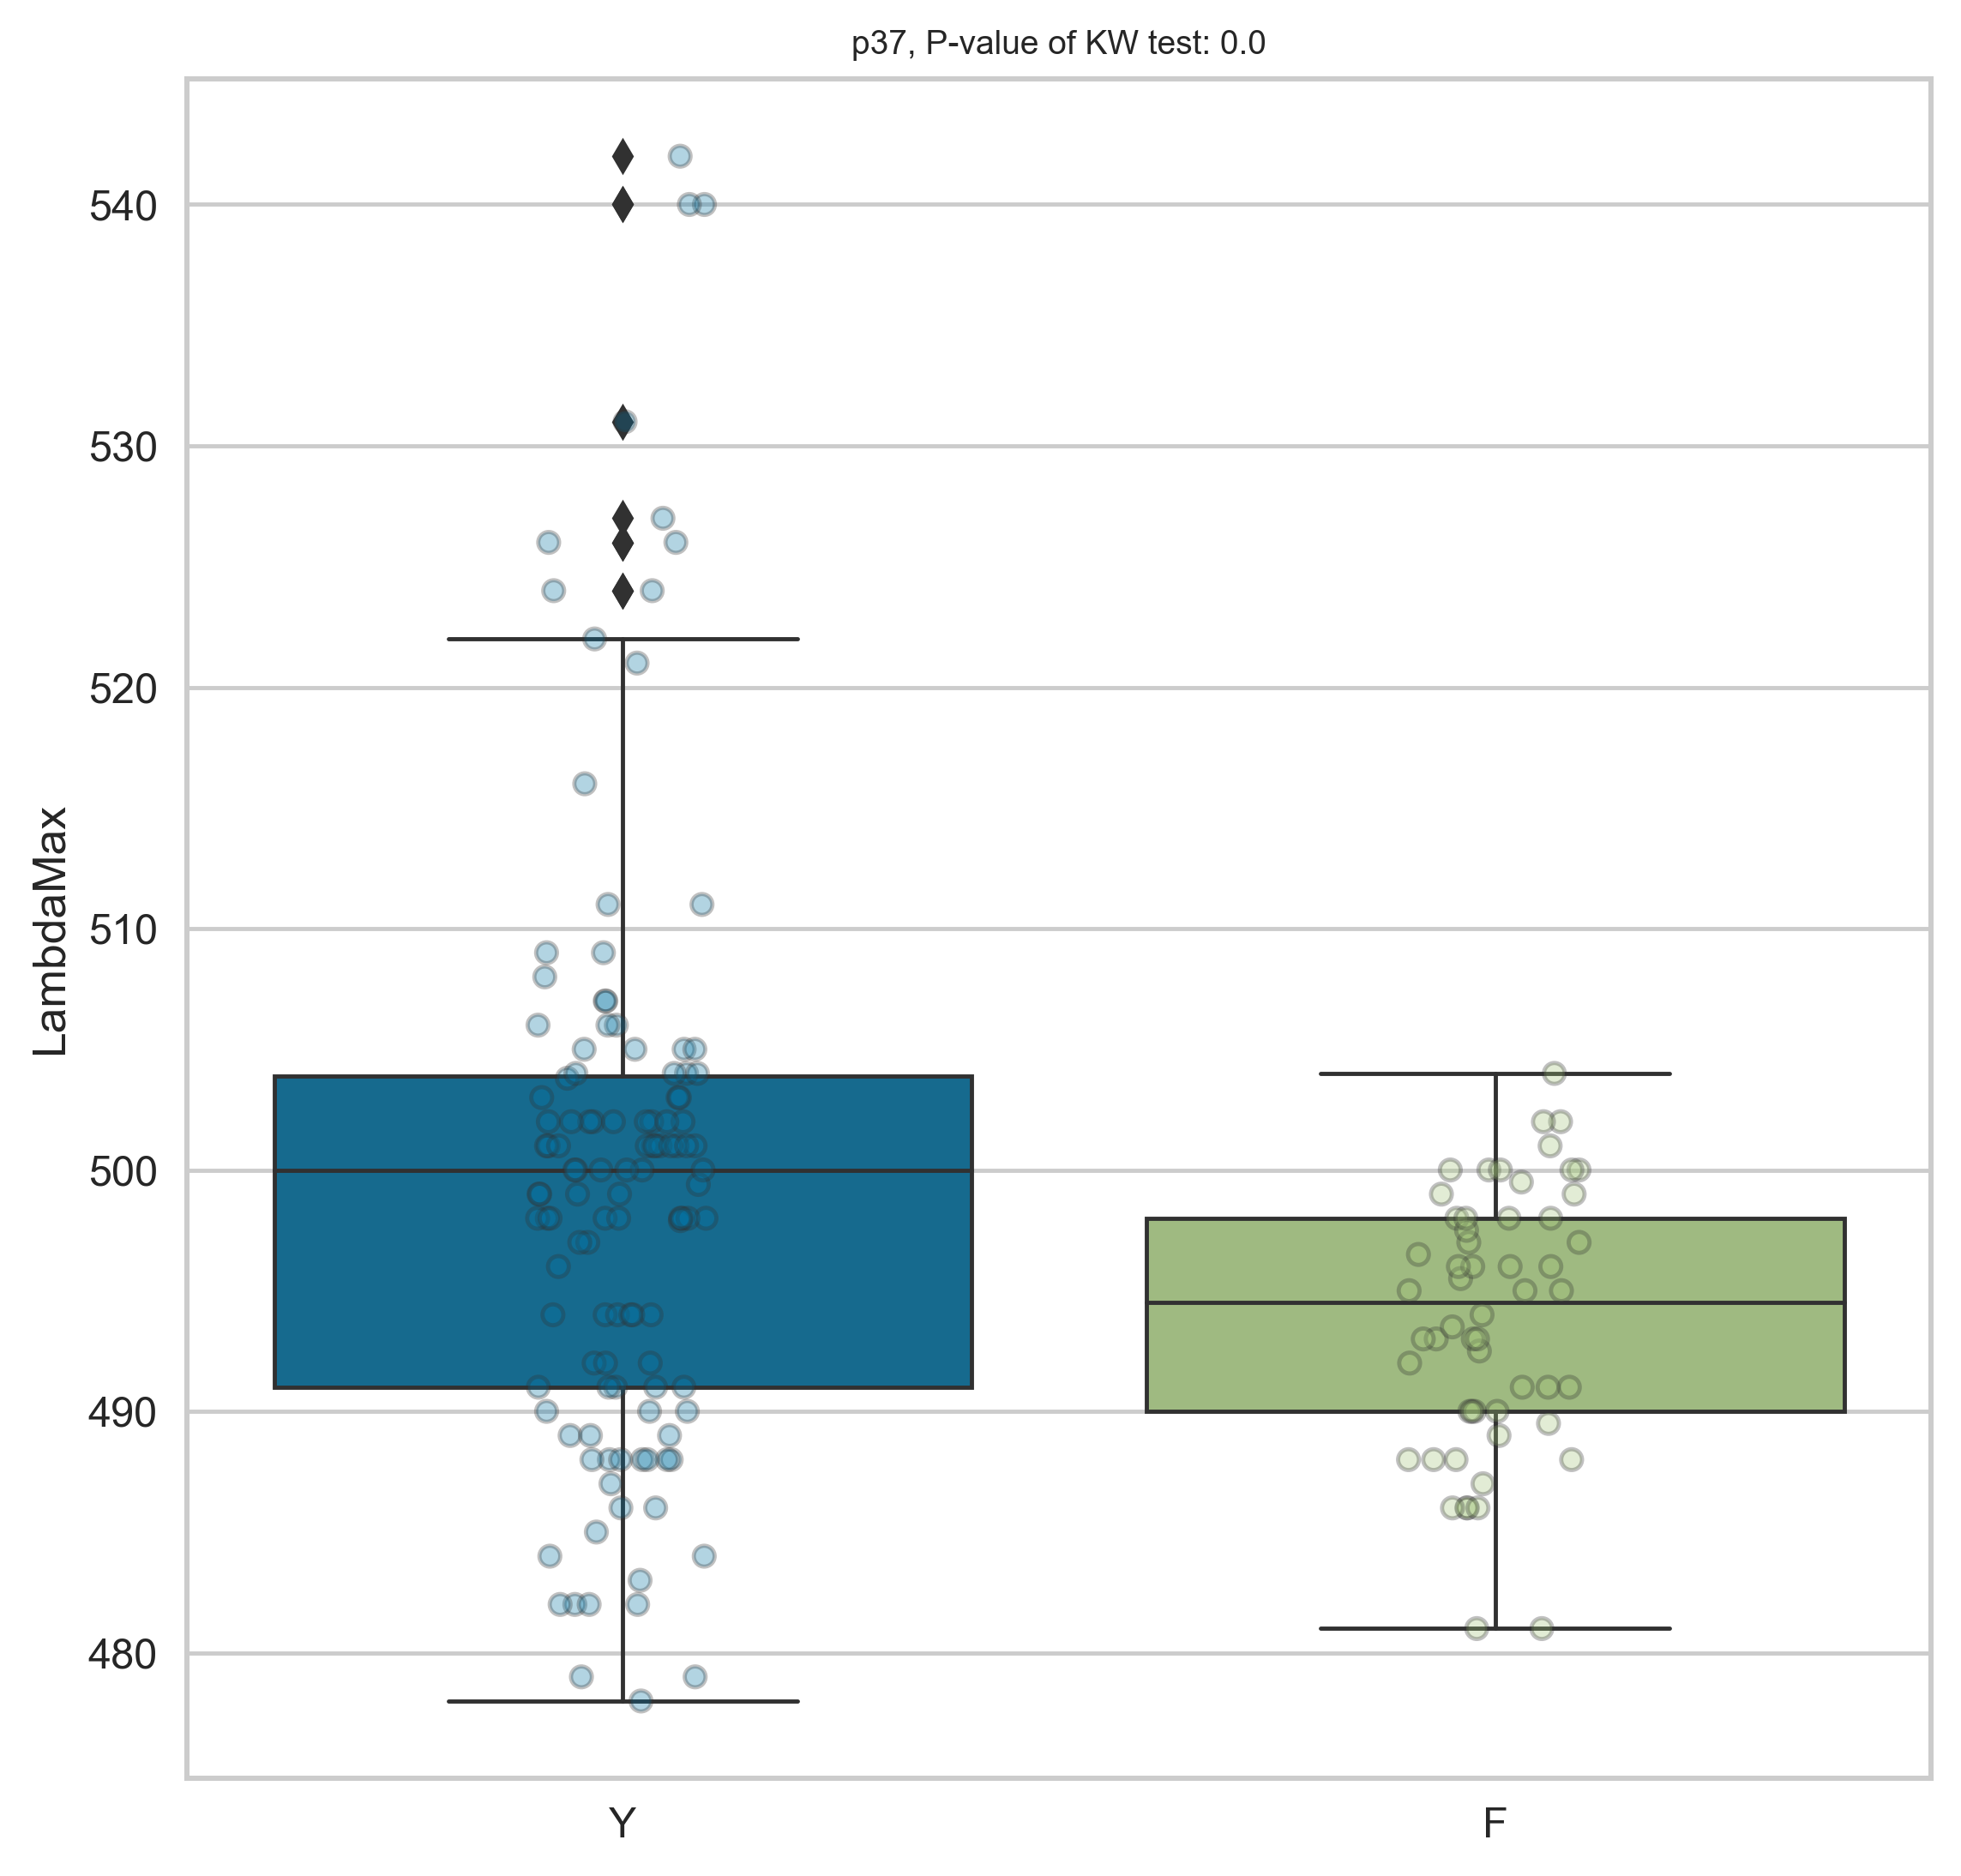

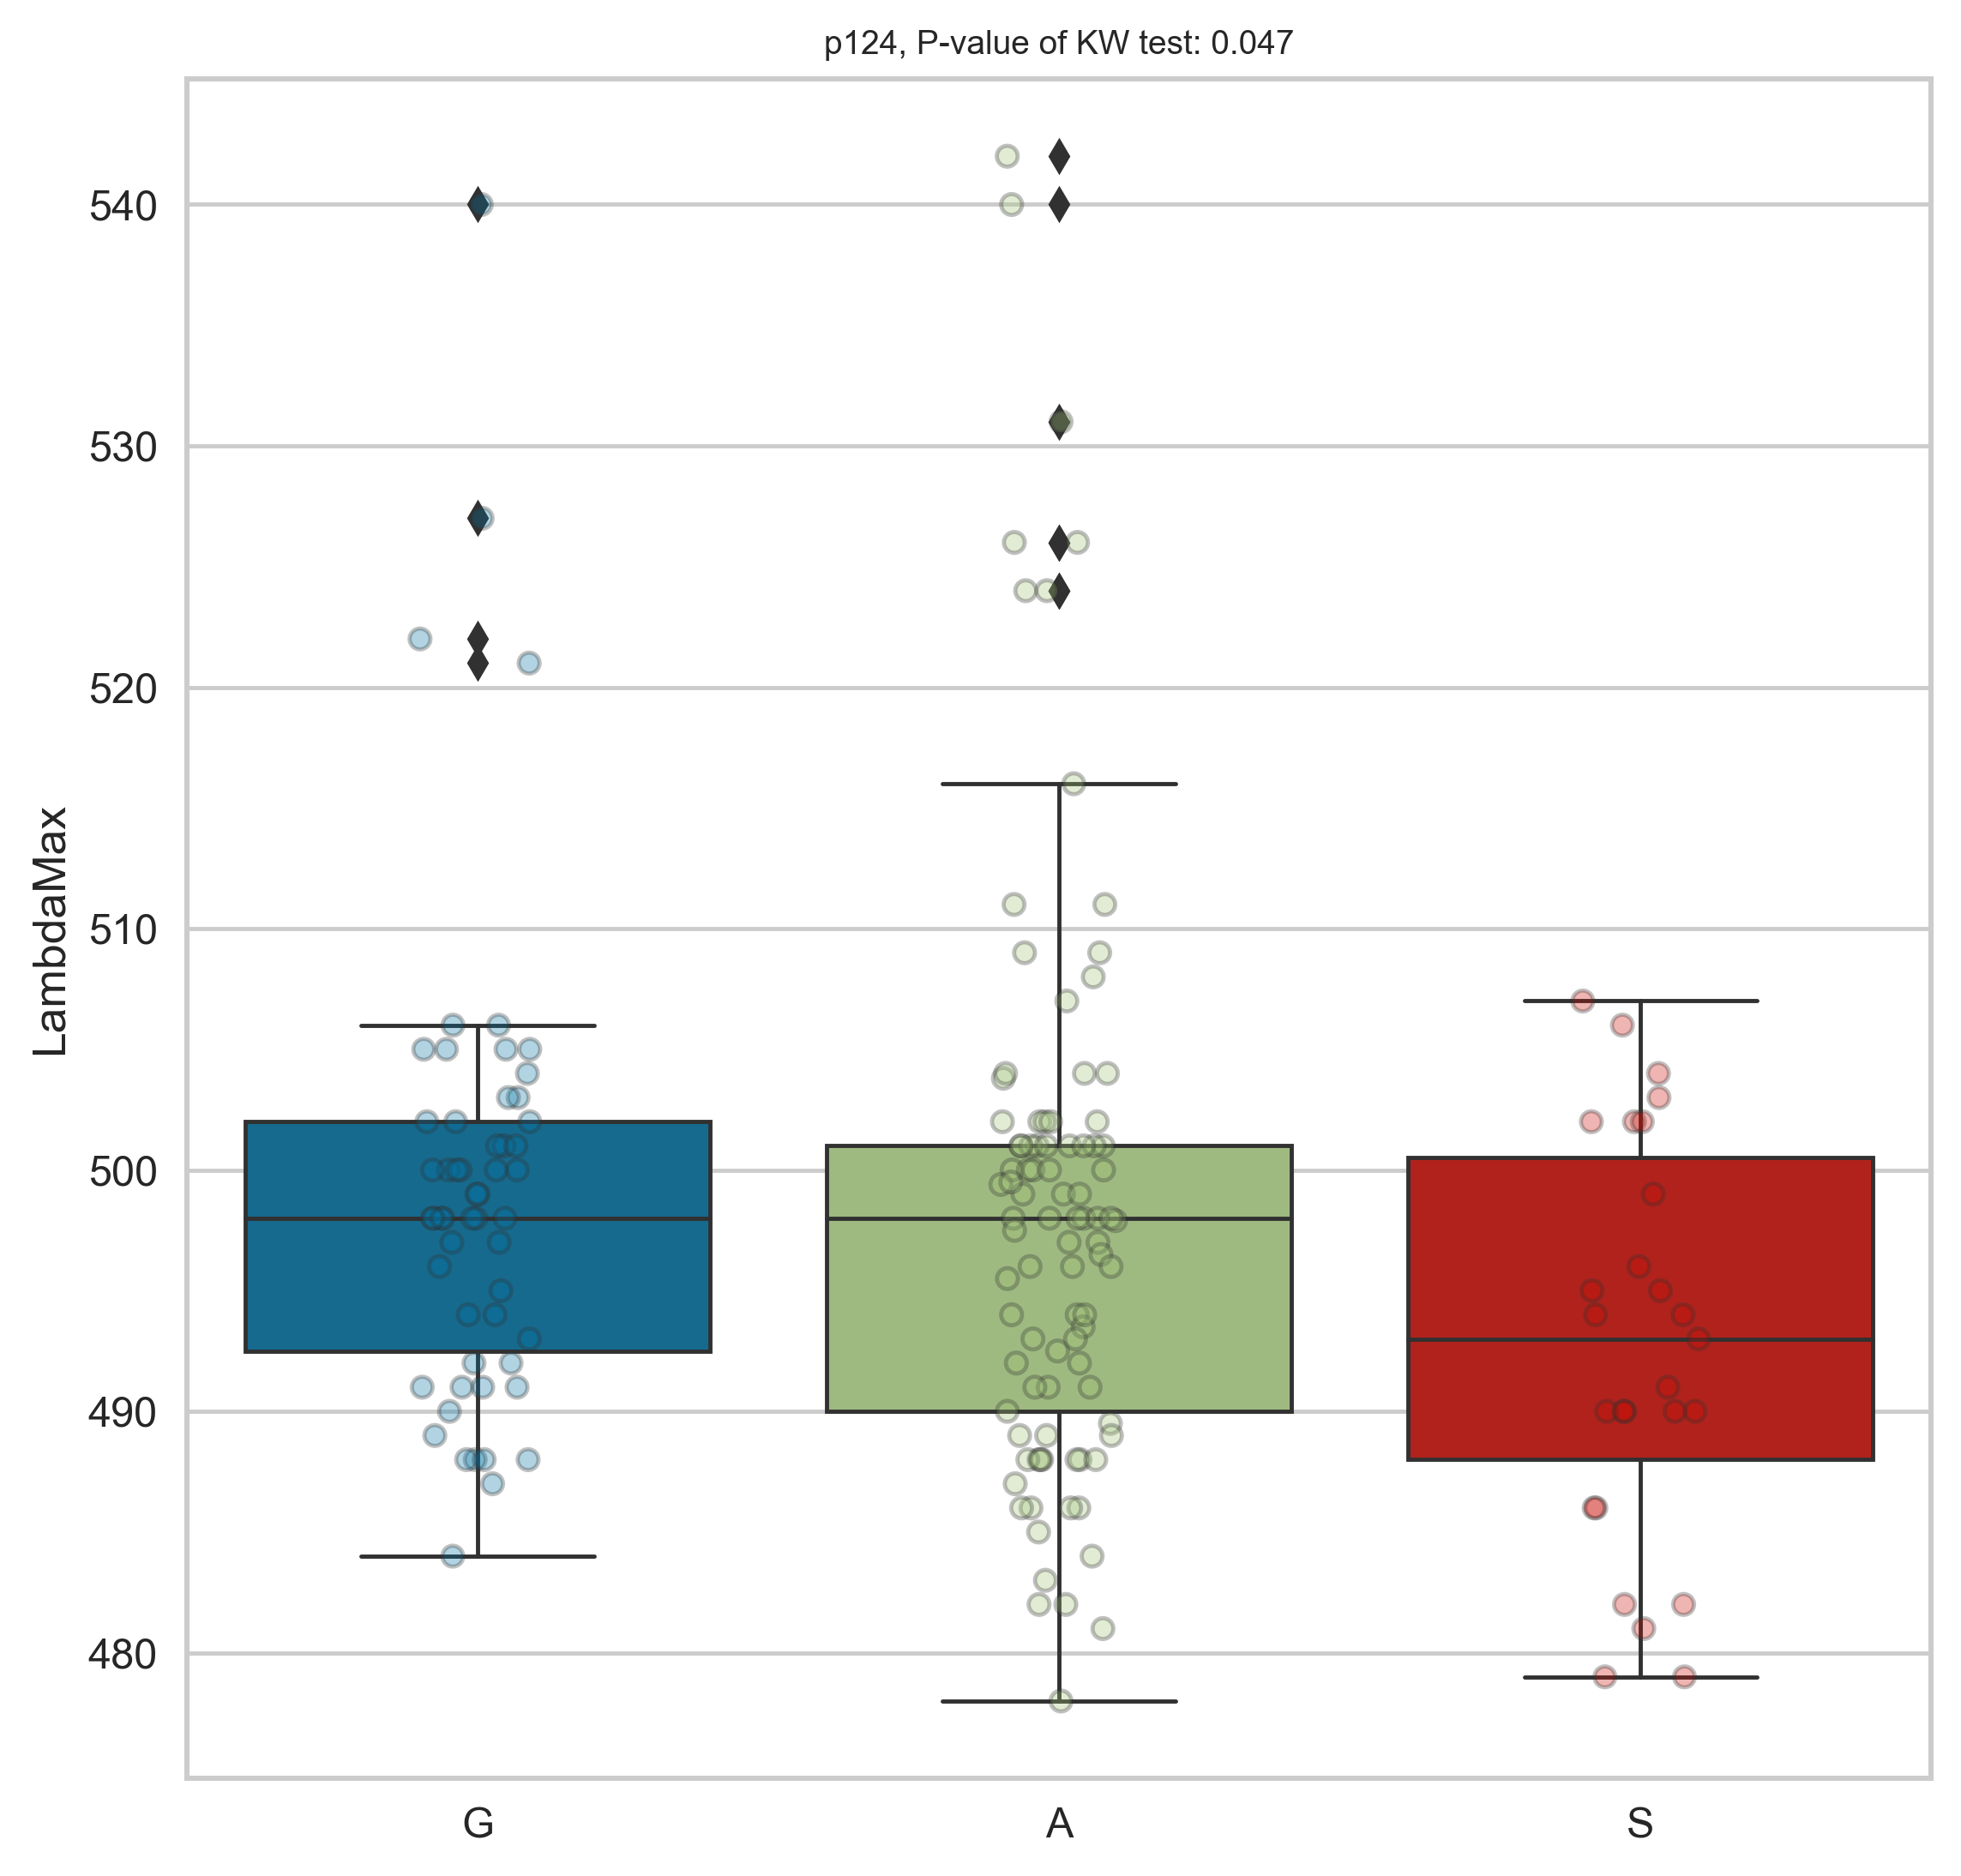

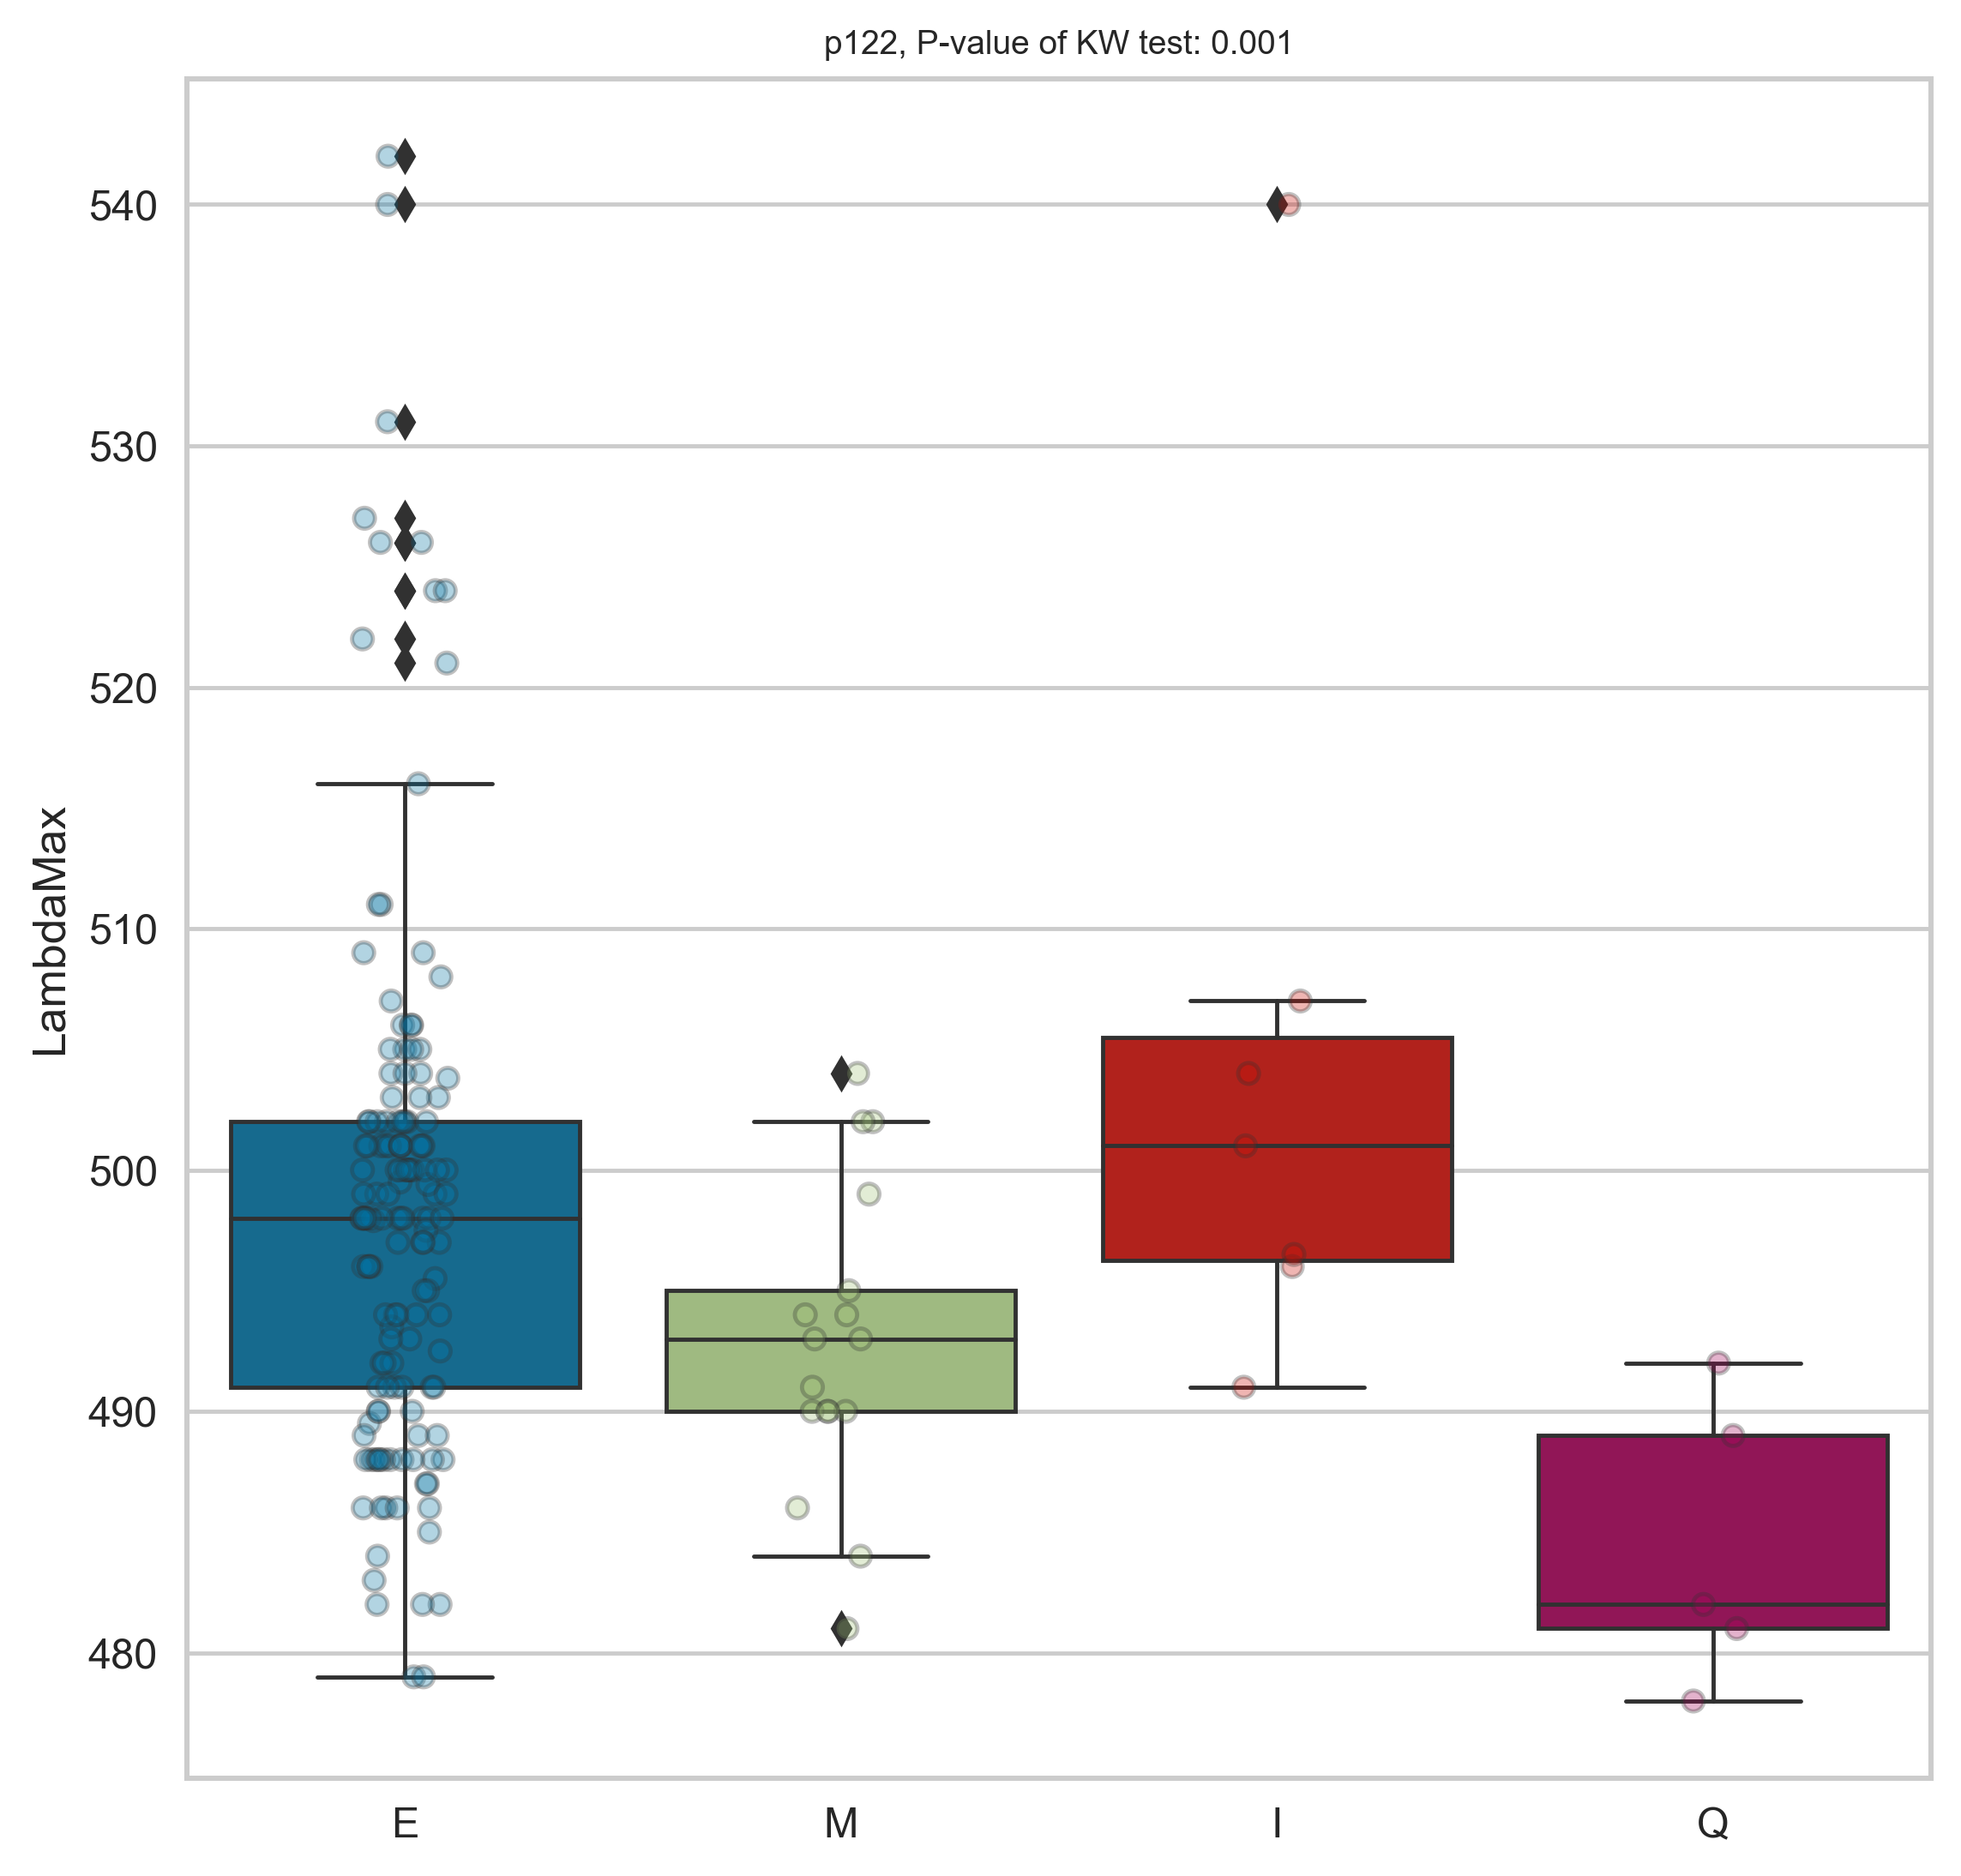

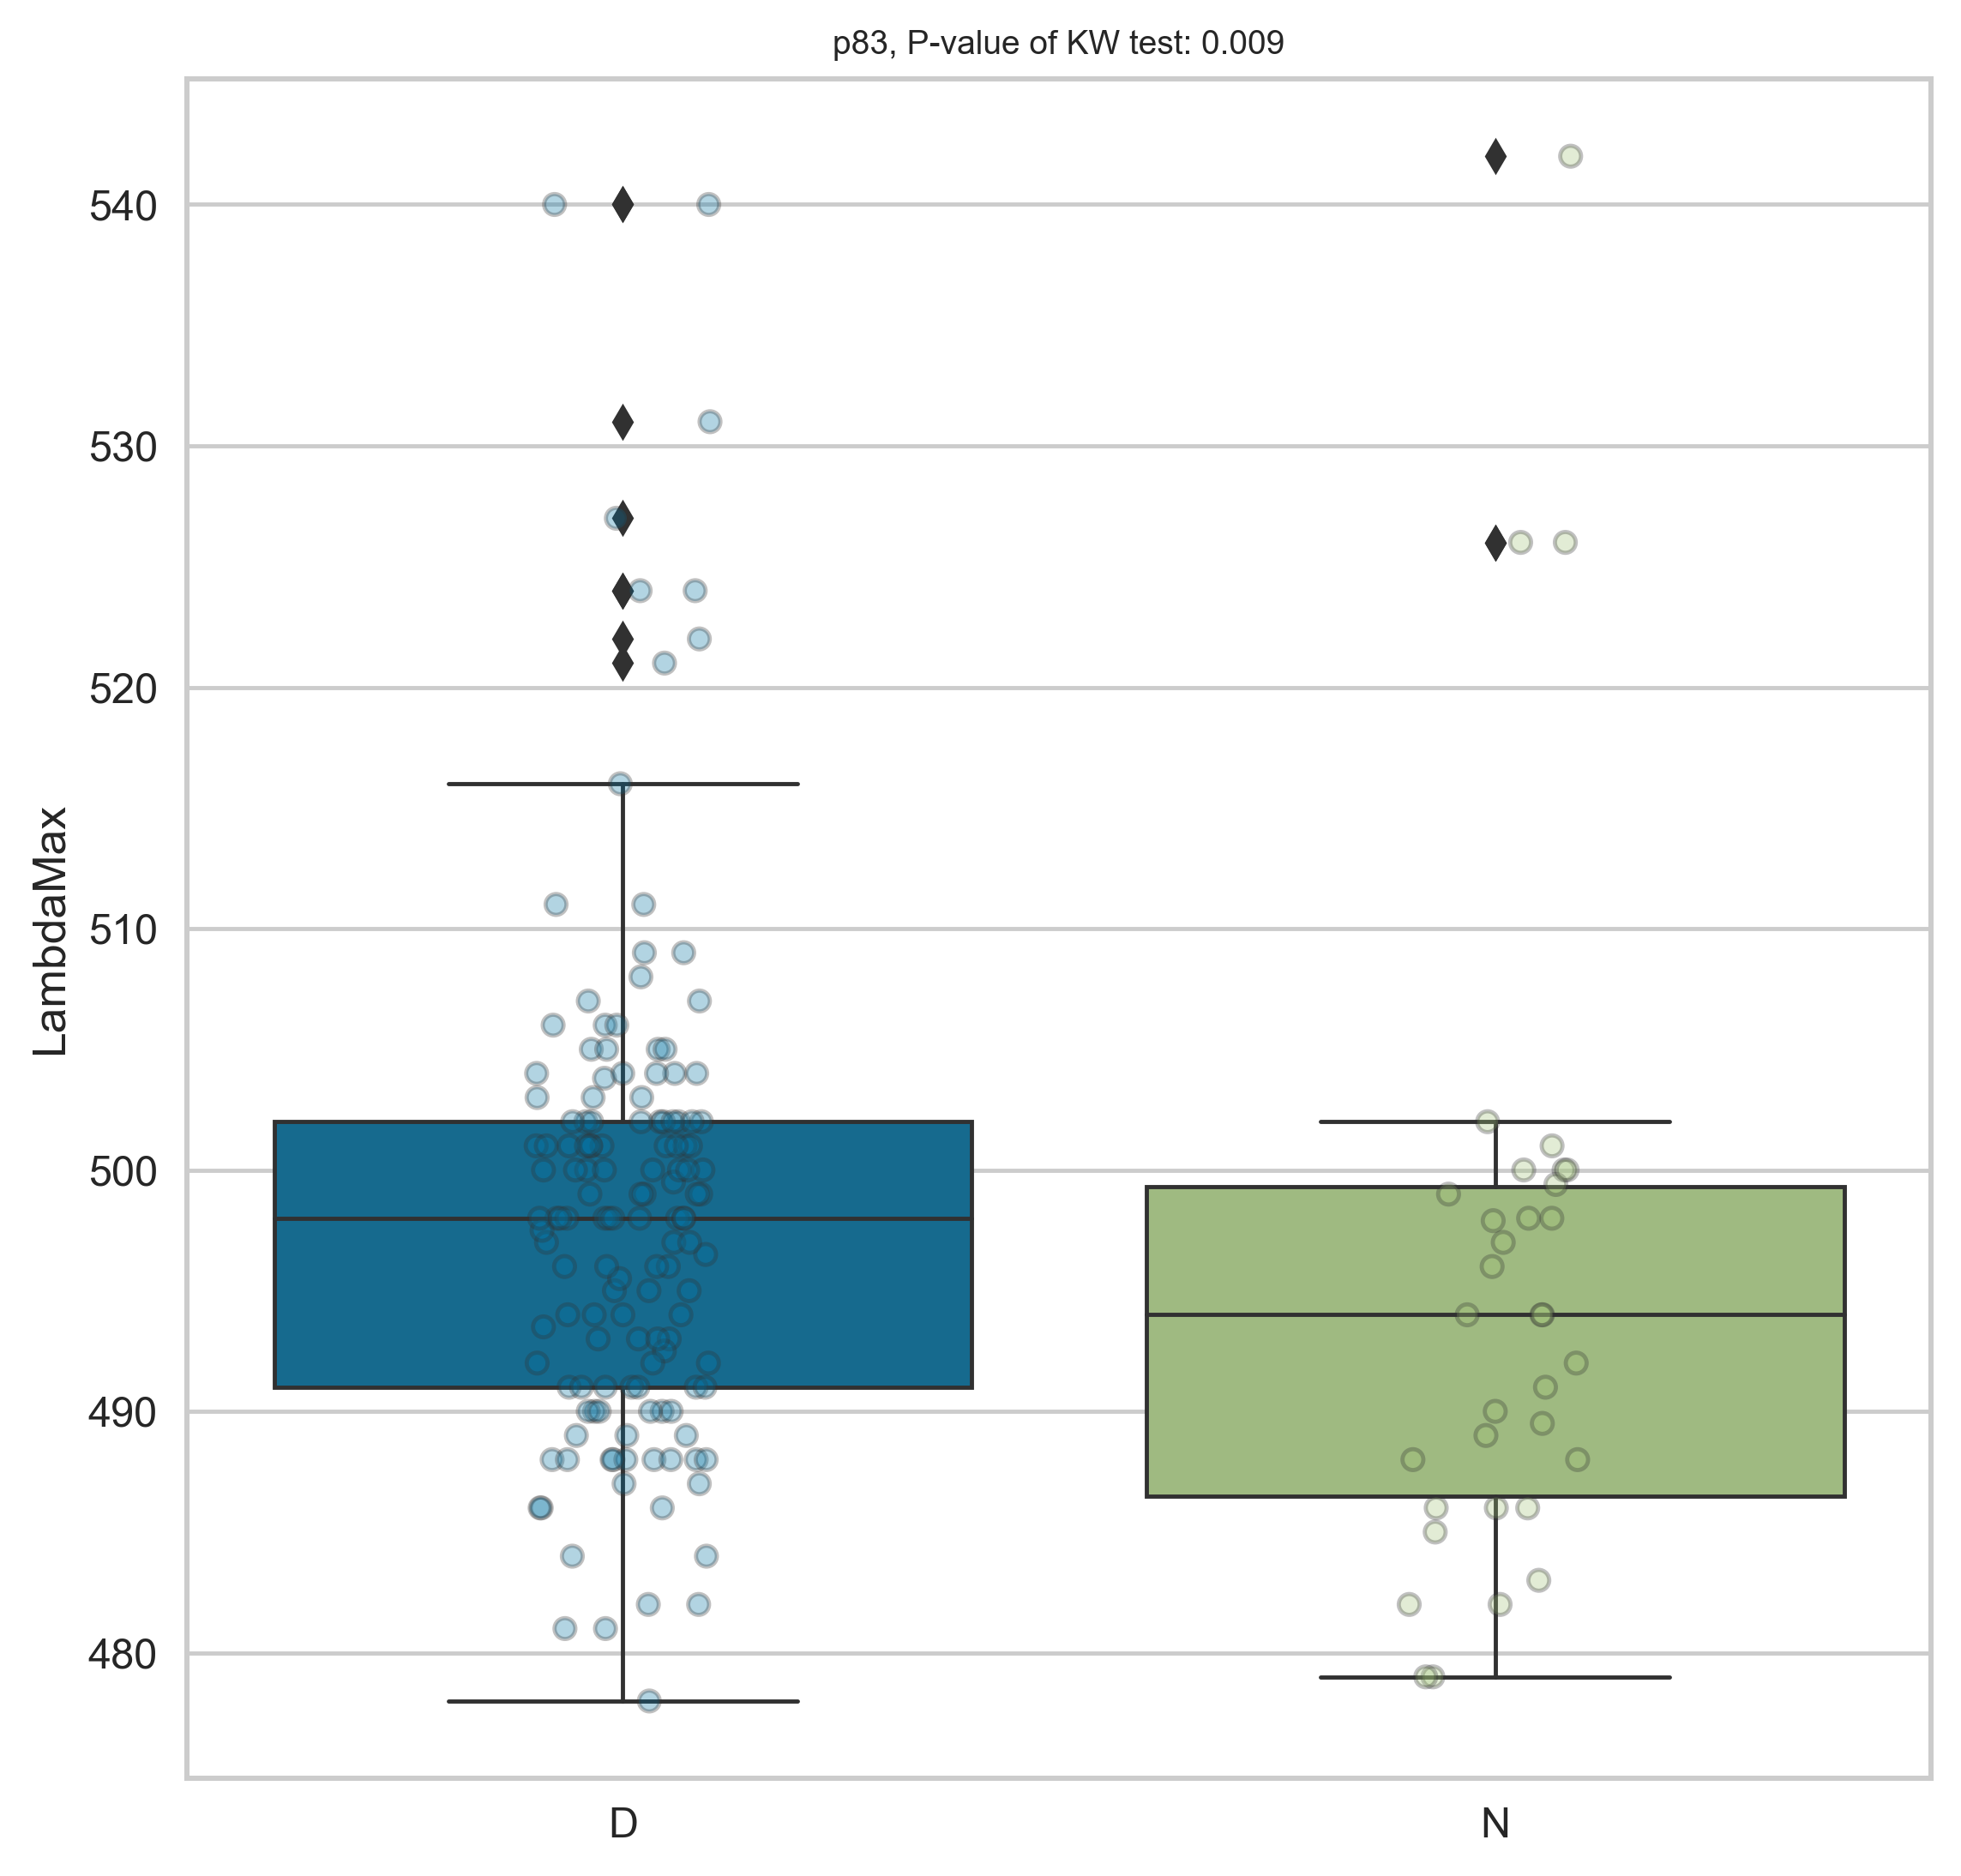

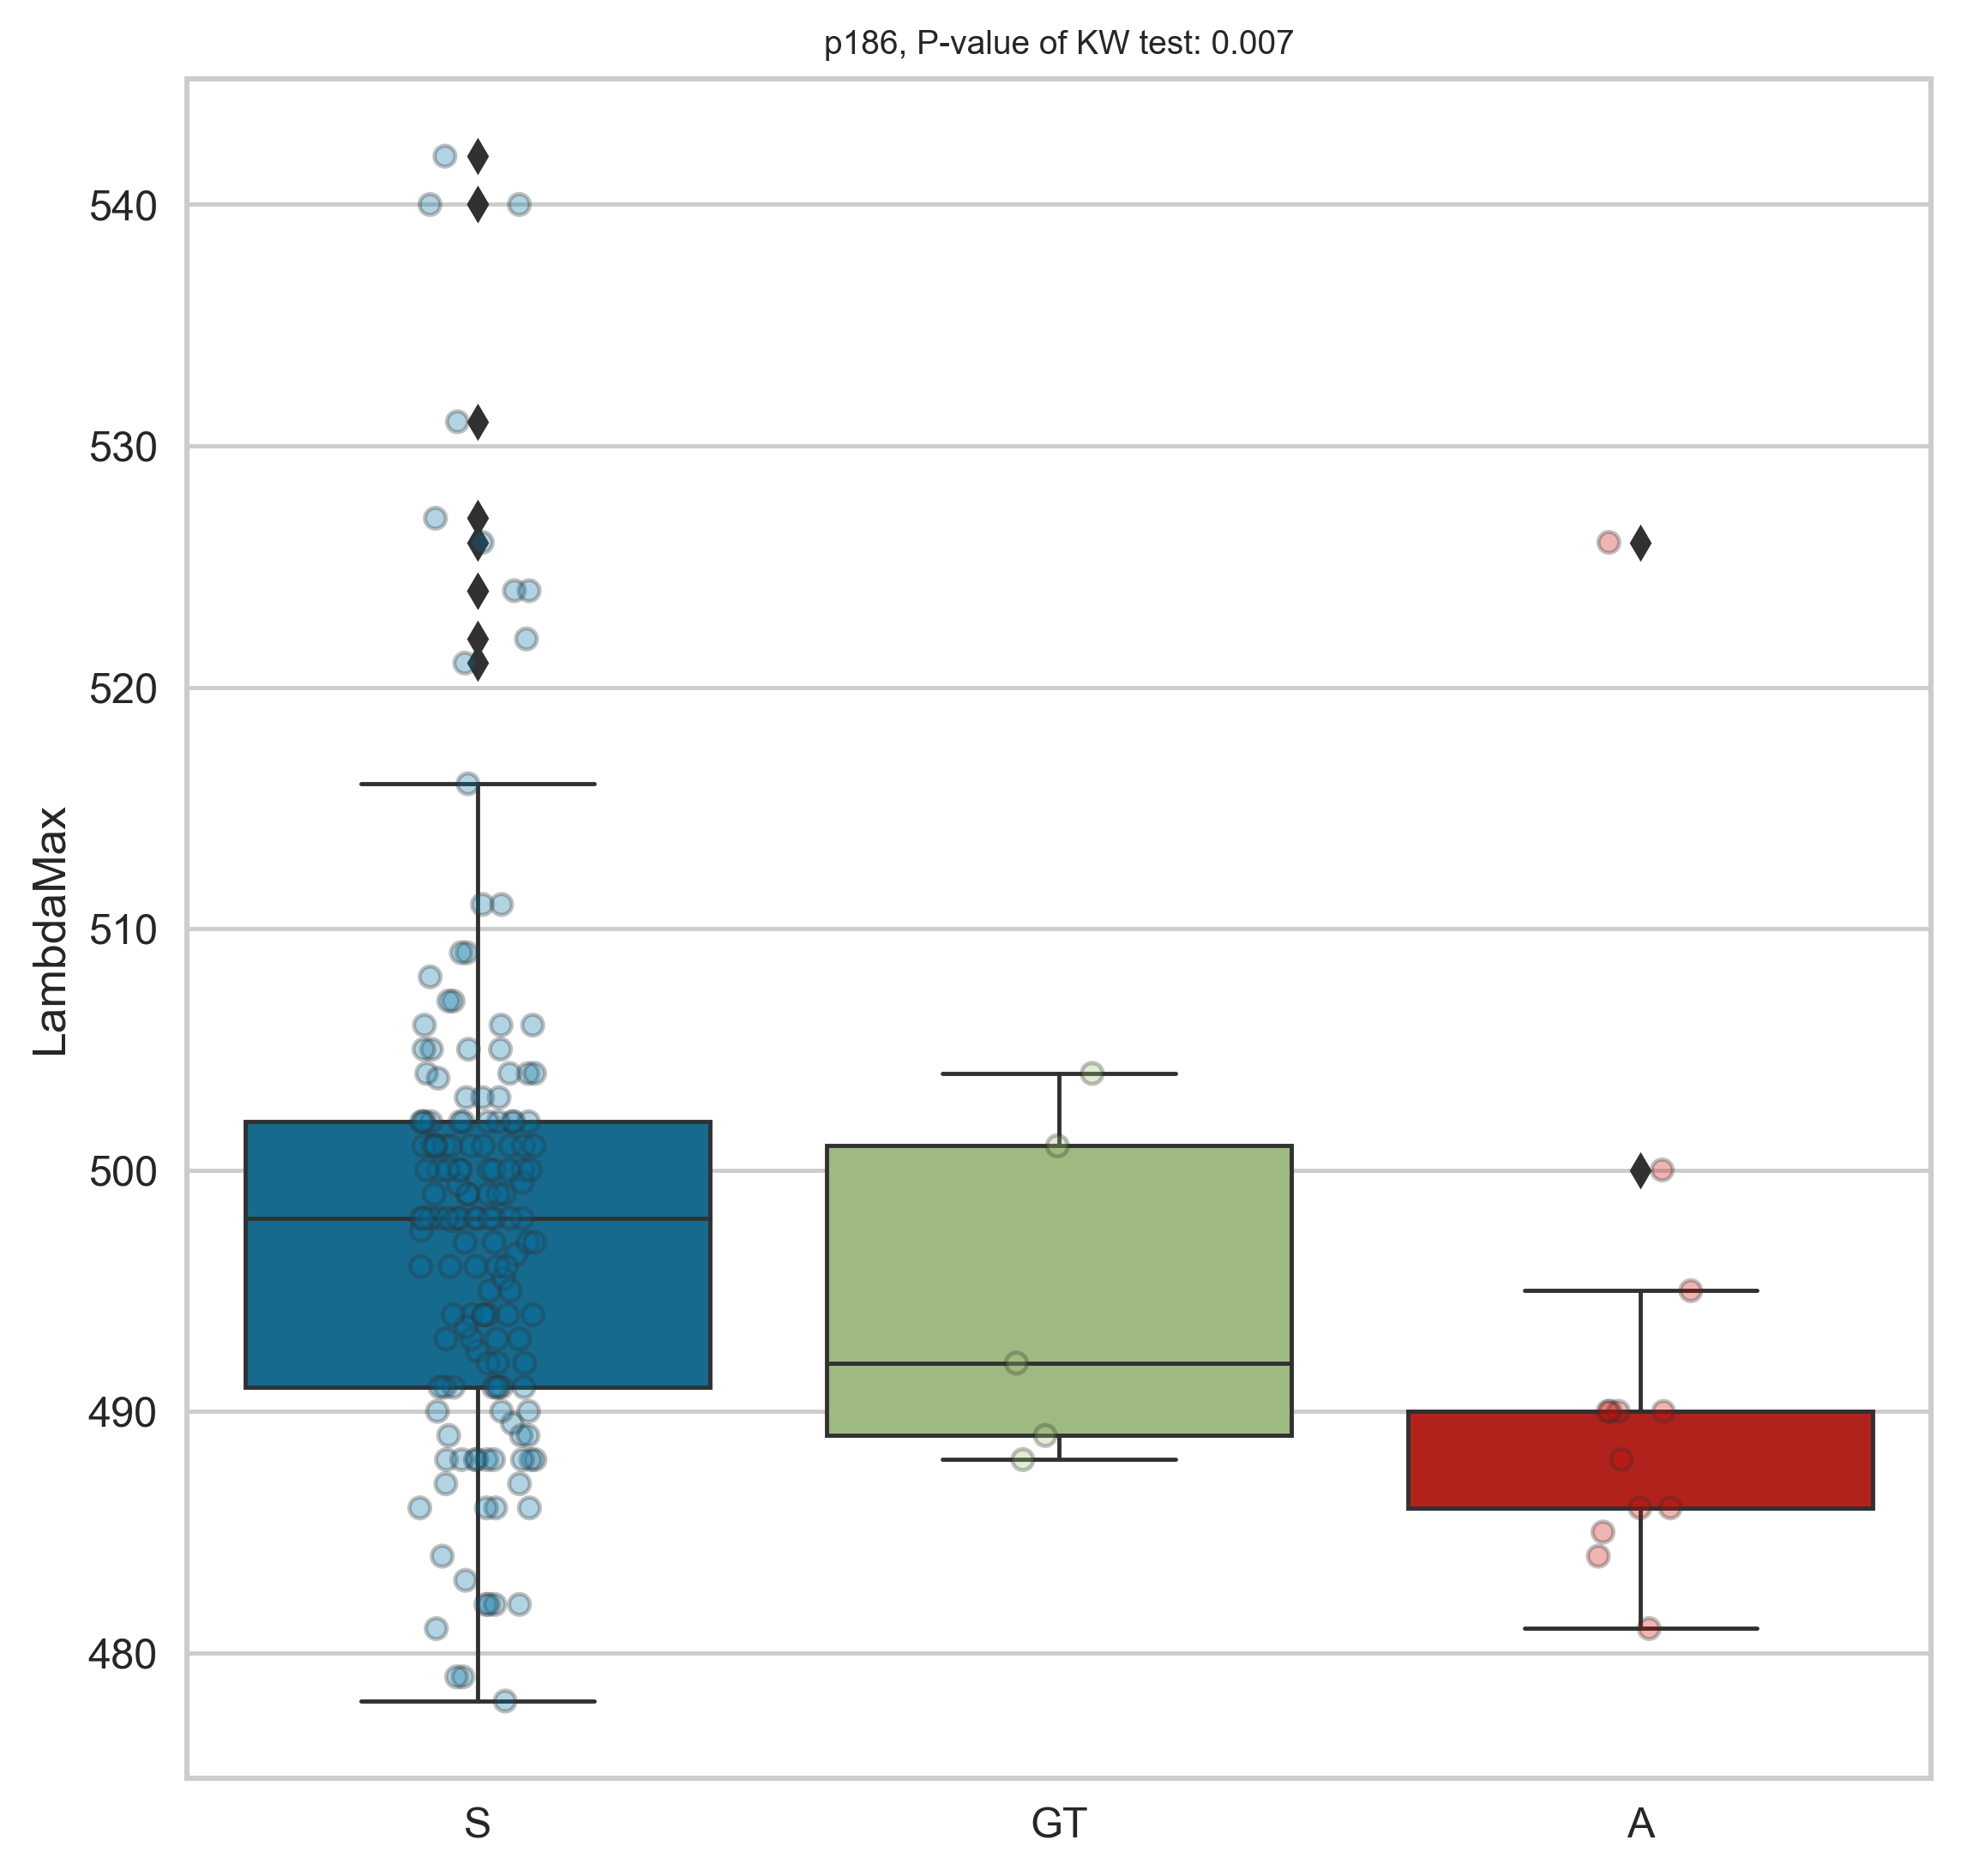

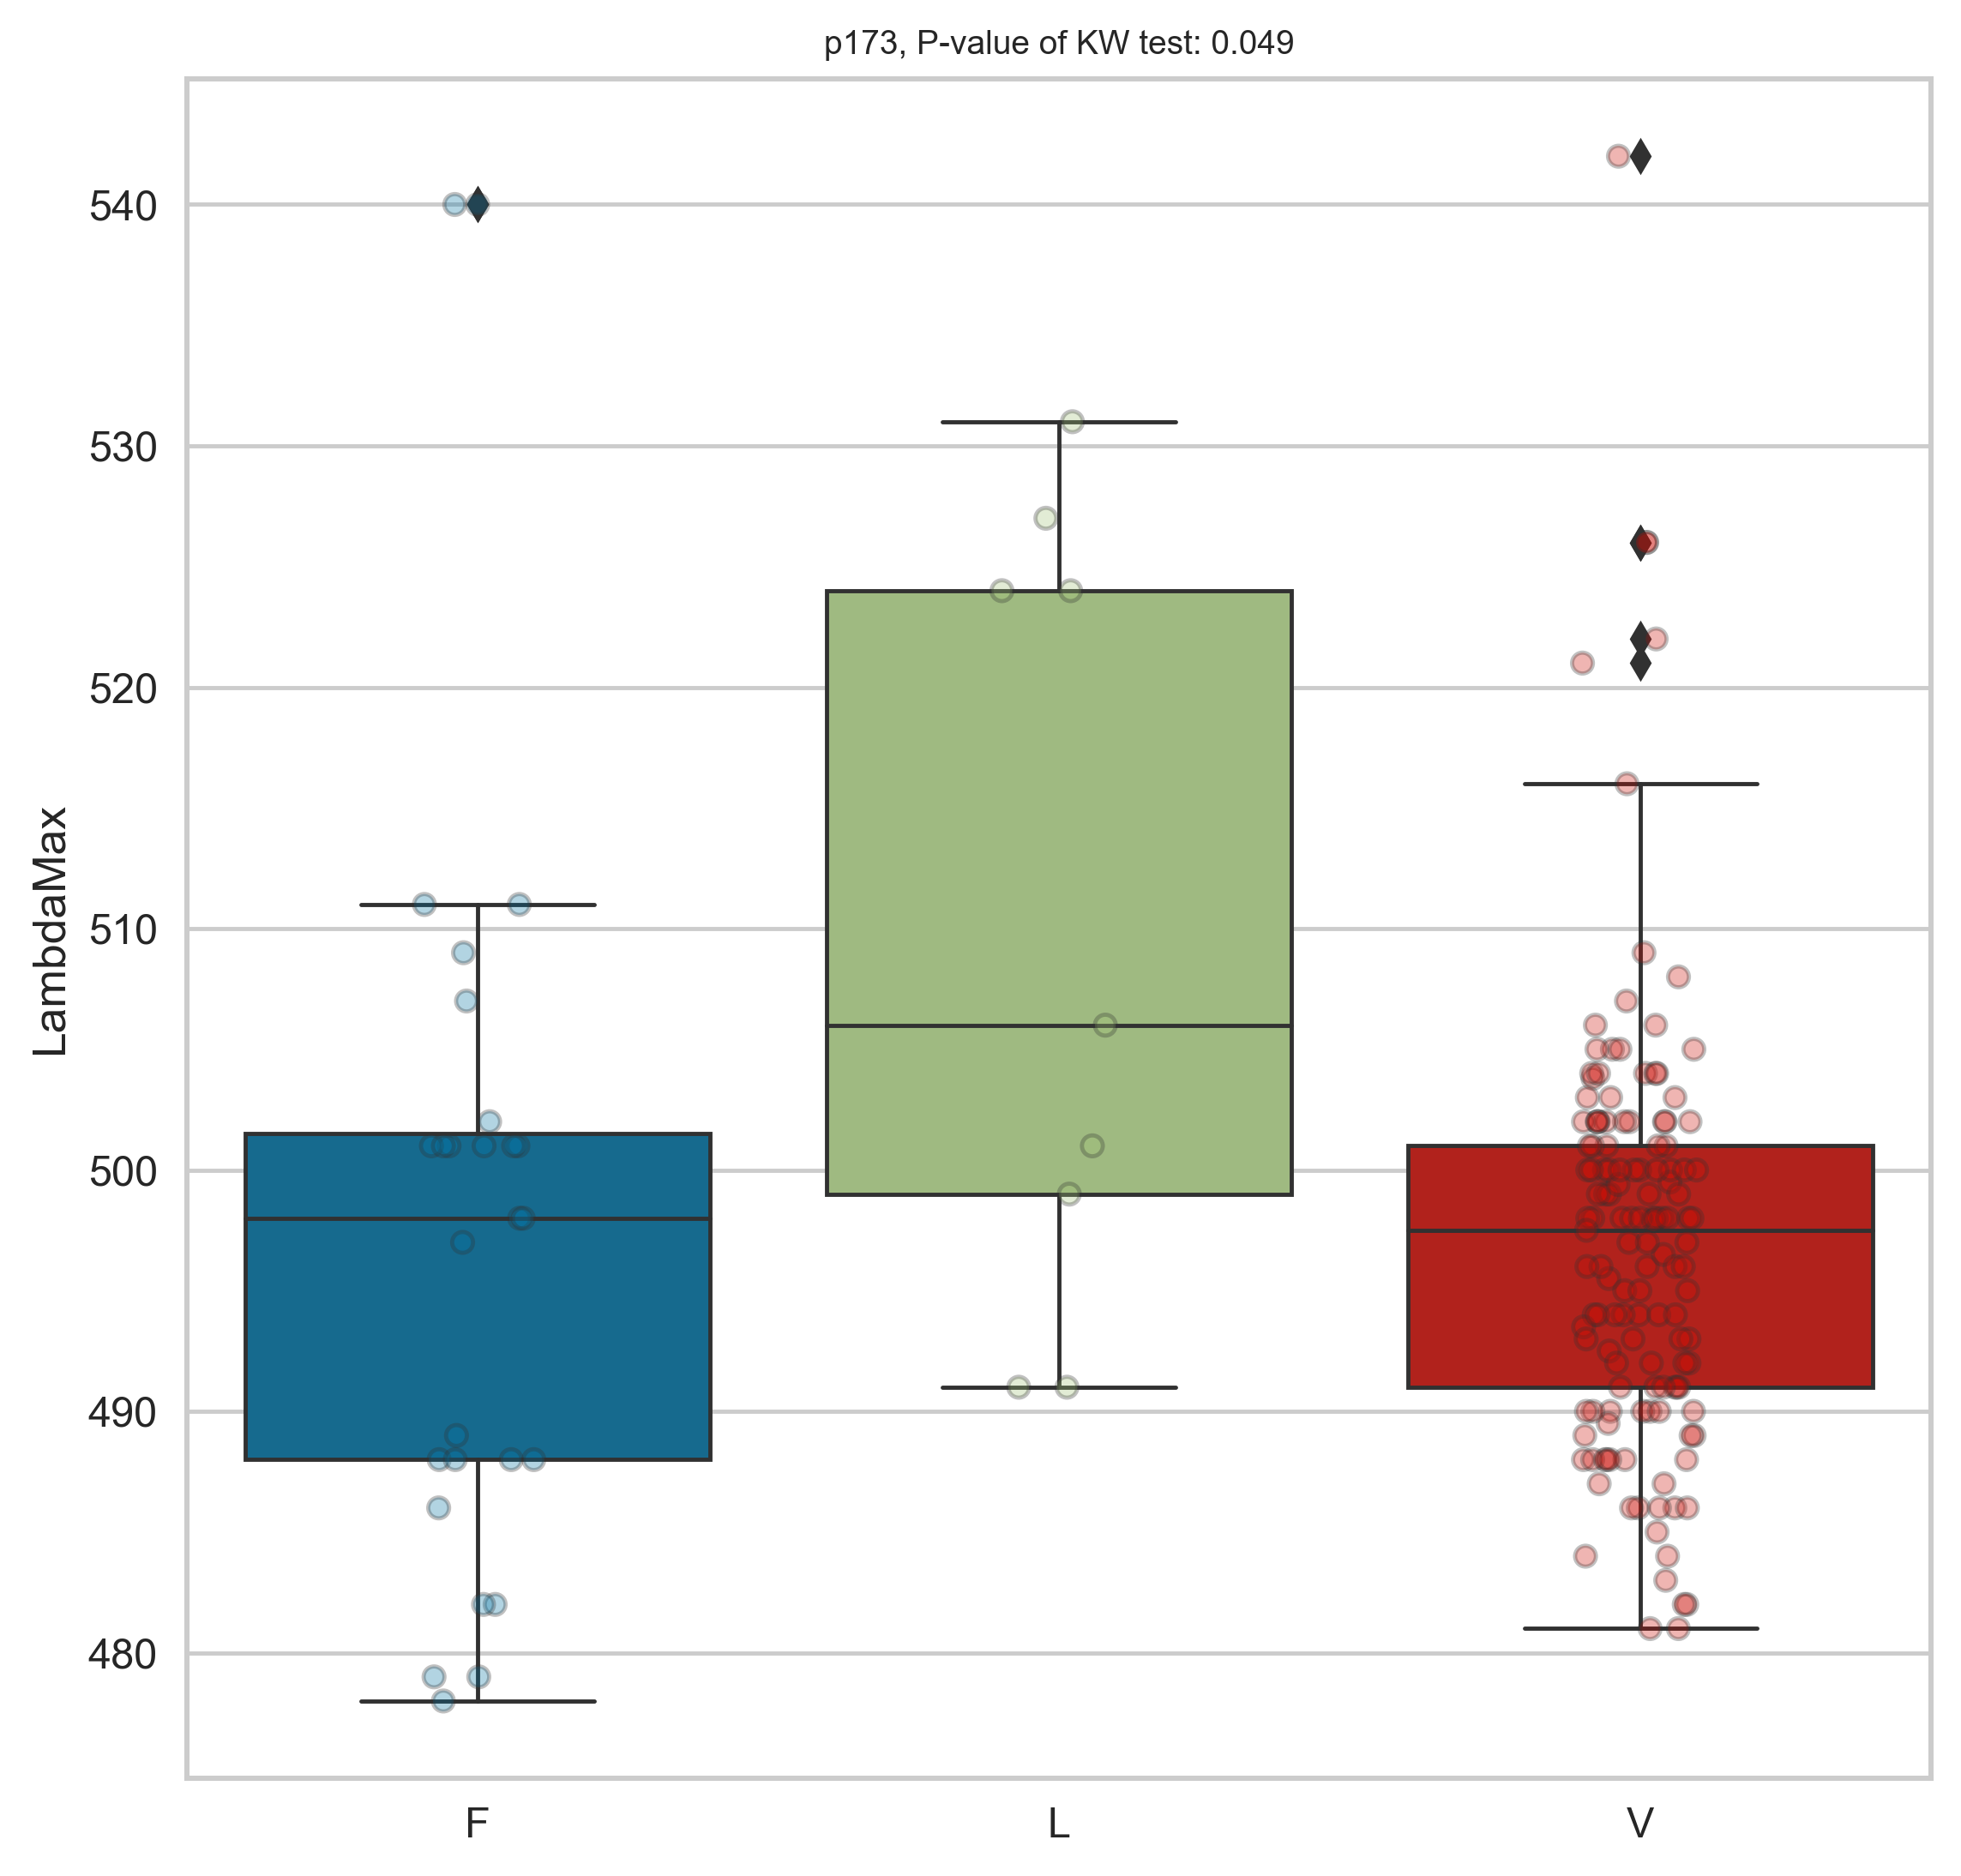

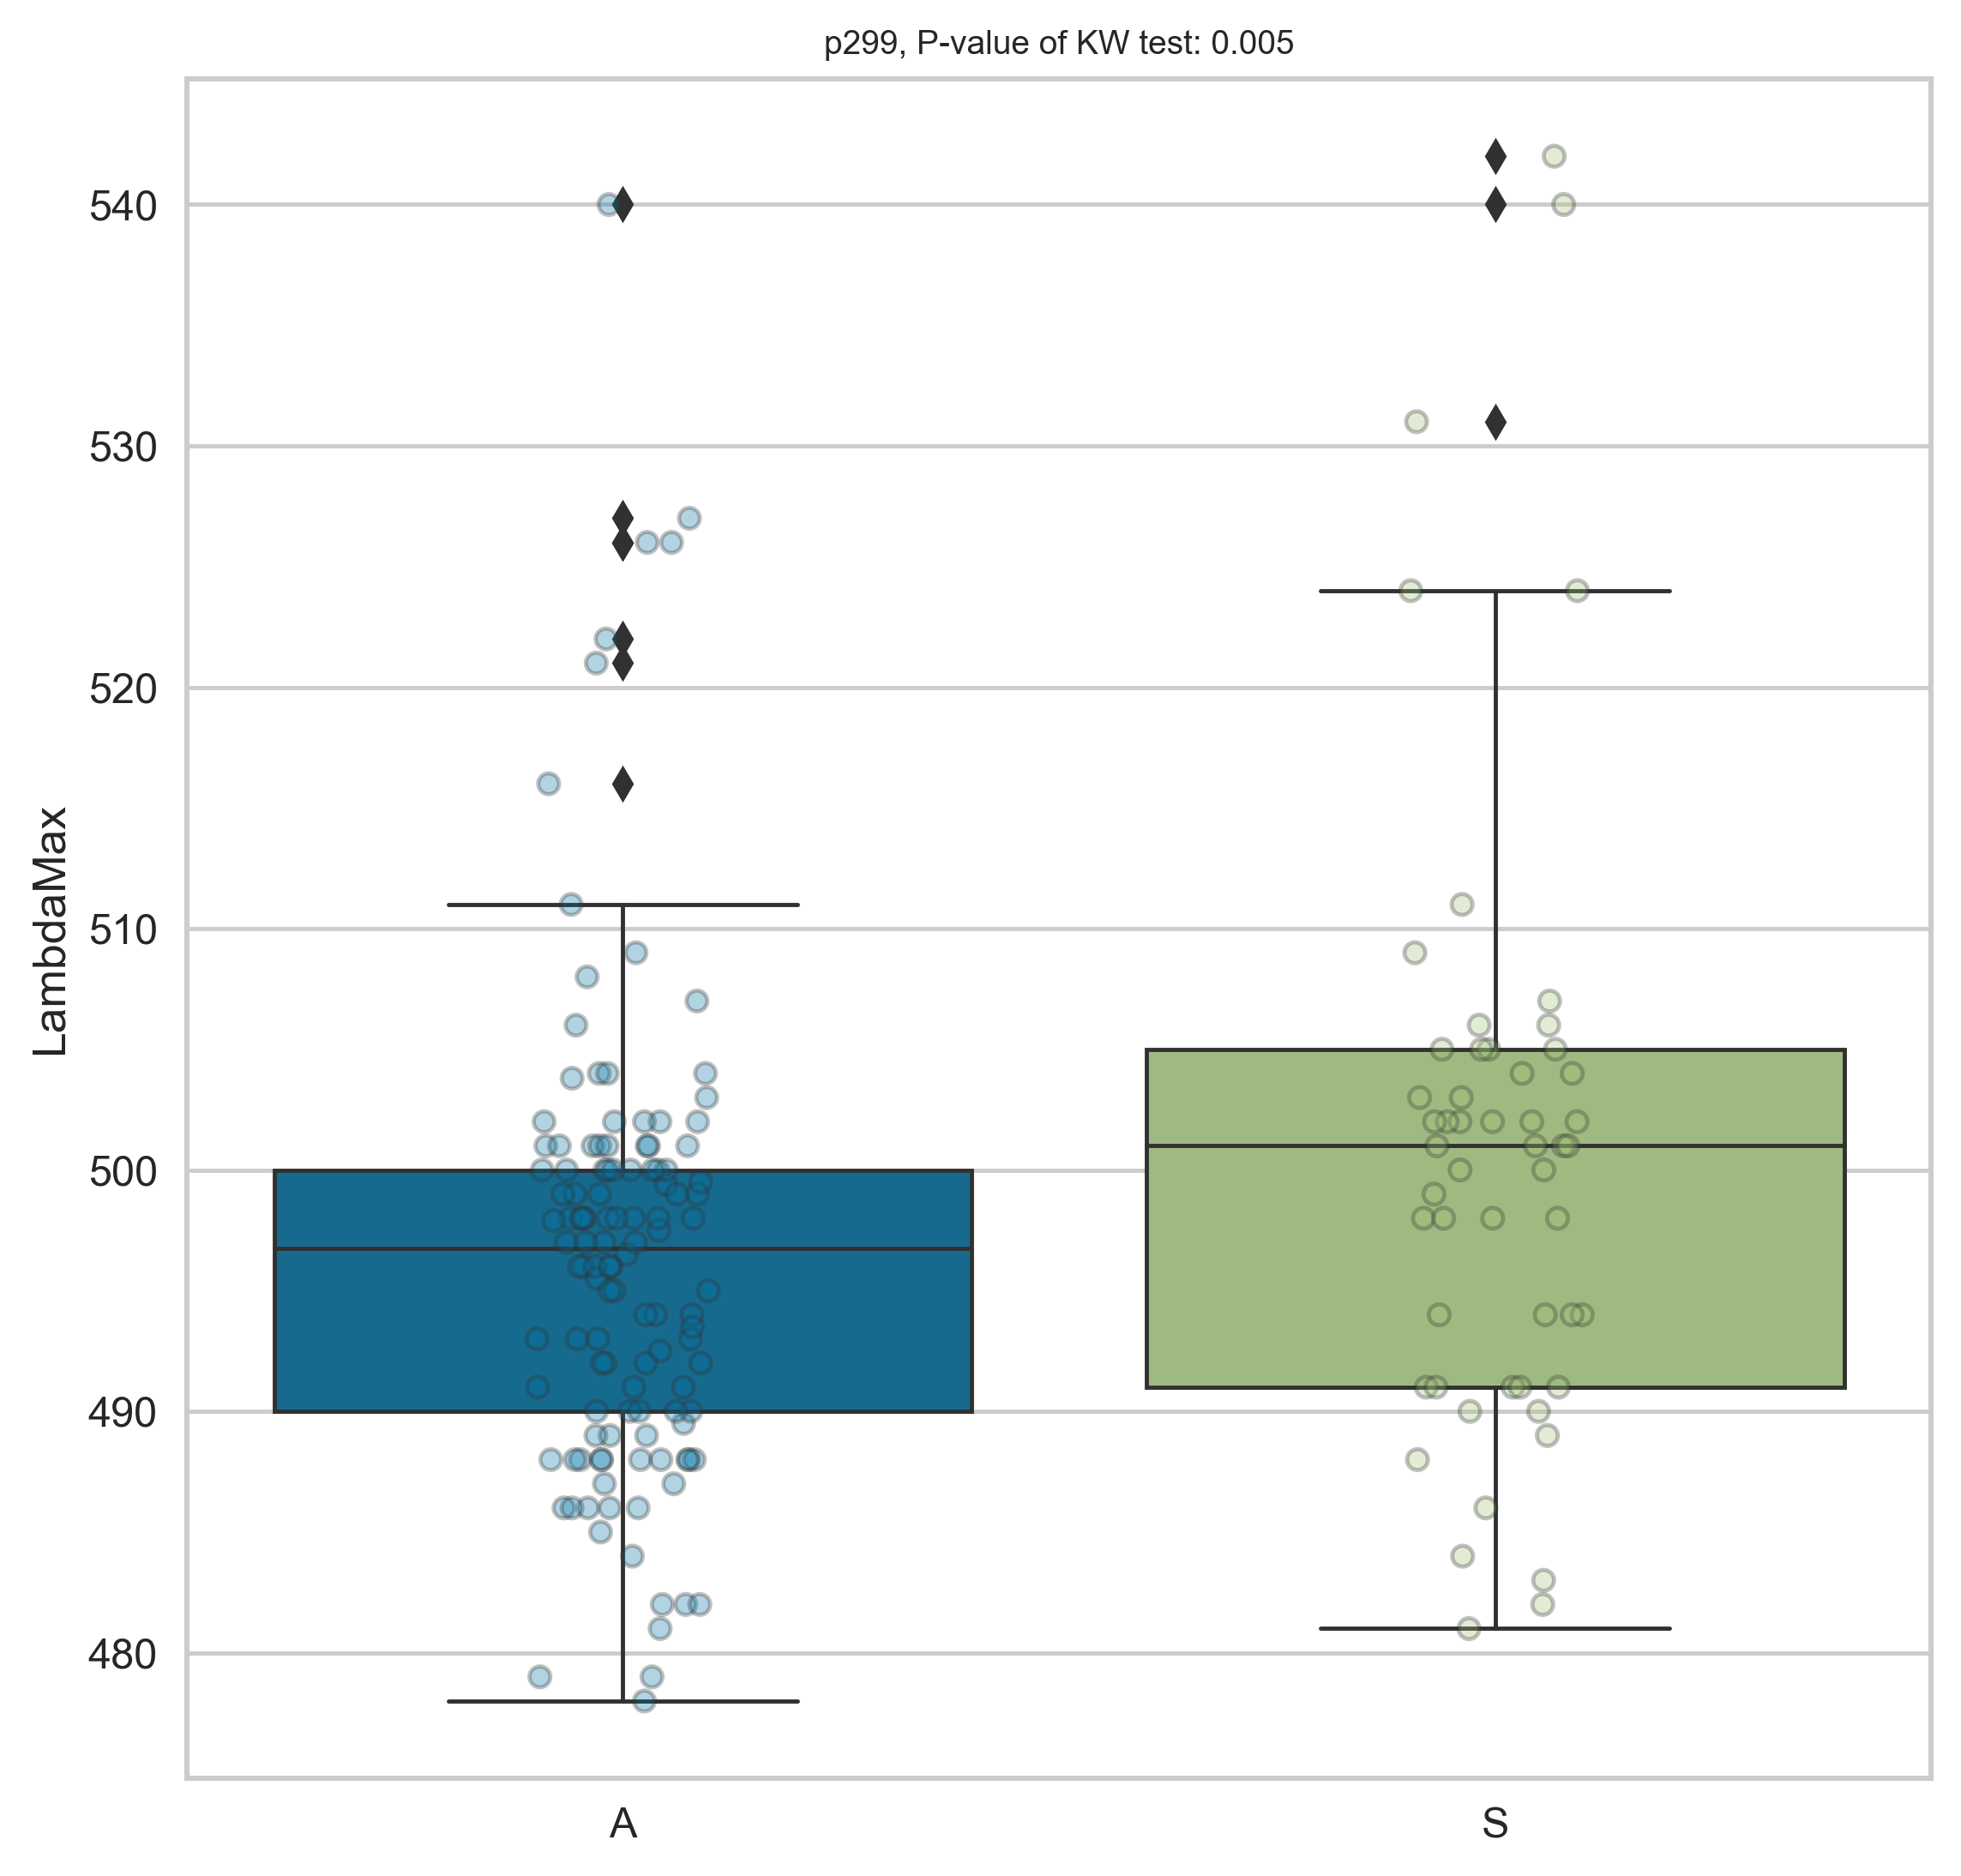

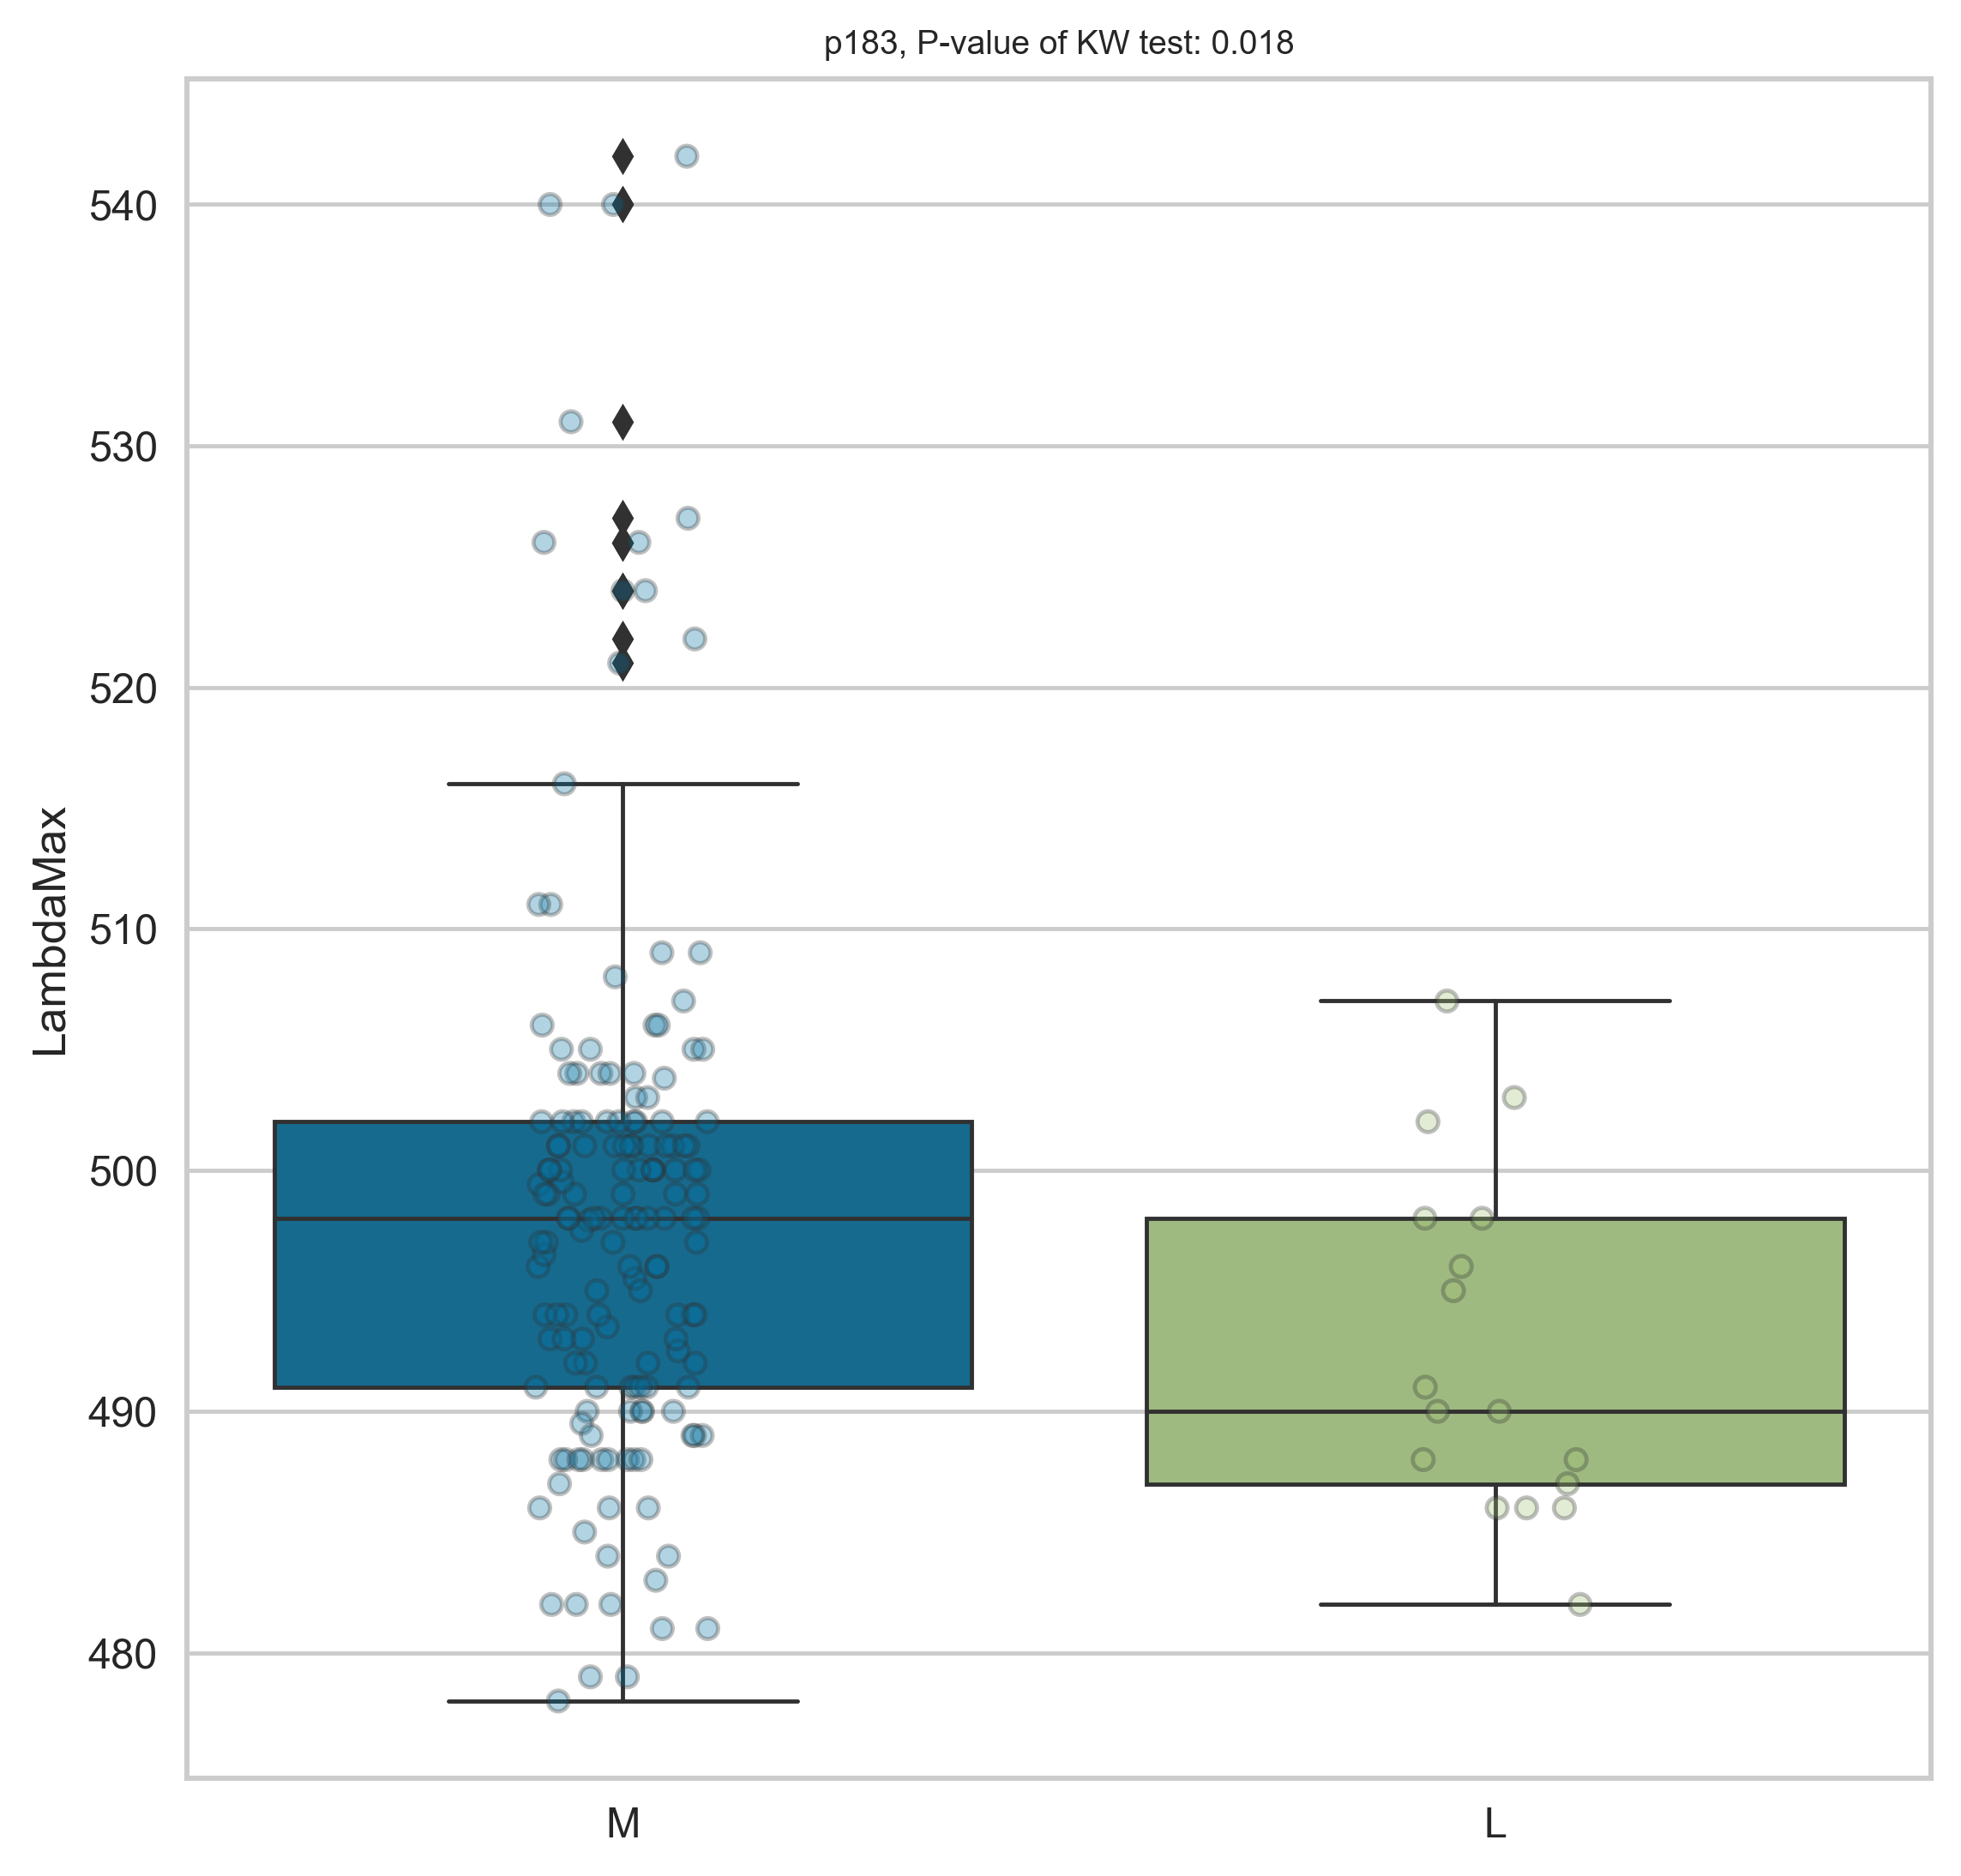

In [21]:
# visualizing top positions  
viz.plot_imp_all(trained_models=top_models, dat=df_cleaned, train_cols=train_cols,
             grouped_features=dc_df, meta_var = mt, model_type = anaType,
             n_positions= df.shape[1], report_dir = report_dir)